In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import rpy2.robjects as robjects

In [2]:
pd.set_option('display.precision', 1)
data = pd.read_csv("combined_data.csv")

In [3]:
data.head()

Unnamed: 0  household_size  empl_agriculture  empl_professional  \
0           0             2.6               1.1               11.2   
1           1             3.1              14.8                7.4   
2           2             3.3              16.0               10.1   
3           3             2.4               1.3               16.4   
4           4             2.6               1.1                9.4   

   empl_social  empl_services  empl_manufacturing  empl_retail  \
0         19.4            8.3                22.2         10.2   
1         21.6            8.9                 7.1          9.3   
2         19.7           10.9                 6.5          9.0   
3         20.7           11.5                 3.5         10.6   
4         25.5           11.5                 4.4         12.9   

   empl_transp_utilities  employed  ...  domestic_passengers  intl_passengers  \
0                    5.7     53742  ...               580000                0   
1                    4.4     52644  ...                    0                0   
2                    3.9    190707  ...               186000                0   
3                    6.8     44505  ...                    0                0   
4                    5.0     69649  ...                    0                0   

   order started  3/24/20  4/1/20  4/23/20 cases_march24 cases_april1  \
0       04/04/20        0       0        0             0           19   
1       03/19/20        0       0        1             0            4   
2       03/19/20        1       1        4            14           42   
3       03/19/20        0       0        1             2           26   
4       03/19/20        0       1        3             2            7   

   cases_april23  ten plus cases  
0             50         3/28/20  
1             35         4/12/20  
2            154         3/21/20  
3             36         3/28/20  
4             28          4/3/20  

[5 rows x 32 columns]

In [4]:
data[(data["county"] == "New York County") | (data["county"] == "Alameda County")]

Unnamed: 0  household_size  empl_agriculture  empl_professional  \
337         337             2.8               0.5               20.4   
489         489             2.1               0.1               21.6   

     empl_social  empl_services  empl_manufacturing  empl_retail  \
337         21.8            8.2                 9.7          8.6   
489         23.2           10.4                 2.5          6.5   

     empl_transp_utilities  employed  ...  domestic_passengers  \
337                    5.1    882648  ...             33736000   
489                    2.8    901880  ...             44647000   

     intl_passengers  order started  3/24/20  4/1/20  4/23/20 cases_march24  \
337          7714000       03/17/20        2       7       46           118   
489         24424000       03/22/20       30     165     1390          3187   

    cases_april1  cases_april23  ten plus cases  
337          313           1352         3/14/20  
489         7278          18252          3/6/20  

[2 rows x 32 columns]

In [5]:
data.columns.values

array(['Unnamed: 0', 'household_size', 'empl_agriculture',
       'empl_professional', 'empl_social', 'empl_services',
       'empl_manufacturing', 'empl_retail', 'empl_transp_utilities',
       'employed', 'prc_fam_poverty', 'avg_income', 'prc_public_transp',
       'population', 'pop_65_plus', 'health_ins', 'county', 'state',
       'FIPS', 'area', 'prc_obese', 'incarcerated', 'domestic_passengers',
       'intl_passengers', 'order started', '3/24/20', '4/1/20', '4/23/20',
       'cases_march24', 'cases_april1', 'cases_april23', 'ten plus cases'],
      dtype=object)

### transform the data

+ convert "ten plus cases" into days since 10+ cases detected
+ convert "order started" into days since order started
+ add population density

In [6]:
last_date = ""
date_re = re.compile("\d+/\d+/\d\d")
for label in data.columns.values:
    match = date_re.match(label)
    if match:
        last_date = label
last_date    

'4/23/20'

In [7]:
days_elapsed = list()

for x in range(data.shape[0]):
    # use days elapsed between the day ten+ cases confirmed and the last date of the deaths data
    dt = datetime.datetime.strptime(data.iloc[x]["ten plus cases"], "%m/%d/%y")
    last_day = datetime.datetime.strptime(last_date, "%m/%d/%y")
    days_elapsed.append((last_day.date()- dt.date()).days)

In [8]:
data["days since 10+"] = days_elapsed

In [9]:
data["days since 10+"].describe()

count    827.0
mean      27.6
std        8.4
min        0.0
25%       23.0
50%       28.0
75%       33.0
max       52.0
Name: days since 10+, dtype: float64

In [10]:
data = data.drop(["Unnamed: 0", "ten plus cases"], axis=1)

In [11]:
data.head()

household_size  empl_agriculture  empl_professional  empl_social  \
0             2.6               1.1               11.2         19.4   
1             3.1              14.8                7.4         21.6   
2             3.3              16.0               10.1         19.7   
3             2.4               1.3               16.4         20.7   
4             2.6               1.1                9.4         25.5   

   empl_services  empl_manufacturing  empl_retail  empl_transp_utilities  \
0            8.3                22.2         10.2                    5.7   
1            8.9                 7.1          9.3                    4.4   
2           10.9                 6.5          9.0                    3.9   
3           11.5                 3.5         10.6                    6.8   
4           11.5                 4.4         12.9                    5.0   

   employed  prc_fam_poverty  ...  domestic_passengers  intl_passengers  \
0     53742              9.9  ...               580000                0   
1     52644             15.6  ...                    0                0   
2    190707             10.5  ...               186000                0   
3     44505              5.1  ...                    0                0   
4     69649              9.5  ...                    0                0   

   order started  3/24/20  4/1/20 4/23/20 cases_march24  cases_april1  \
0       04/04/20        0       0       0             0            19   
1       03/19/20        0       0       1             0             4   
2       03/19/20        1       1       4            14            42   
3       03/19/20        0       0       1             2            26   
4       03/19/20        0       1       3             2             7   

   cases_april23  days since 10+  
0             50              26  
1             35              11  
2            154              33  
3             36              26  
4             28              20  

[5 rows x 31 columns]

In [12]:
days_elapsed = list()

for x in range(data.shape[0]):
    order = data.iloc[x]["order started"]
    if type(order) == str:
        dt = datetime.datetime.strptime(order, "%m/%d/%y")
        days_elapsed.append((datetime.date.today() - dt.date()).days)
    else:
        days_elapsed.append(0)

In [13]:
data["days since order"] = days_elapsed

In [14]:
data.describe()

household_size  empl_agriculture  empl_professional  empl_social  \
count           827.0             827.0              827.0        827.0   
mean              2.6               1.9               10.1         23.9   
std               0.3               2.7                3.6          4.8   
min               1.9               0.0                0.0          0.0   
25%               2.4               0.5                7.7         20.9   
50%               2.5               1.0                9.6         23.2   
75%               2.7               2.3               11.9         26.4   
max               4.1              25.7               30.1         46.2   

       empl_services  empl_manufacturing  empl_retail  empl_transp_utilities  \
count          827.0               827.0        827.0                  827.0   
mean             9.7                11.0         11.5                    5.3   
std              2.8                 5.9          2.0                    1.9   
min              0.0                 0.0          0.0                    0.0   
25%              8.0                 6.7         10.3                    4.0   
50%              9.3                10.0         11.4                    5.0   
75%             10.9                14.3         12.6                    6.4   
max             32.0                43.9         21.3                   17.2   

       employed  prc_fam_poverty  ...  domestic_passengers  intl_passengers  \
count   8.3e+02            827.0  ...              8.3e+02          8.3e+02   
mean    1.6e+05              9.0  ...              4.2e+06          7.5e+05   
std     2.9e+05              4.2  ...              9.3e+06          2.9e+06   
min     1.8e+04              1.3  ...              0.0e+00          0.0e+00   
25%     4.4e+04              5.9  ...              0.0e+00          0.0e+00   
50%     7.5e+04              8.4  ...              3.0e+05          0.0e+00   
75%     1.7e+05             11.4  ...              2.2e+06          0.0e+00   
max     5.0e+06             29.4  ...              4.6e+07          2.4e+07   

       3/24/20  4/1/20  4/23/20  cases_march24  cases_april1  cases_april23  \
count    827.0   827.0    827.0          827.0         827.0          827.0   
mean       0.8     4.9     50.1           54.9         239.8          981.7   
std        4.8    26.8    222.8          323.6        1077.8         3553.6   
min        0.0     0.0      0.0            0.0           0.0            0.0   
25%        0.0     0.0      1.0            2.0          12.0           59.0   
50%        0.0     0.0      5.0            5.0          32.0          152.0   
75%        0.0     2.0     19.0           18.0         103.5          452.0   
max       87.0   448.0   3304.0         5066.0       16336.0        45313.0   

       days since 10+  days since order  
count           827.0             827.0  
mean             27.6              25.7  
std               8.4               8.1  
min               0.0               0.0  
25%              23.0              22.0  
50%              28.0              25.0  
75%              33.0              32.0  
max              52.0              38.0  

[8 rows x 29 columns]

In [15]:
data = data.drop(["order started"], axis=1)

In [16]:
data["pop density"] = data["population"] / data["area"]

In [17]:
data.describe()

household_size  empl_agriculture  empl_professional  empl_social  \
count           827.0             827.0              827.0        827.0   
mean              2.6               1.9               10.1         23.9   
std               0.3               2.7                3.6          4.8   
min               1.9               0.0                0.0          0.0   
25%               2.4               0.5                7.7         20.9   
50%               2.5               1.0                9.6         23.2   
75%               2.7               2.3               11.9         26.4   
max               4.1              25.7               30.1         46.2   

       empl_services  empl_manufacturing  empl_retail  empl_transp_utilities  \
count          827.0               827.0        827.0                  827.0   
mean             9.7                11.0         11.5                    5.3   
std              2.8                 5.9          2.0                    1.9   
min              0.0                 0.0          0.0                    0.0   
25%              8.0                 6.7         10.3                    4.0   
50%              9.3                10.0         11.4                    5.0   
75%             10.9                14.3         12.6                    6.4   
max             32.0                43.9         21.3                   17.2   

       employed  prc_fam_poverty  ...  intl_passengers  3/24/20  4/1/20  \
count   8.3e+02            827.0  ...          8.3e+02    827.0   827.0   
mean    1.6e+05              9.0  ...          7.5e+05      0.8     4.9   
std     2.9e+05              4.2  ...          2.9e+06      4.8    26.8   
min     1.8e+04              1.3  ...          0.0e+00      0.0     0.0   
25%     4.4e+04              5.9  ...          0.0e+00      0.0     0.0   
50%     7.5e+04              8.4  ...          0.0e+00      0.0     0.0   
75%     1.7e+05             11.4  ...          0.0e+00      0.0     2.0   
max     5.0e+06             29.4  ...          2.4e+07     87.0   448.0   

       4/23/20  cases_march24  cases_april1  cases_april23  days since 10+  \
count    827.0          827.0         827.0          827.0           827.0   
mean      50.1           54.9         239.8          981.7            27.6   
std      222.8          323.6        1077.8         3553.6             8.4   
min        0.0            0.0           0.0            0.0             0.0   
25%        1.0            2.0          12.0           59.0            23.0   
50%        5.0            5.0          32.0          152.0            28.0   
75%       19.0           18.0         103.5          452.0            33.0   
max     3304.0         5066.0       16336.0        45313.0            52.0   

       days since order  pop density  
count             827.0        827.0  
mean               25.7        850.3  
std                 8.1       3387.7  
min                 0.0          4.4  
25%                22.0        140.5  
50%                25.0        271.9  
75%                32.0        569.1  
max                38.0      71340.4  

[8 rows x 30 columns]

### Examine Data

In [18]:
data.loc[data["days since 10+"] > 50, ["county", last_date, 'household_size', 
                                       'pop density', 'prc_fam_poverty', 'avg_income',
                                       'prc_public_transp', 'population', 'pop_65_plus', 
                                       'health_ins', 'area', 'domestic_passengers', 
                                       'intl_passengers', "prc_obese", "incarcerated",
                                       "days since 10+", "days since order"]]

county  4/23/20  household_size  pop density  \
113  Santa Clara County       95             3.0       1501.9   
217         King County      385             2.5       1055.6   

     prc_fam_poverty  avg_income  prc_public_transp  population  pop_65_plus  \
113              4.1       58588                4.1     1937570         13.5   
217              5.5       52804               14.6     2233163         13.2   

     health_ins    area  domestic_passengers  intl_passengers  prc_obese  \
113        99.5  1290.1             33736000          7714000       19.2   
217        99.4  2115.6             21381000          2595600       21.9   

     incarcerated  days since 10+  days since order  
113        3488.0              51                38  
217        2975.0              52                32

In [19]:
data.loc[data[last_date] > 1000, ["county", last_date, 'household_size', 
                                       'pop density', 'prc_fam_poverty', 'avg_income',
                                       'prc_public_transp', 'population', 'pop_65_plus', 
                                       'health_ins', 'area', 'domestic_passengers', 
                                       'intl_passengers', "prc_obese", "incarcerated",
                                       "days since 10+", "days since order"]]

county  4/23/20  household_size  pop density  prc_fam_poverty  \
284     Bronx County     2342             2.7      34017.4             24.3   
287    Nassau County     1471             3.0       4770.8              4.1   
357      Cook County     1142             2.6       5480.1             10.2   
489  New York County     1390             2.1      71340.4             12.1   
574     Wayne County     1396             2.5       2865.5             16.6   
588     Kings County     3190             2.6      36470.3             15.4   
688    Queens County     3304             2.9      20997.9              9.1   

     avg_income  prc_public_transp  population  pop_65_plus  health_ins  \
284       21712               58.4     1432132         12.8        98.5   
287       50397               17.3     1358343         17.8        99.3   
357       37538               19.1     5180493         14.6        99.1   
489       74911               59.9     1628701         16.5        99.3   
574       26988                2.5     1753893         15.4        99.3   
588       34709               60.7     2582830         13.9        99.5   
688       31866               51.4     2278906         15.7        99.3   

      area  domestic_passengers  intl_passengers  prc_obese  incarcerated  \
284   42.1             44647000         24424000       28.8           0.0   
287  284.7             28745000         17574400       23.0        1192.0   
357  945.3             43405000          7100700       27.7        7844.0   
489   22.8             44647000         24424000       14.7        9500.0   
574  612.1             15550999          1861100       34.4        1865.0   
588   70.8             43872000         24424000       22.6           0.0   
688  108.5             44647000         24424000       23.0           0.0   

     days since 10+  days since order  
284              48                33  
287              45                33  
357              44                34  
489              48                33  
574              38                31  
588              48                33  
688              48                33

In [20]:
data.loc[data[last_date] < 200, ["county", last_date, 'household_size', 
                                       'pop density', 'prc_fam_poverty', 'avg_income',
                                       'prc_public_transp', 'population', 'pop_65_plus', 
                                       'health_ins', 'area', 'domestic_passengers', 
                                       'intl_passengers', "prc_obese",
                                       "days since 10+", "days since order"]]

county  4/23/20  household_size  pop density  prc_fam_poverty  \
0       Morgan County        0             2.6        205.6              9.9   
1        Kings County        1             3.1        108.9             15.6   
2     Monterey County        4             3.3        132.8             10.5   
3       Nevada County        1             2.4        104.1              5.1   
4       Shasta County        3             2.6         47.7              9.5   
..                ...      ...             ...          ...              ...   
822  Snohomish County      101             2.7        390.4              5.2   
823  Jefferson County        0             2.5        153.0              6.4   
824  Milwaukee County      150             2.4       3927.9             14.1   
825  Outagamie County        2             2.5        293.9              5.4   
826     Racine County       10             2.5        591.2              8.5   

     avg_income  prc_public_transp  population  pop_65_plus  health_ins  \
0         27742                0.4      119089         17.2        98.8   
1         22628                0.5      151366         10.2        90.1   
2         30674                1.3      435594         13.7        96.3   
3         37645                0.1       99696         27.8        98.8   
4         28144                0.8      180040         20.6        99.2   
..          ...                ...         ...          ...         ...   
822       39500                5.9      814901         13.5        98.8   
823       33545                0.1       85129         17.2        99.3   
824       28641                4.2      948201         13.6        99.0   
825       32489                0.5      187365         14.7        99.3   
826       29897                1.6      196584         16.5        97.4   

       area  domestic_passengers  intl_passengers  prc_obese  days since 10+  \
0     579.3               580000                0       32.1              26   
1    1389.4                    0                0       29.4              11   
2    3280.6               186000                0       27.6              33   
3     957.8                    0                0       21.5              26   
4    3775.4                    0                0       23.3              20   
..      ...                  ...              ...        ...             ...   
822  2087.3                    0                0       28.6              49   
823   556.5              1034000                0       29.5              24   
824   241.4              3421000                0       32.0              38   
825   637.5               654000                0       33.1              23   
826   332.5              3421000                0       36.1              26   

     days since order  
0                  20  
1                  36  
2                  36  
3                  36  
4                  36  
..                ...  
822                32  
823                30  
824                30  
825                30  
826                30  

[788 rows x 16 columns]

In [21]:
%load_ext rpy2.ipython

/home/anna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "county". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/anna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "state". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
R[write to console]: corrplot 0.84 loaded



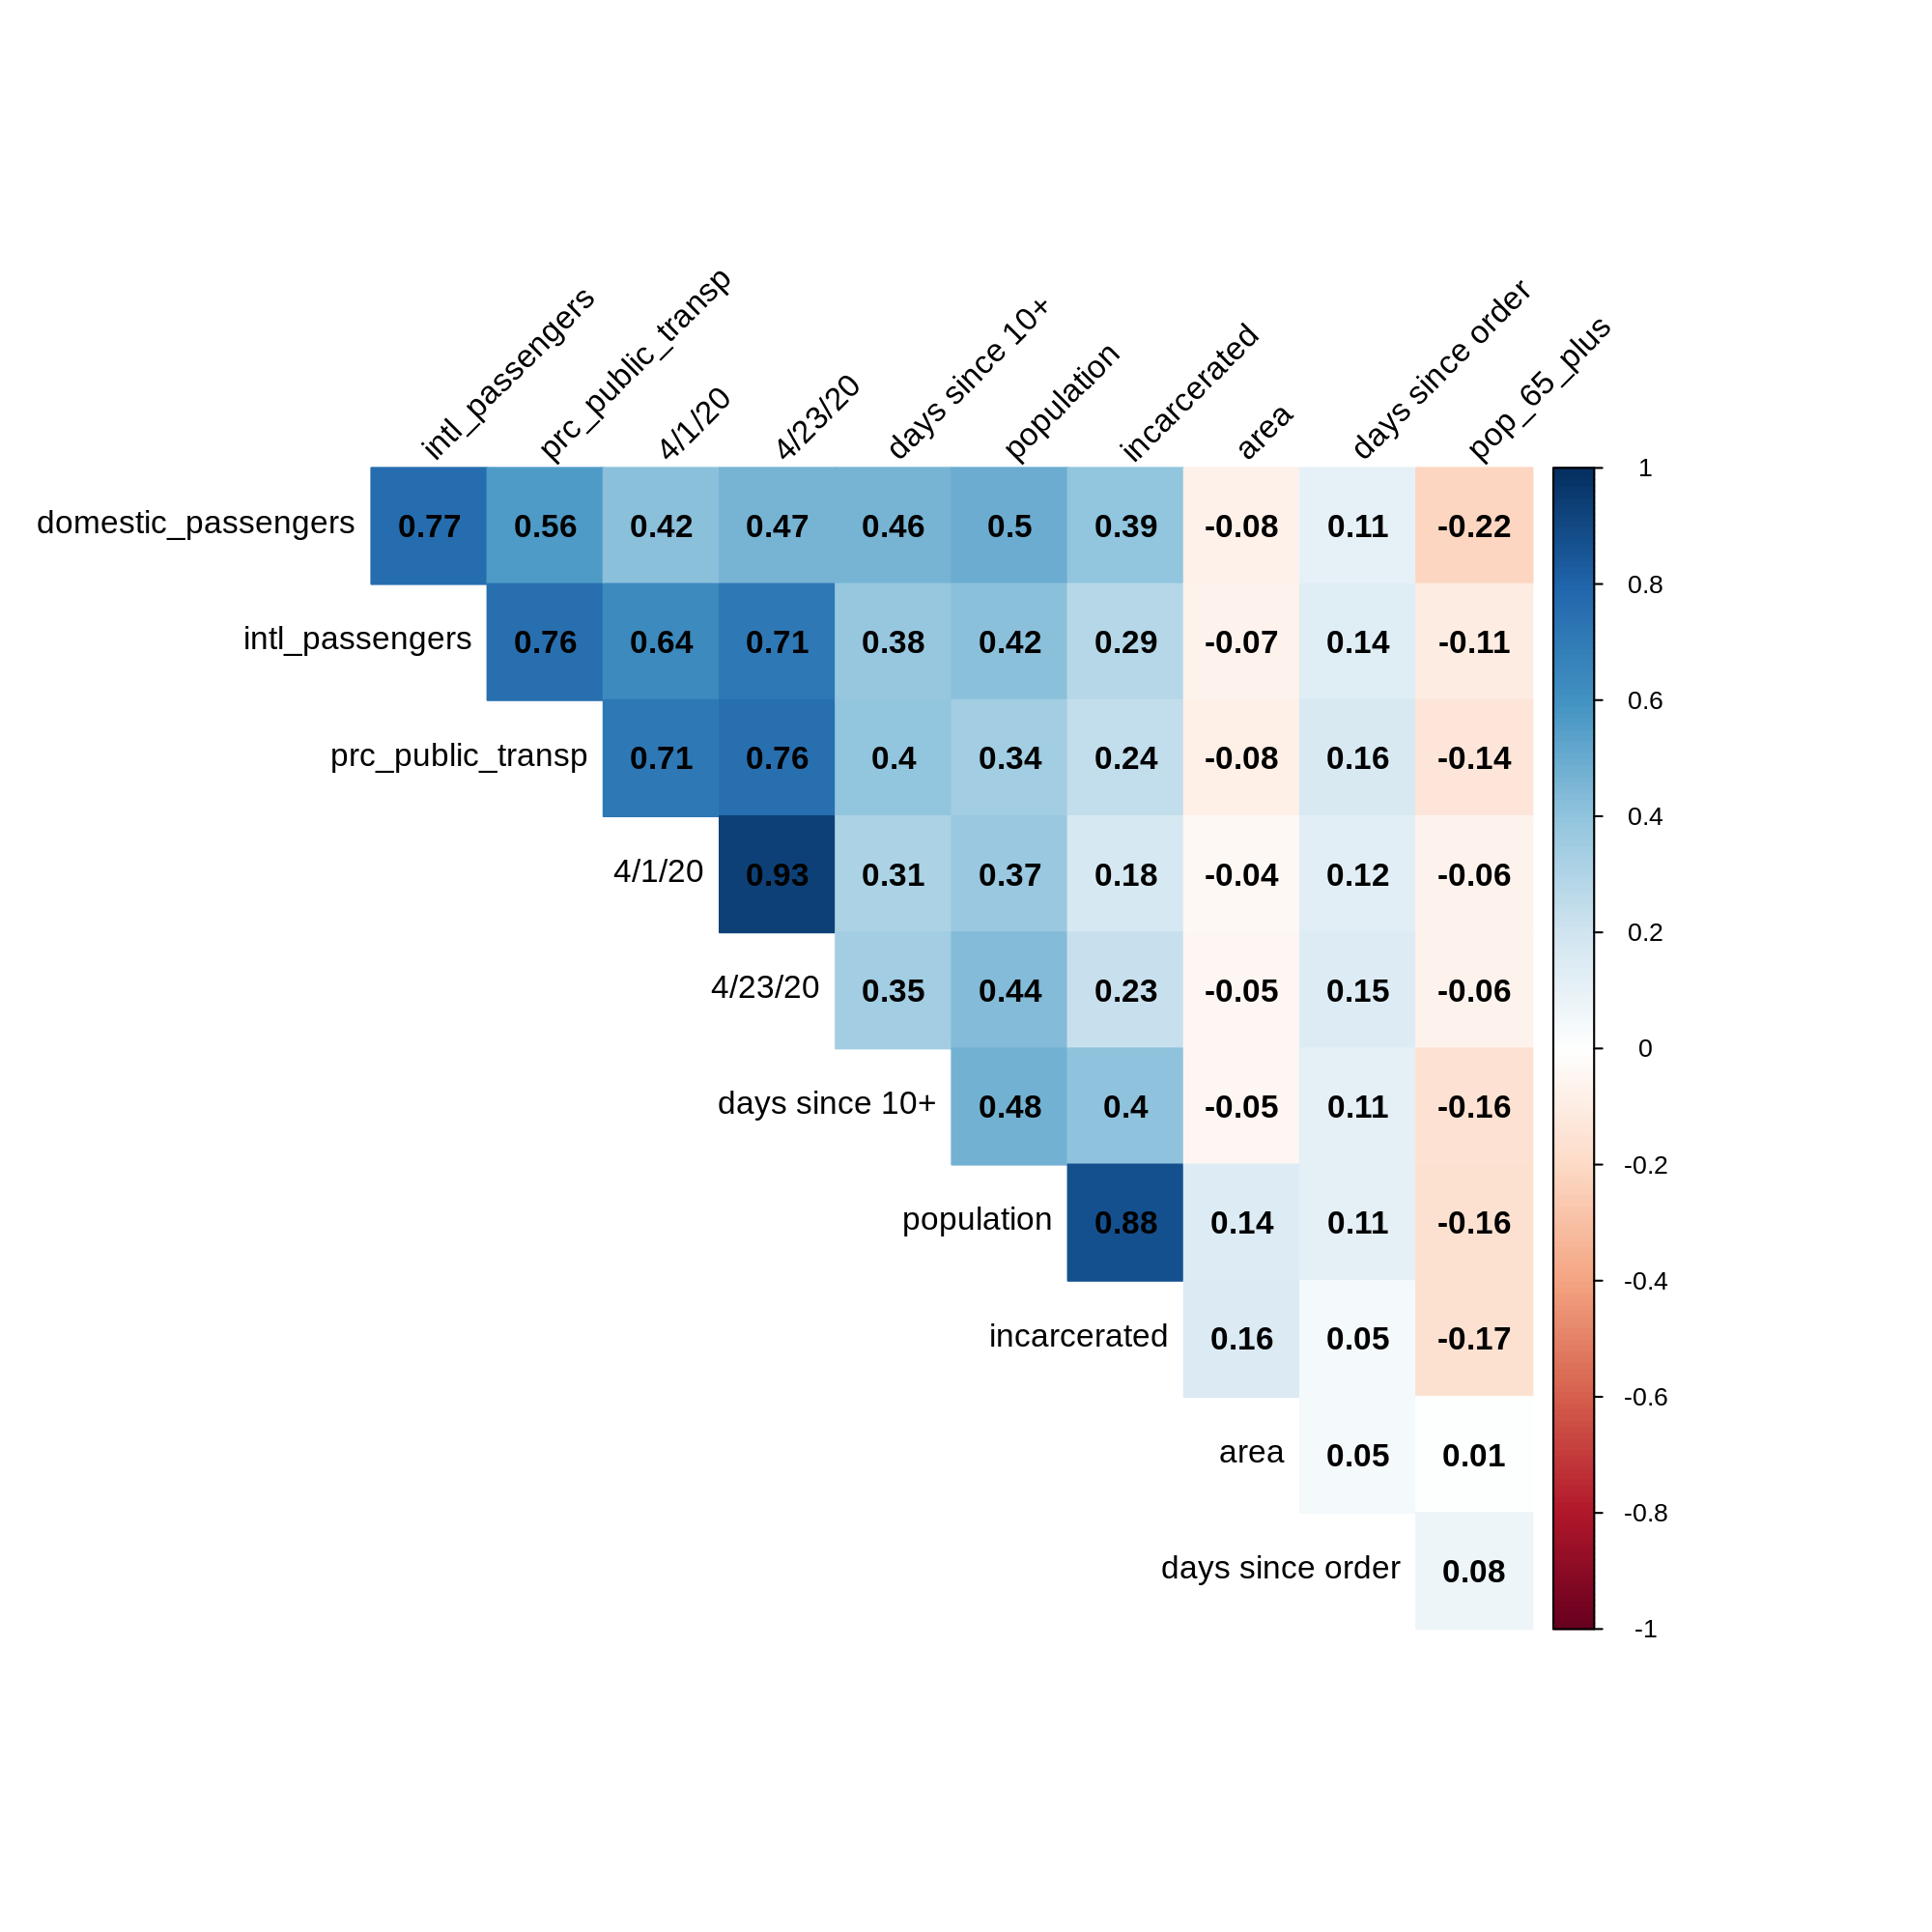

In [22]:
%%R -i data -w 10 -h 10 --units in -r 200

library(corrplot)
corr = cor(data[c("days since 10+", "days since order", "population", "pop_65_plus", "domestic_passengers", 
                  "intl_passengers", "prc_public_transp", "area", "incarcerated", "4/1/20", "4/23/20")])
corrplot(corr, method="color", type="upper", order="hclust", 
         addCoef.col = "black", # Add coefficient of correlation
         tl.col="black", tl.srt=45, #Text label color and rotation
         # hide correlation coefficient on the principal diagonal
         diag=FALSE 
         )

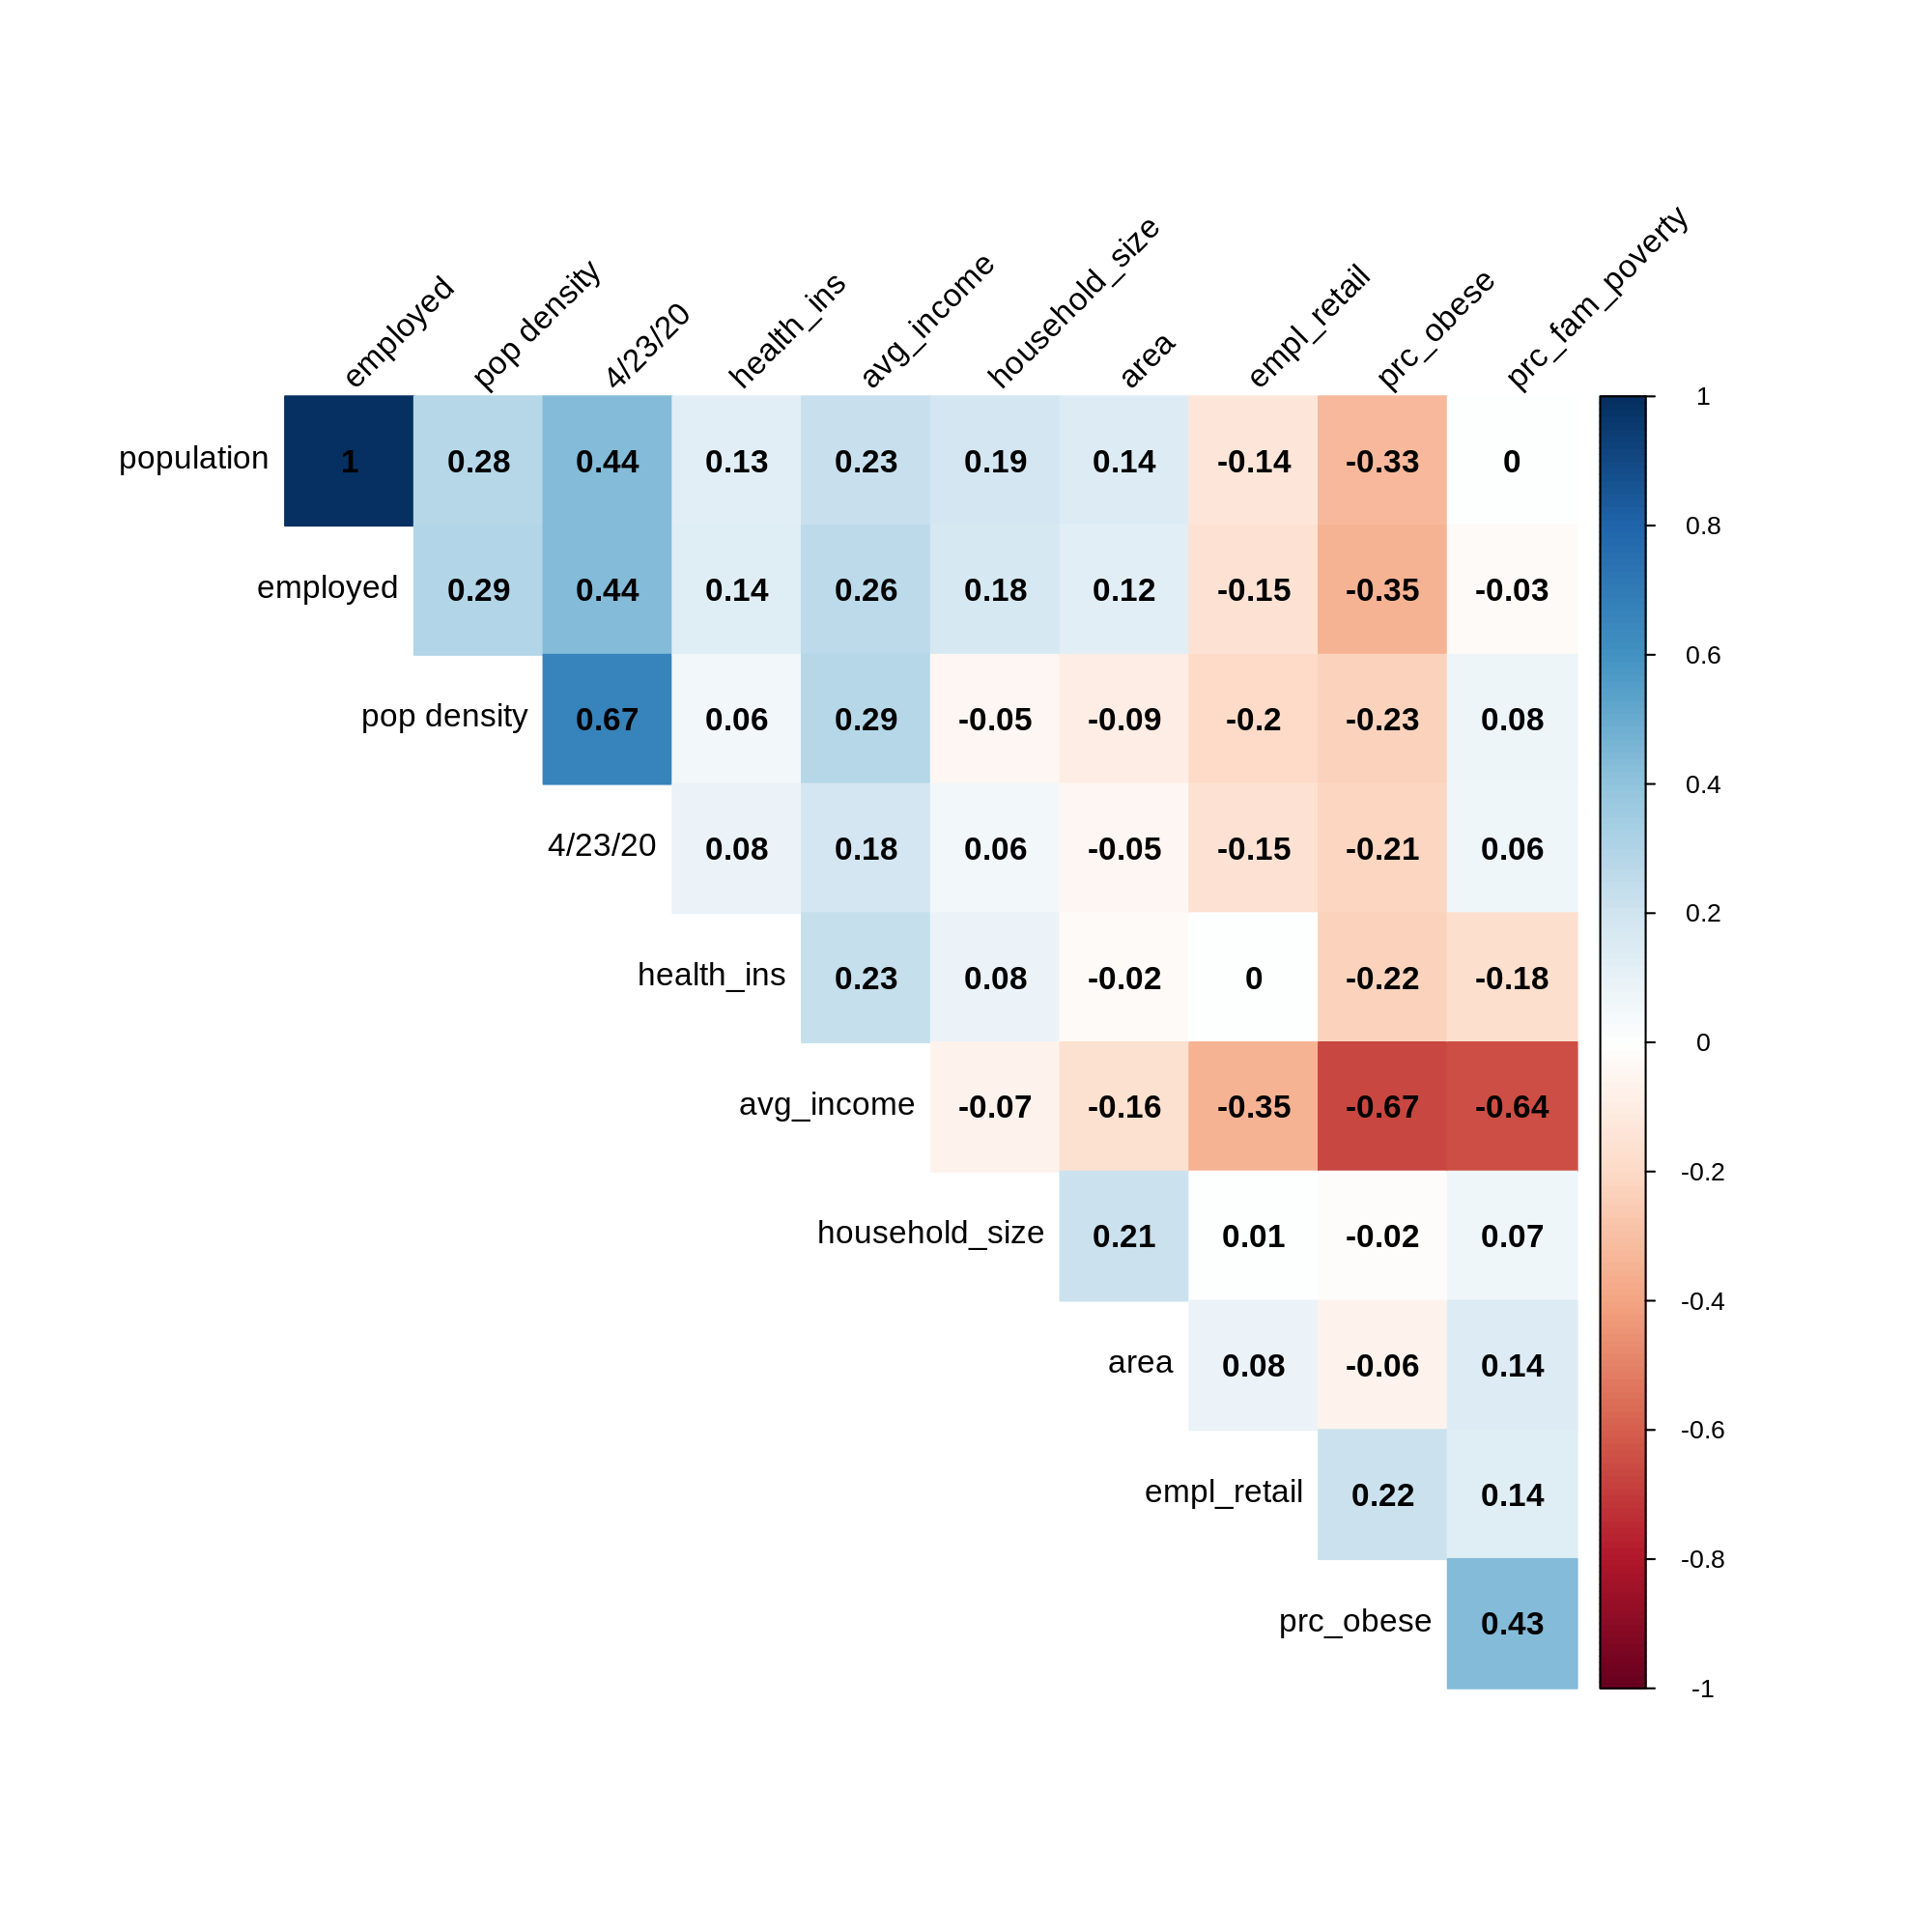

In [23]:
%%R -w 10 -h 10 --units in -r 200

corr = cor(data[c('household_size', "pop density", "area", "population", "health_ins",
       'empl_retail', 'employed', 'prc_obese', 'prc_fam_poverty', 'avg_income', "4/23/20")])
corrplot(corr, method="color", type="upper", order="hclust", 
         addCoef.col = "black", 
         tl.col="black", tl.srt=45, 
         diag=FALSE 
         )

# populations denisty correlates very much (positively) with # deaths

In [24]:
%%R

library(ggplot2)

In [25]:
data.columns.values

array(['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing',
       'empl_retail', 'empl_transp_utilities', 'employed',
       'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'population',
       'pop_65_plus', 'health_ins', 'county', 'state', 'FIPS', 'area',
       'prc_obese', 'incarcerated', 'domestic_passengers',
       'intl_passengers', '3/24/20', '4/1/20', '4/23/20', 'cases_march24',
       'cases_april1', 'cases_april23', 'days since 10+',
       'days since order', 'pop density'], dtype=object)

In [26]:
abbrev=data.drop("employed", axis=1, inplace=False) # in earlier version of notebook, dropped columns and renamed and would rather not retype all of the name in all subsequent cells

### Plots

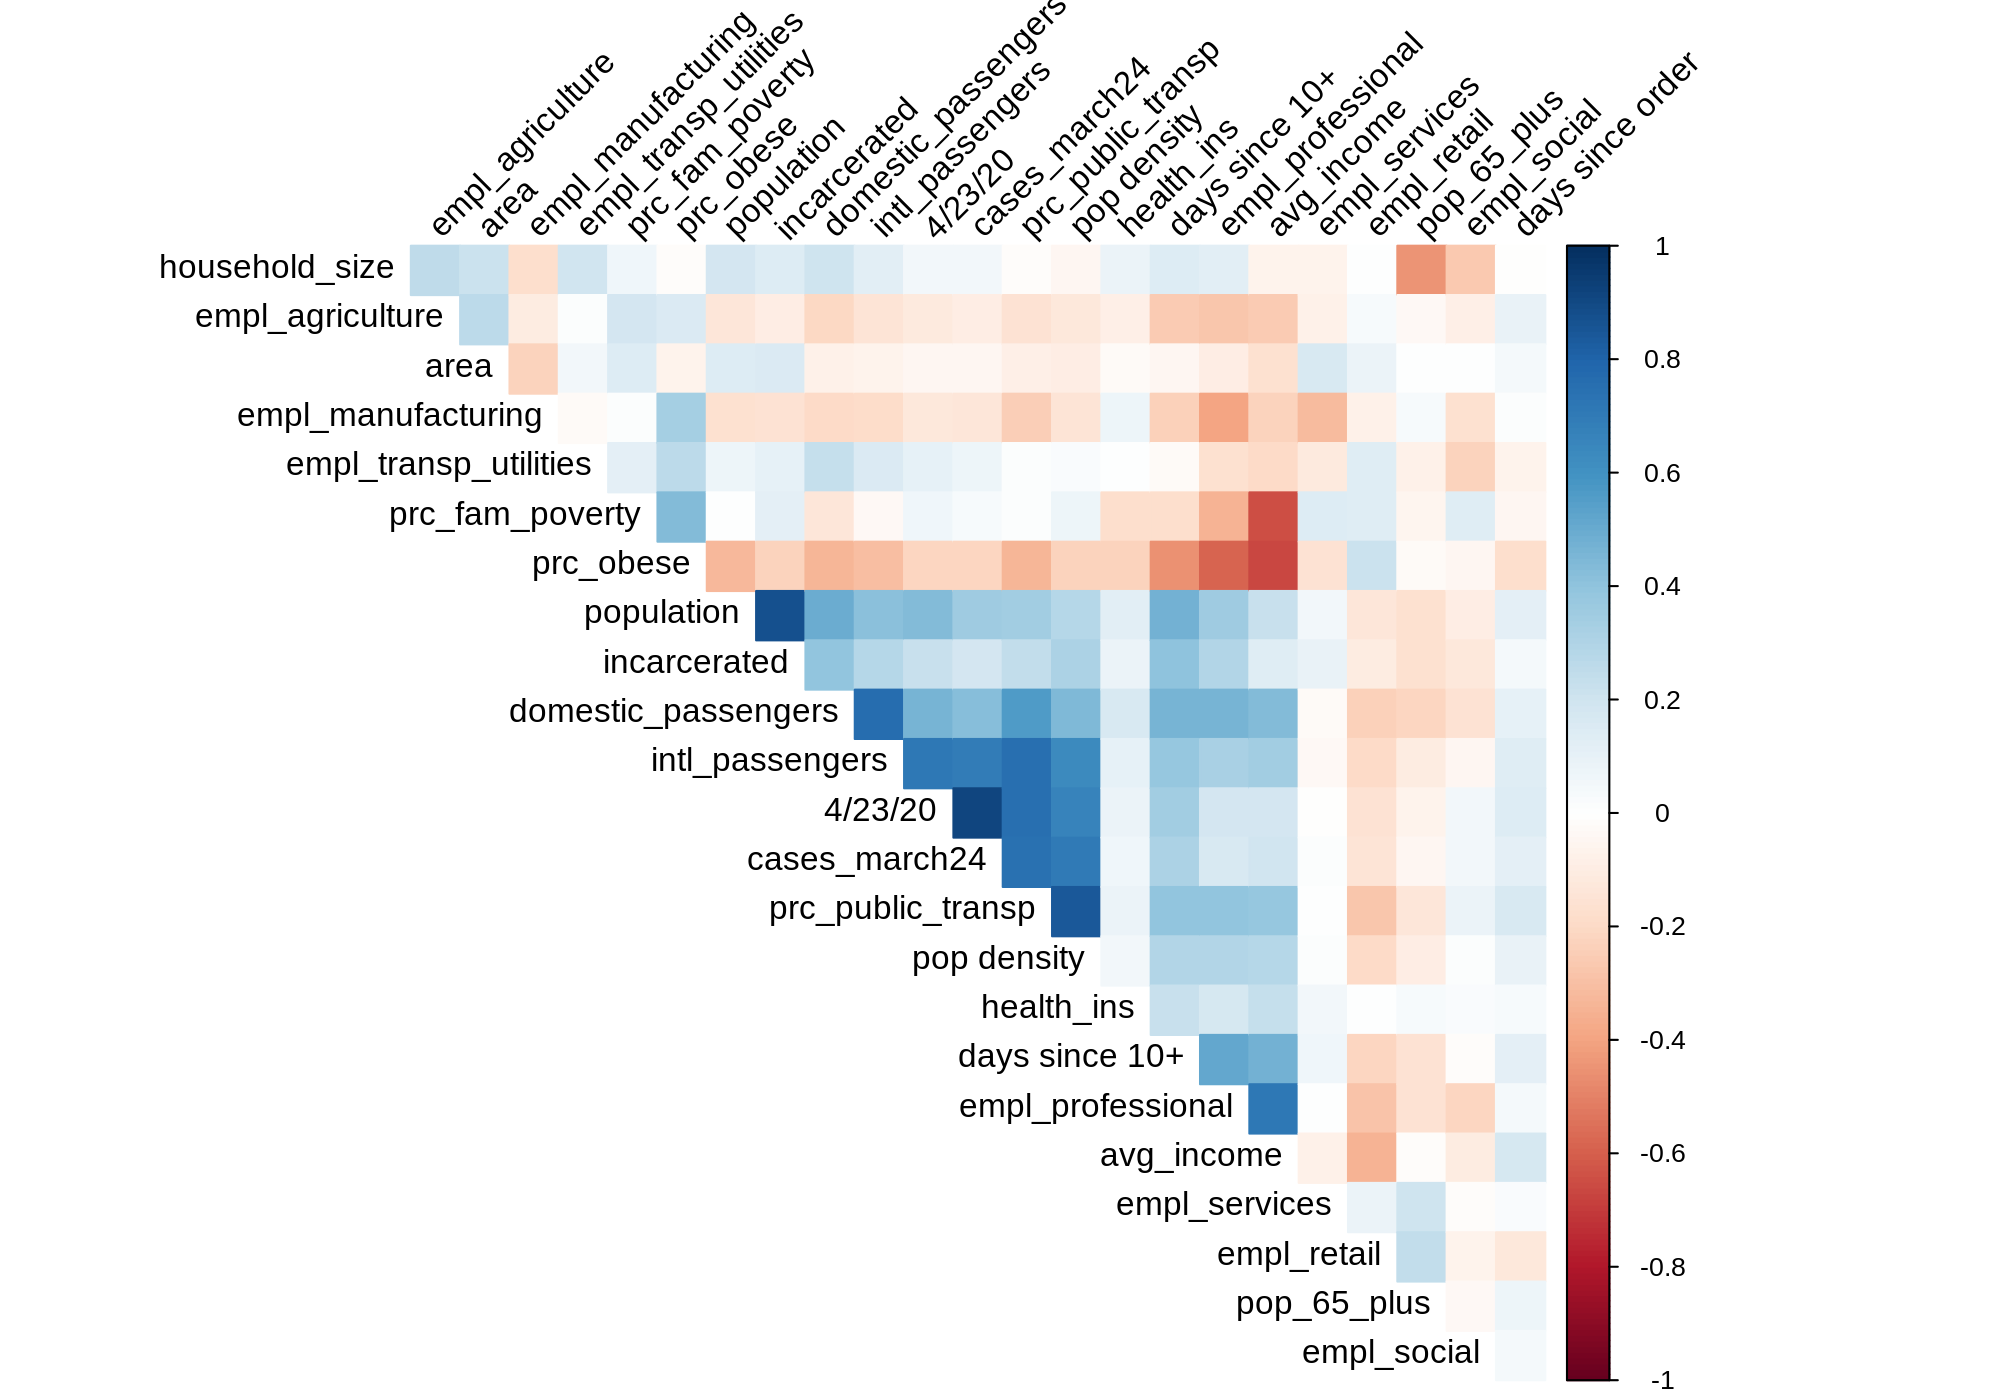

In [27]:
%%R -i abbrev -w 10 -h 7 --units in -r 200
library(corrplot)
corr = cor(abbrev[ c('household_size', 'empl_agriculture', 'empl_professional',
                     'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
                     'empl_transp_utilities', 'prc_fam_poverty', 'avg_income', 
                     'prc_public_transp', 'population','pop_65_plus', 'health_ins', 
                     'area', 'prc_obese', 'incarcerated', 'domestic_passengers', 
                     'intl_passengers', '4/23/20', 'cases_march24', 'days since 10+', 
                     'days since order', 'pop density')])
corrplot(corr, method="color", type="upper", order="hclust", 
         #addCoef.col = "black", # Add coefficient of correlation
         tl.col="black", tl.srt=45, #Text label color and rotation
         # hide correlation coefficient on the principal diagonal
         diag=FALSE 
         )

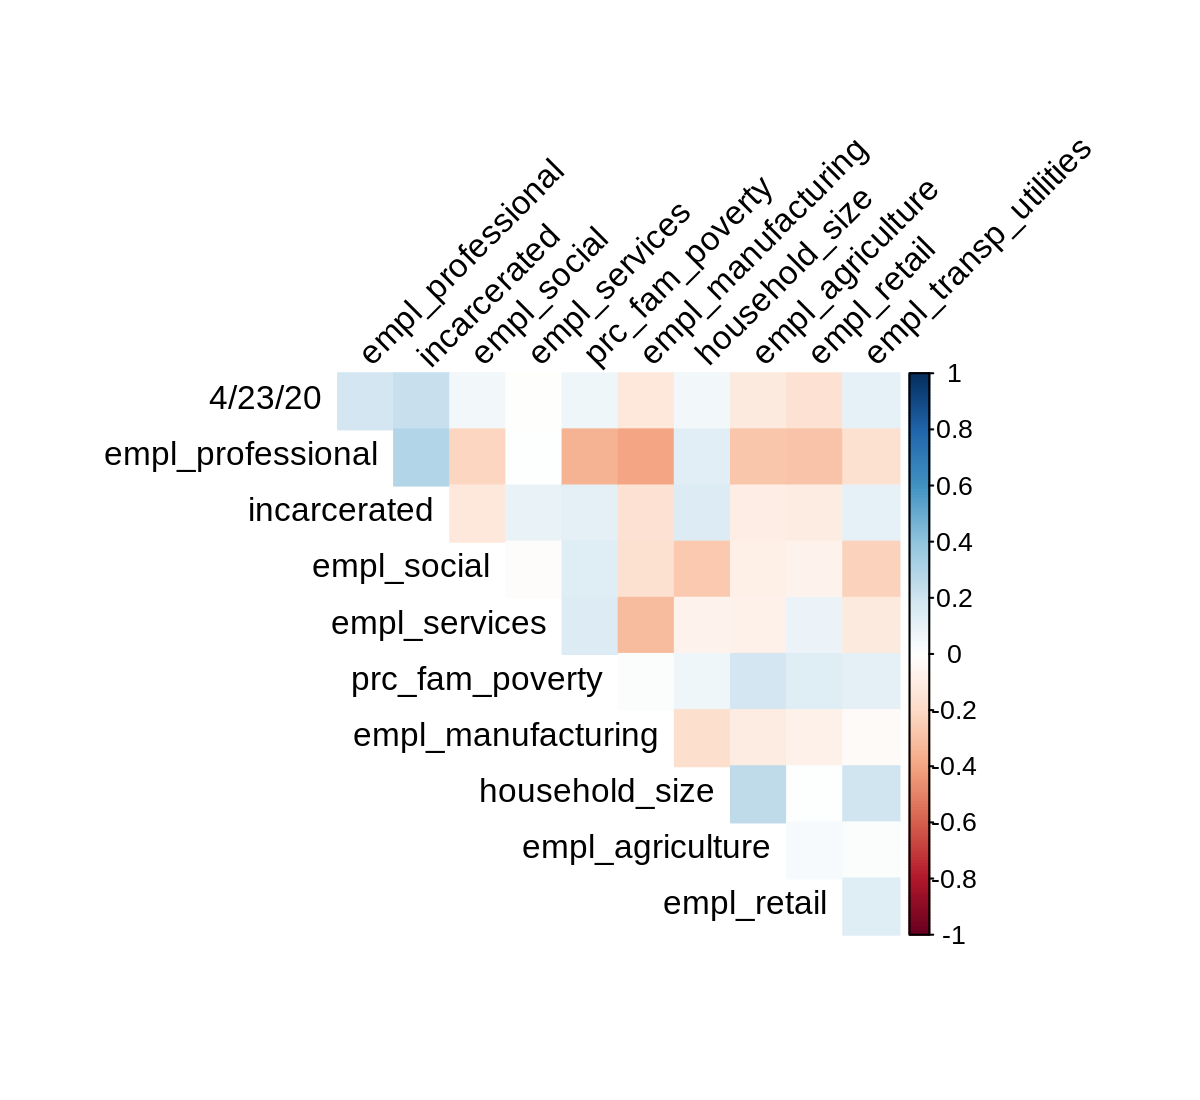

In [28]:
%%R -i abbrev -w 6 -h 5.5 --units in -r 200

corr = cor(abbrev[c('household_size', 'empl_agriculture', 'empl_professional', 
                    'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail', 
                    'empl_transp_utilities','prc_fam_poverty', 'incarcerated', '4/23/20')])
corrplot(corr, method="color", type="upper", order="hclust",  tl.col="black", tl.srt=45,diag=FALSE )


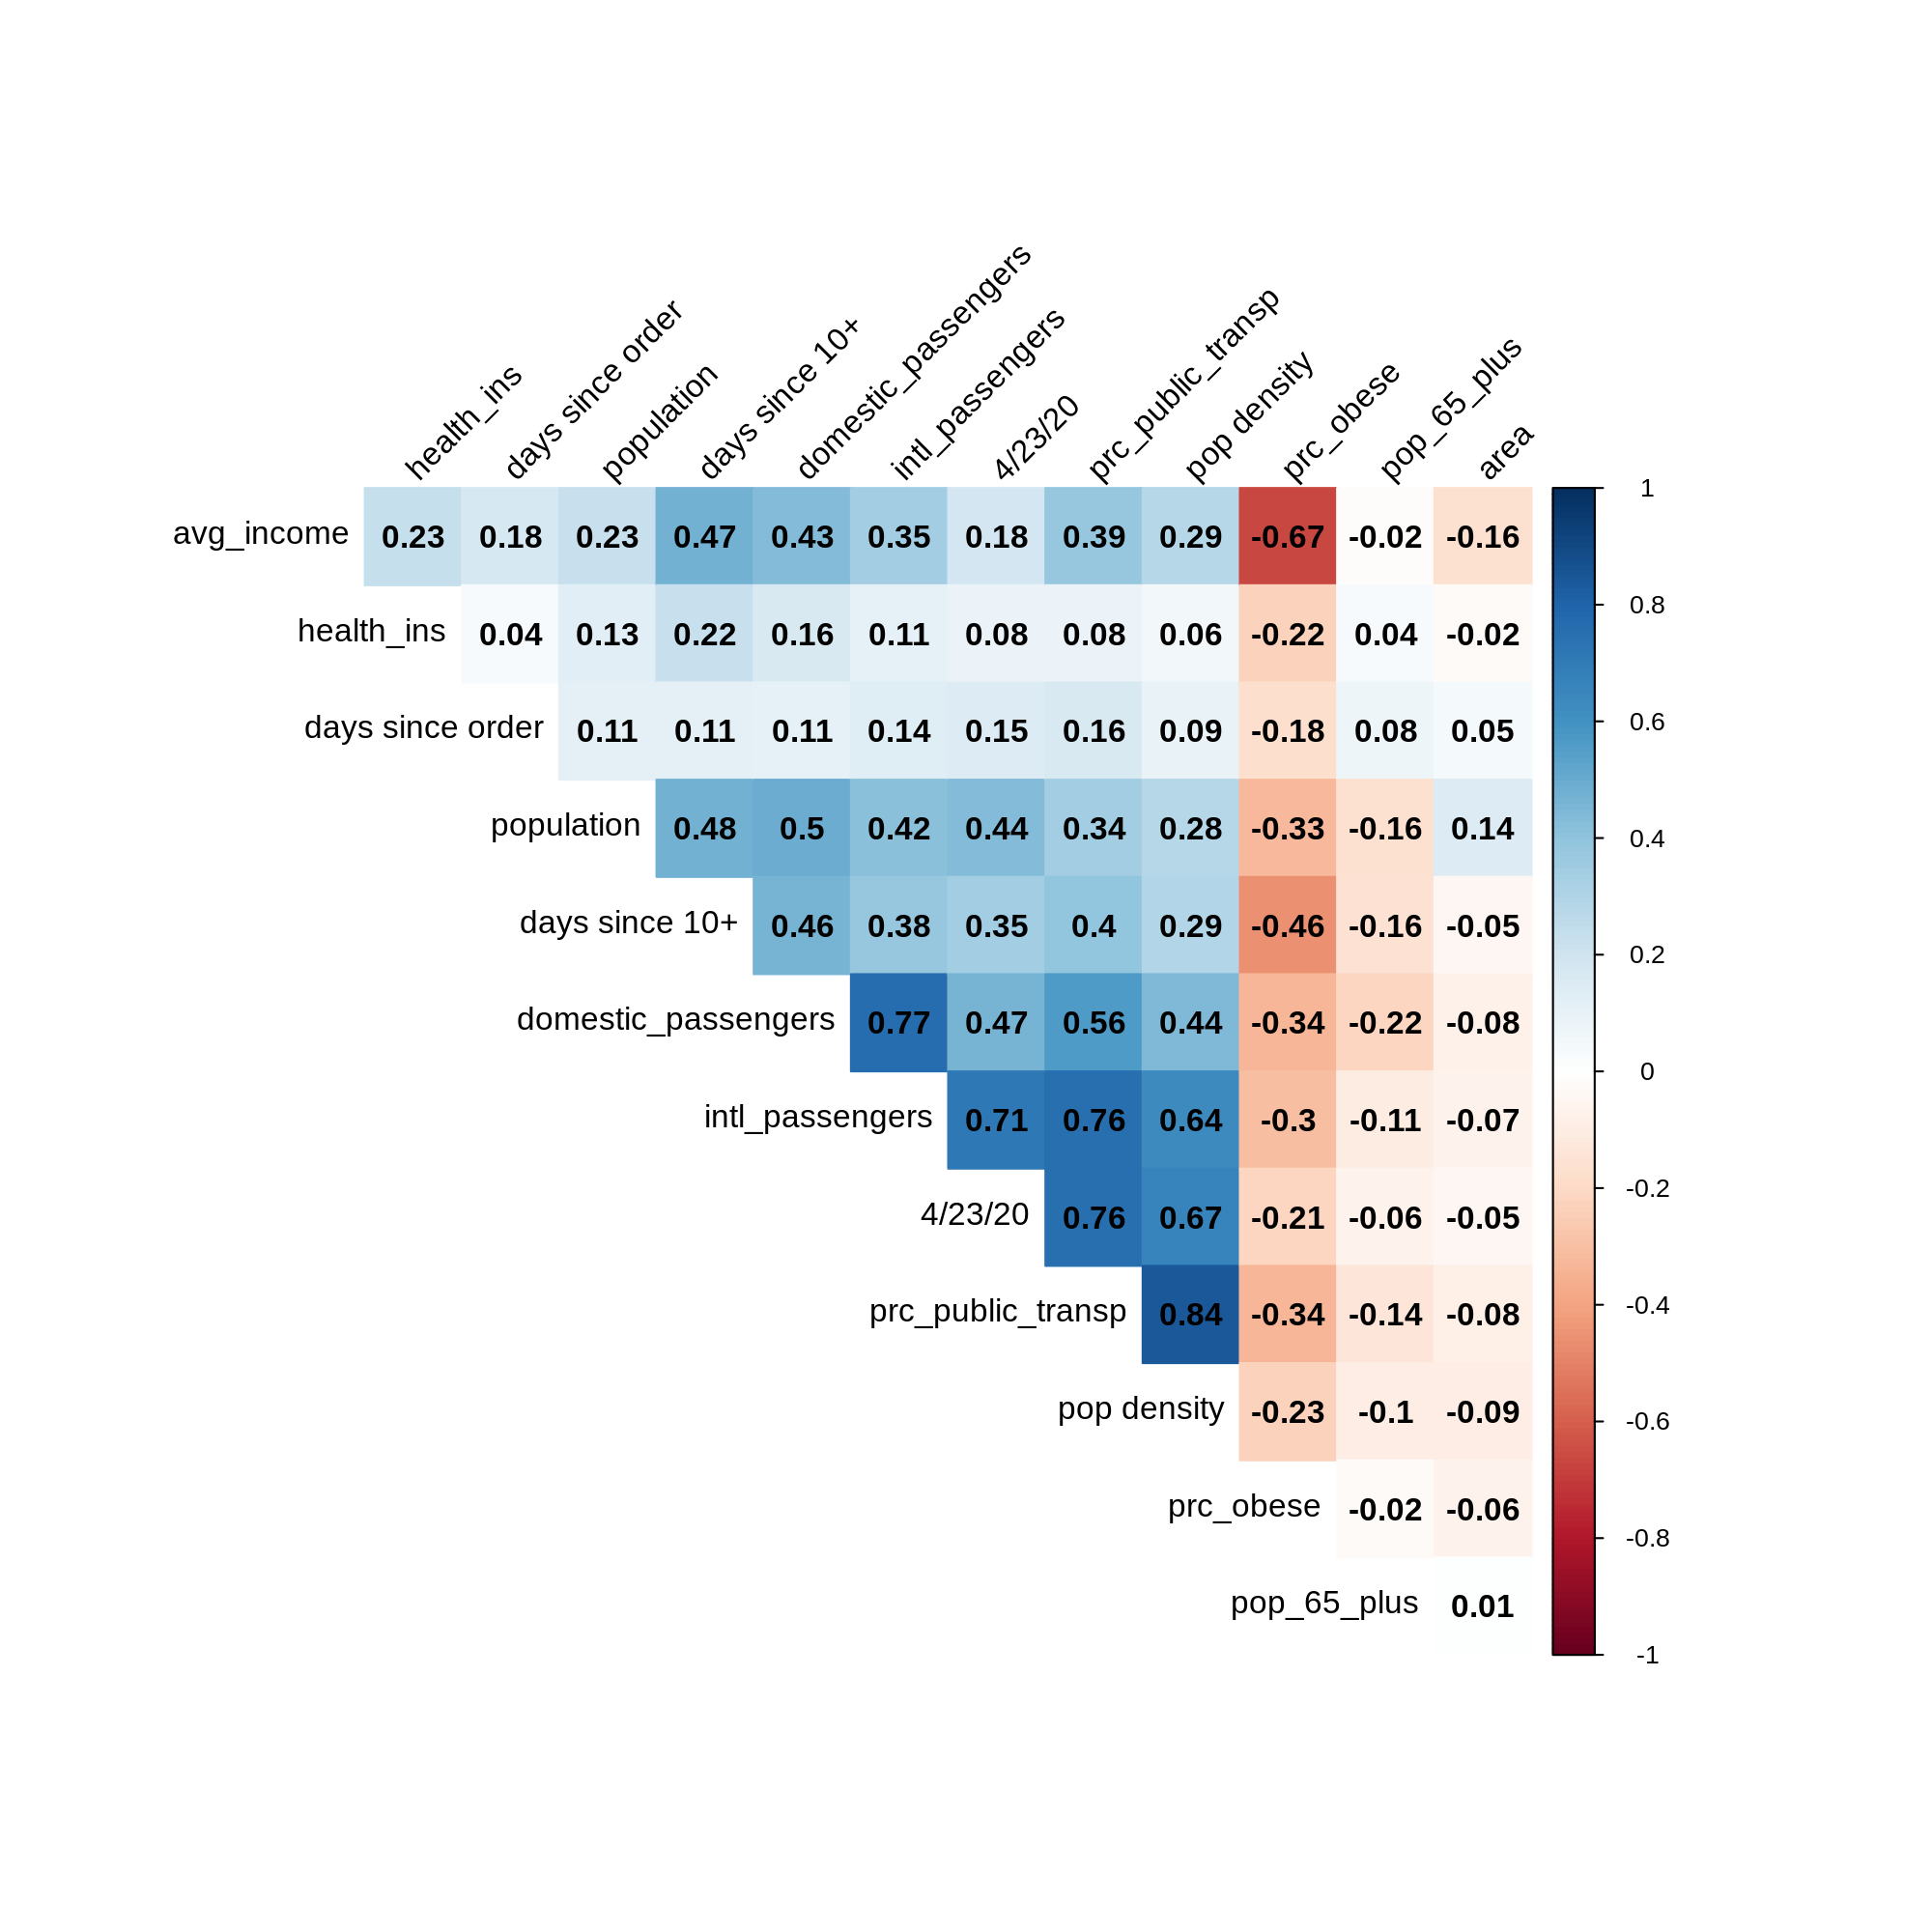

In [29]:
%%R -i abbrev -w 10 -h 10 --units in -r 200

corr = cor(abbrev[ c('avg_income', 'prc_public_transp', 'population','pop_65_plus', 'health_ins', 'area',
       'domestic_passengers', 'intl_passengers', 'prc_obese', '4/23/20', 'days since 10+',
        'days since order', 'pop density')])
corrplot(corr, method="color", type="upper", order="hclust", 
         addCoef.col = "black", tl.col="black", tl.srt=45,diag=FALSE )

In [30]:
abbrev.columns

Index(['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
       'empl_transp_utilities', 'prc_fam_poverty', 'avg_income',
       'prc_public_transp', 'population', 'pop_65_plus', 'health_ins',
       'county', 'state', 'FIPS', 'area', 'prc_obese', 'incarcerated',
       'domestic_passengers', 'intl_passengers', '3/24/20', '4/1/20',
       '4/23/20', 'cases_march24', 'cases_april1', 'cases_april23',
       'days since 10+', 'days since order', 'pop density'],
      dtype='object')

In [32]:
# rename columns in abbrev
abbrev.columns = ['household_size', 'empl_agriculture', 'empl_professional',
                  'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
                  'empl_transp_utilities', 'prc_fam_poverty', 'avg_income', 
                  'prc_public_transp', 'population', 'pop_65_plus', 'health_ins', 
                  'county', 'state', 'FIPS', 'area', 'prc_obese', 'incarcerated',
                  'domestic_passengers', 'intl_passengers', "deaths_march24", 
                  "deaths_april1", "deaths", "cases_march24", "cases_april1",
                  "cases_april23", "ten_plus", "order", "density"]

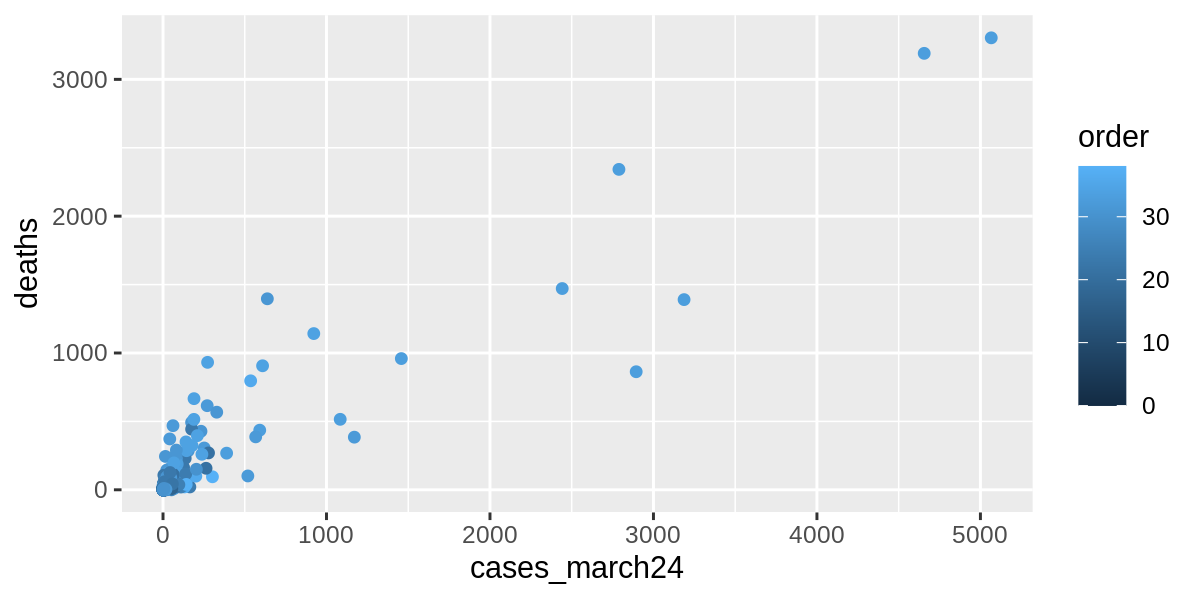

In [33]:
%%R -i abbrev -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(cases_march24, deaths, color=order))

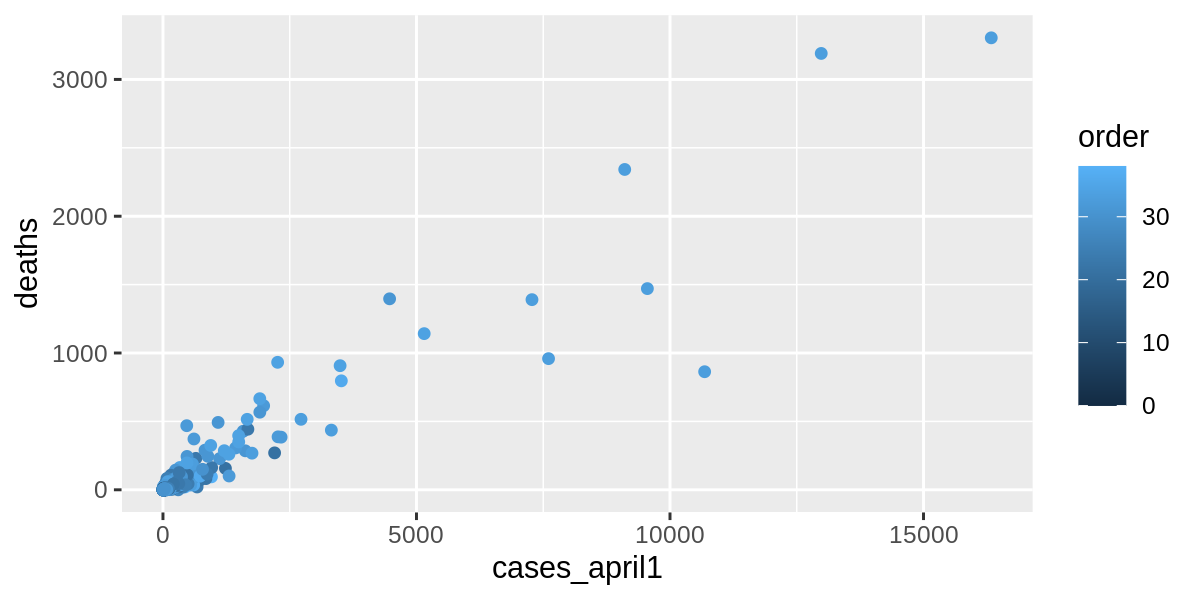

In [34]:
%%R -i abbrev -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(cases_april1, deaths, color=order))

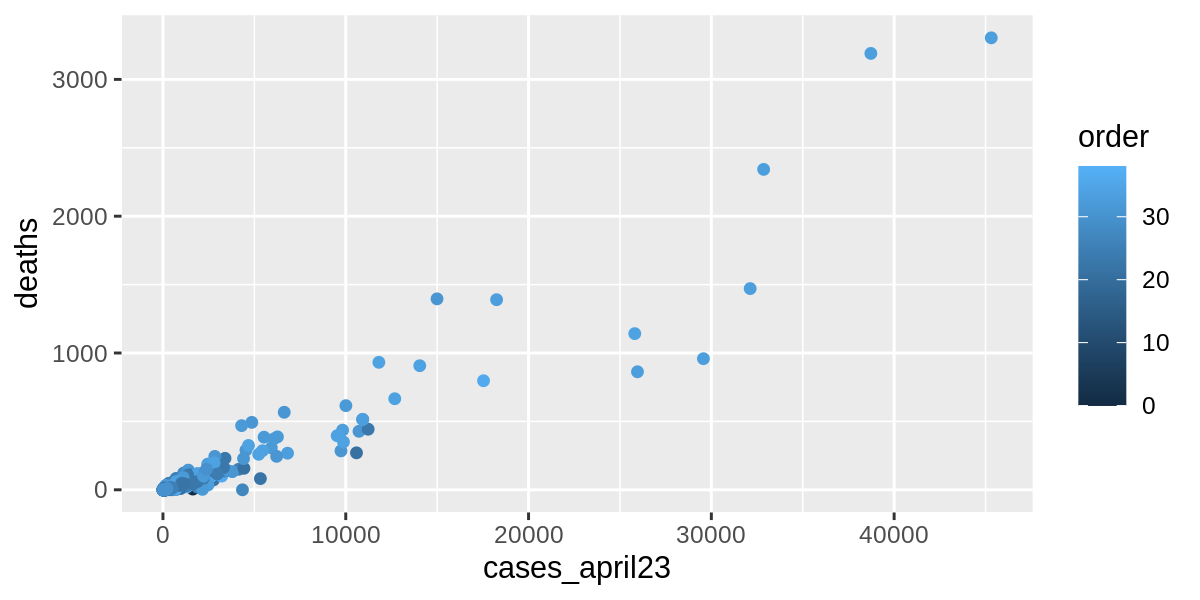

In [35]:
%%R -i abbrev -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(cases_april23, deaths, color=order))

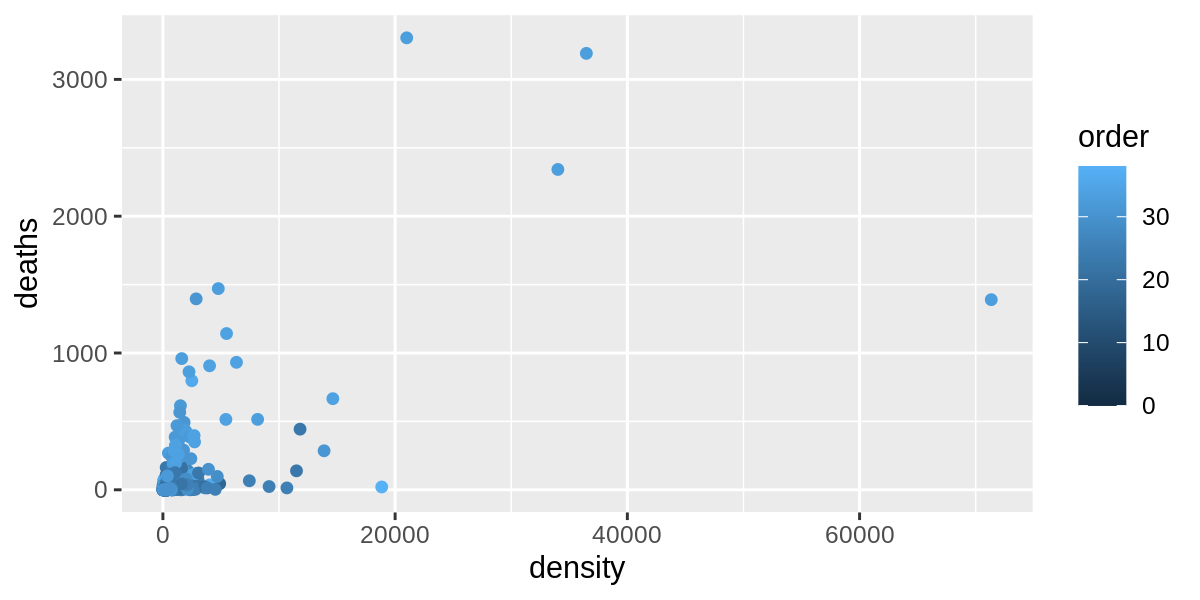

In [36]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(density, deaths, color=order))

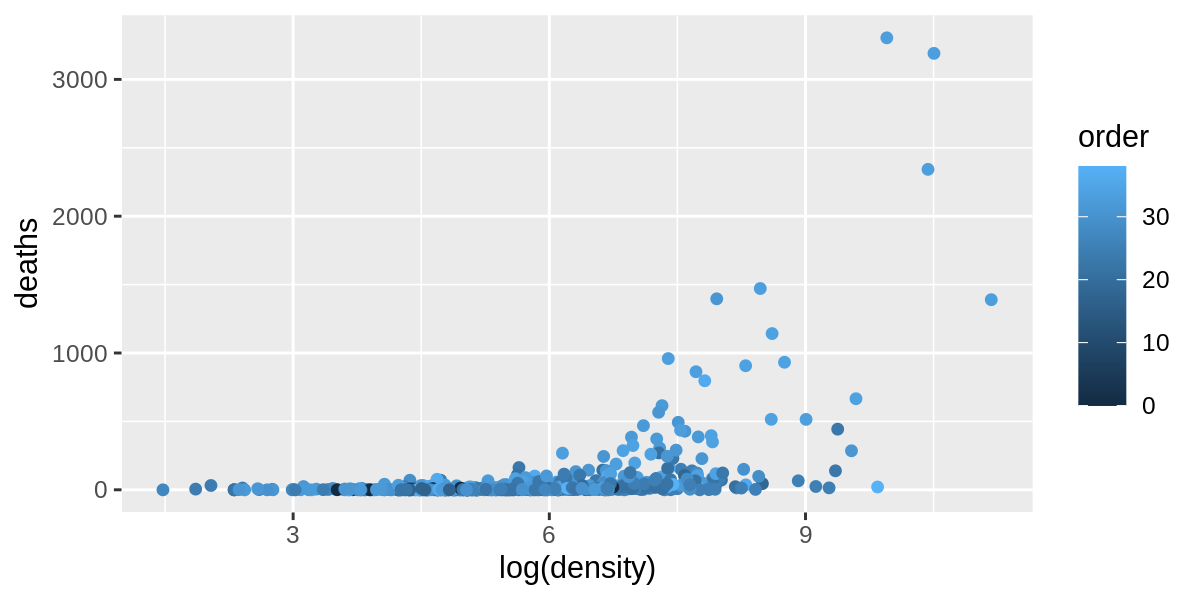

In [37]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(log(density), deaths, color=order))

In [38]:
abbrev.loc[abbrev.deaths == 0, "deaths"] = 0.000001

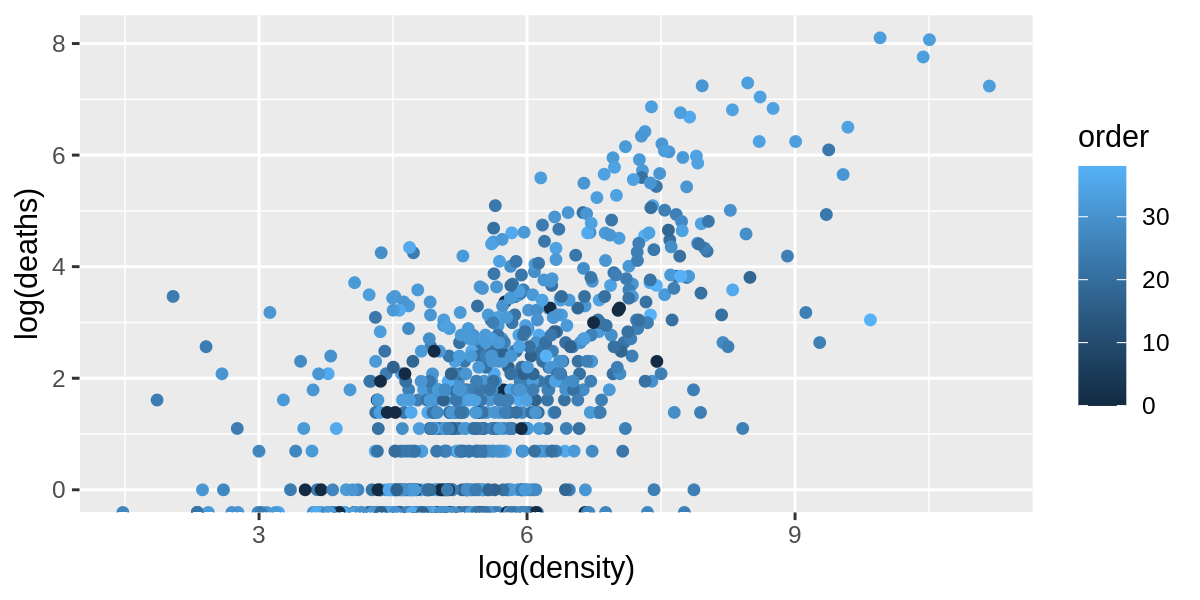

In [39]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(log(density), log(deaths), color=order))

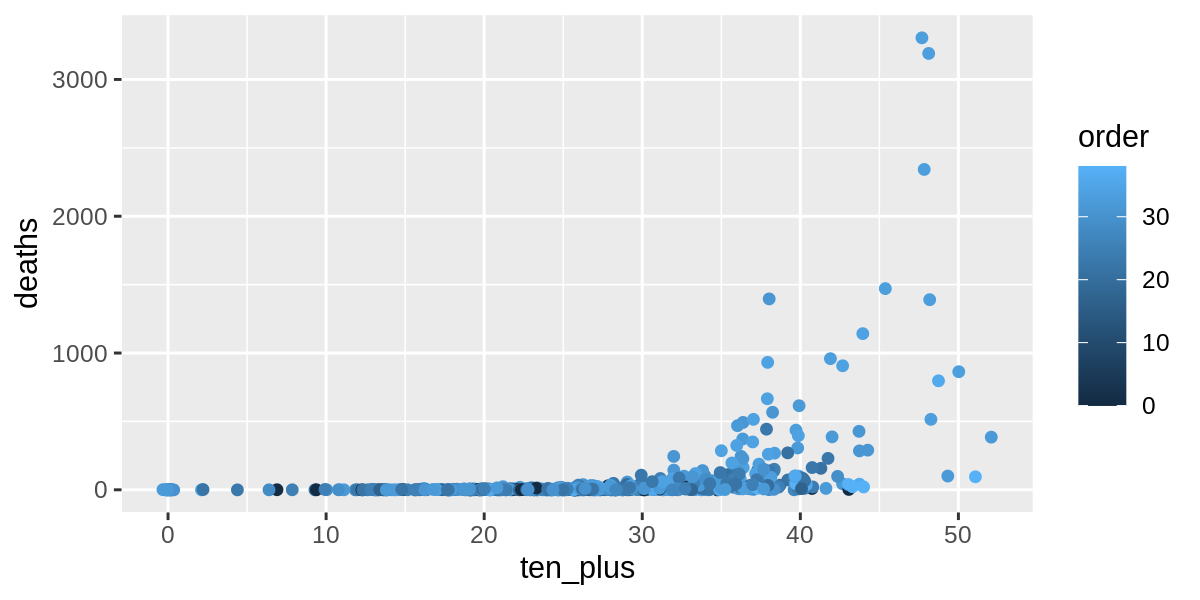

In [40]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(ten_plus, deaths, color=order))

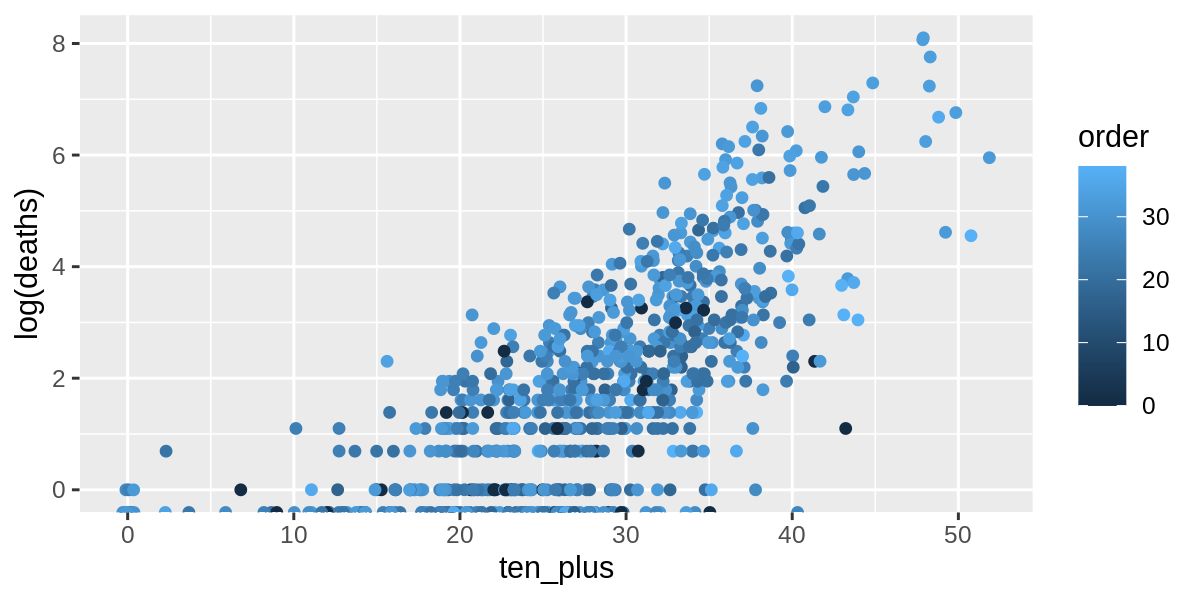

In [41]:
%%R -w 6 -h 3 --units in -r 200

# without NYC
ggplot(abbrev) + geom_jitter(aes(ten_plus, log(deaths), color=order))

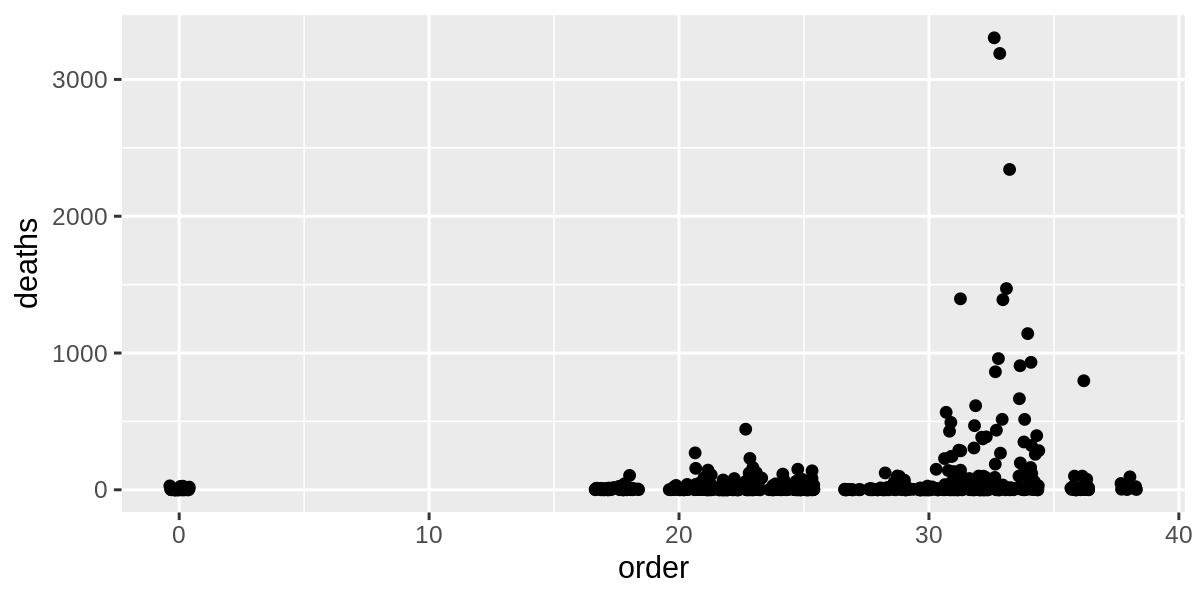

In [42]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(order, deaths))

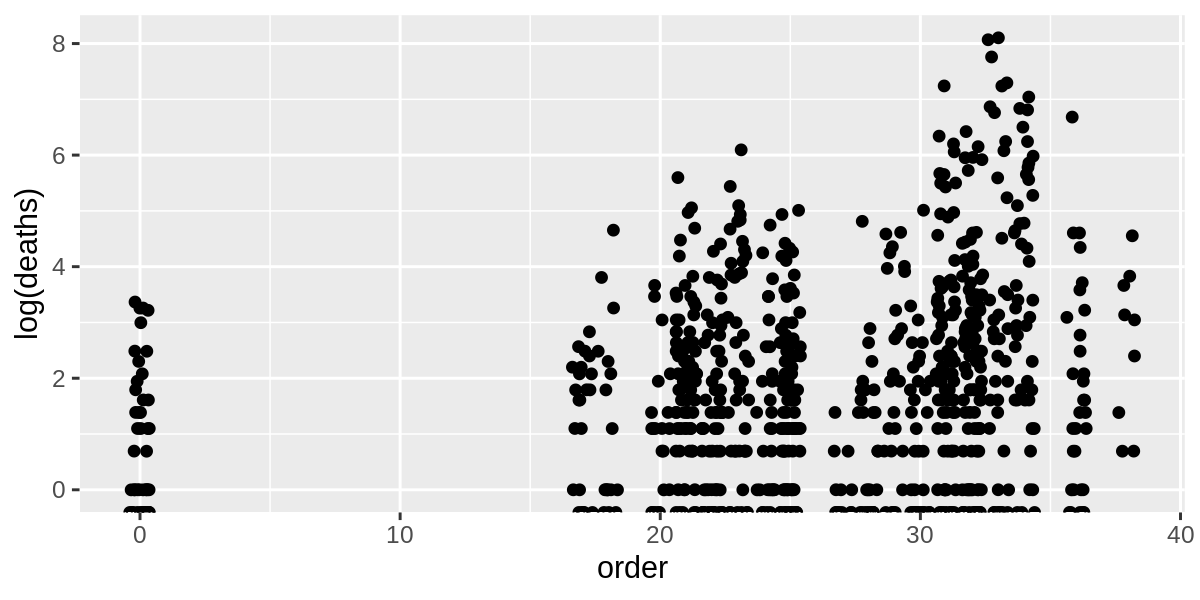

In [43]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(order, log(deaths)))

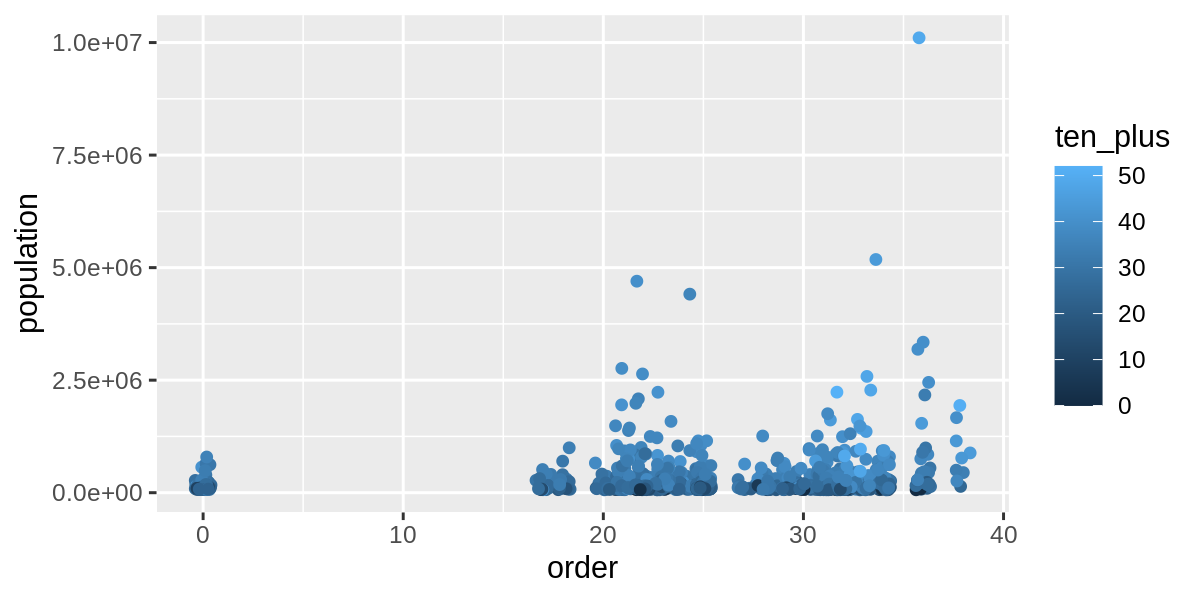

In [44]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(order, population, color=ten_plus))
# did more populous places enact shelter in place sooner?  did those with earlier 10+ confirmed cases?

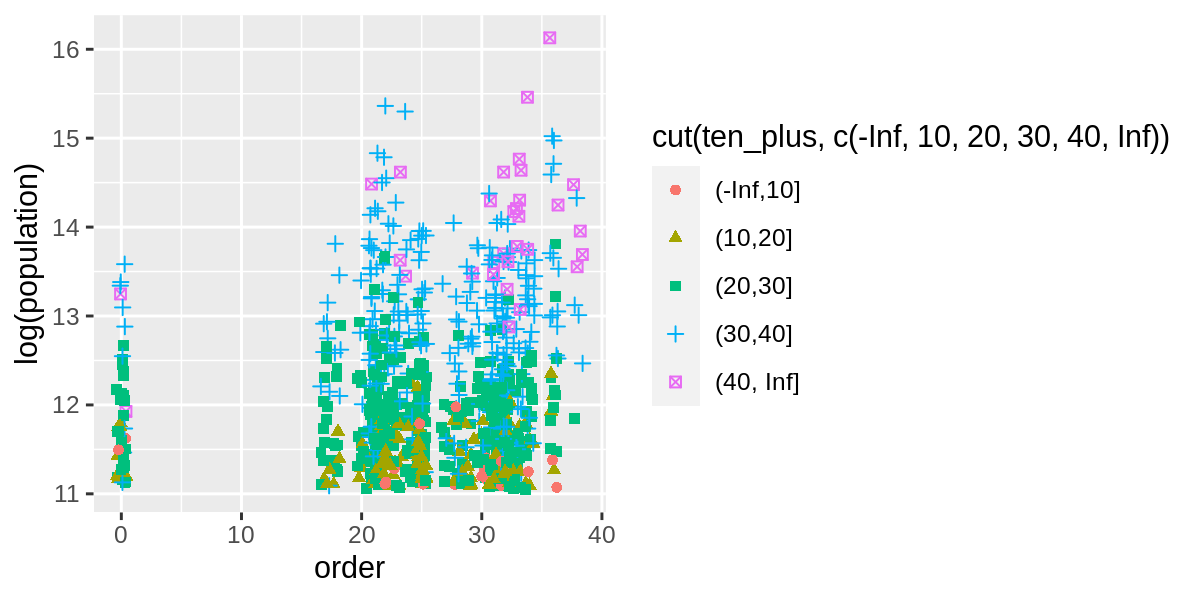

In [45]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(order, log(population), shape=cut(ten_plus, c(-Inf, 10, 20, 30, 40, Inf)), 
                                color=cut(ten_plus, c(-Inf, 10, 20, 30, 40, Inf))))
# did more populous places enact shelter in place sooner?  It does look like places with larger populations had earlier cases, but not all enacted shelter-in-place orders early

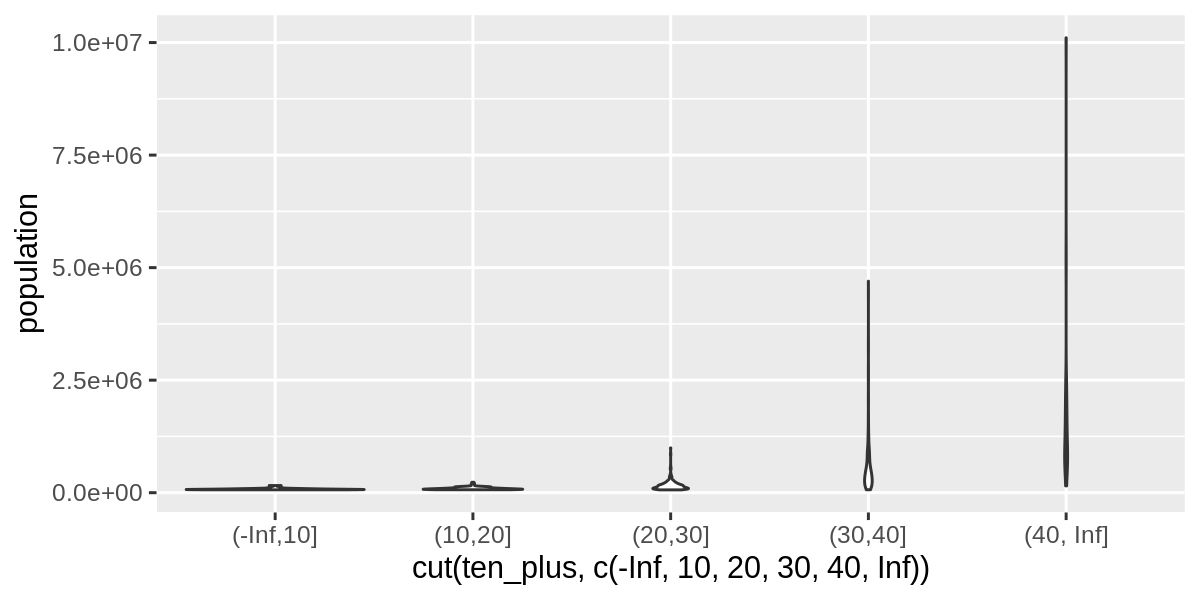

In [46]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) +  geom_violin(aes(cut(ten_plus, c(-Inf, 10, 20, 30, 40, Inf)), population))

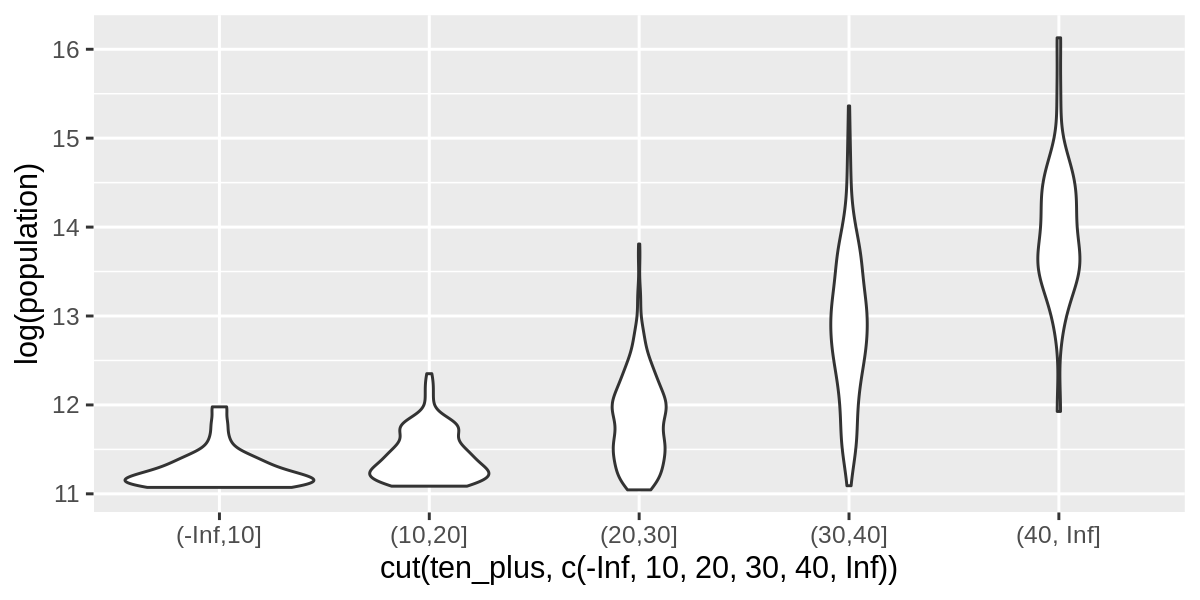

In [47]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) +  geom_violin(aes(cut(ten_plus, c(-Inf, 10, 20, 30, 40, Inf)), log(population)))
# there is some variation within groups, but in general it seems like larger populations saw their
# first 10+ confirmed cases longer (more days) ago

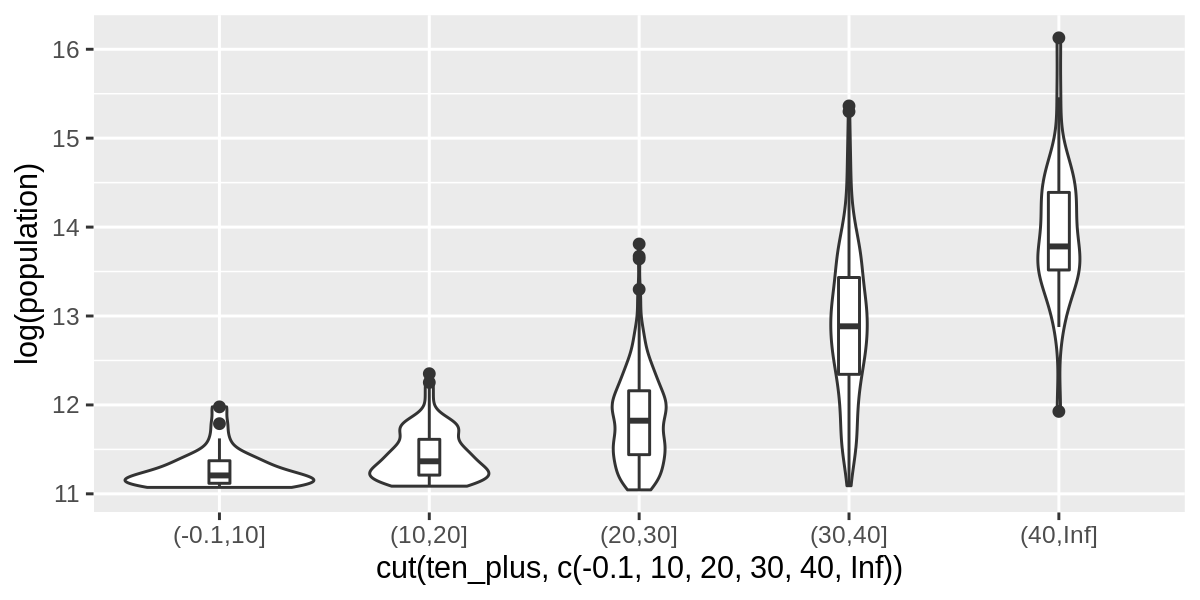

In [48]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-0.1, 10, 20, 30, 40, Inf)), log(population))) +  
geom_violin() + 
geom_boxplot(width=0.1)

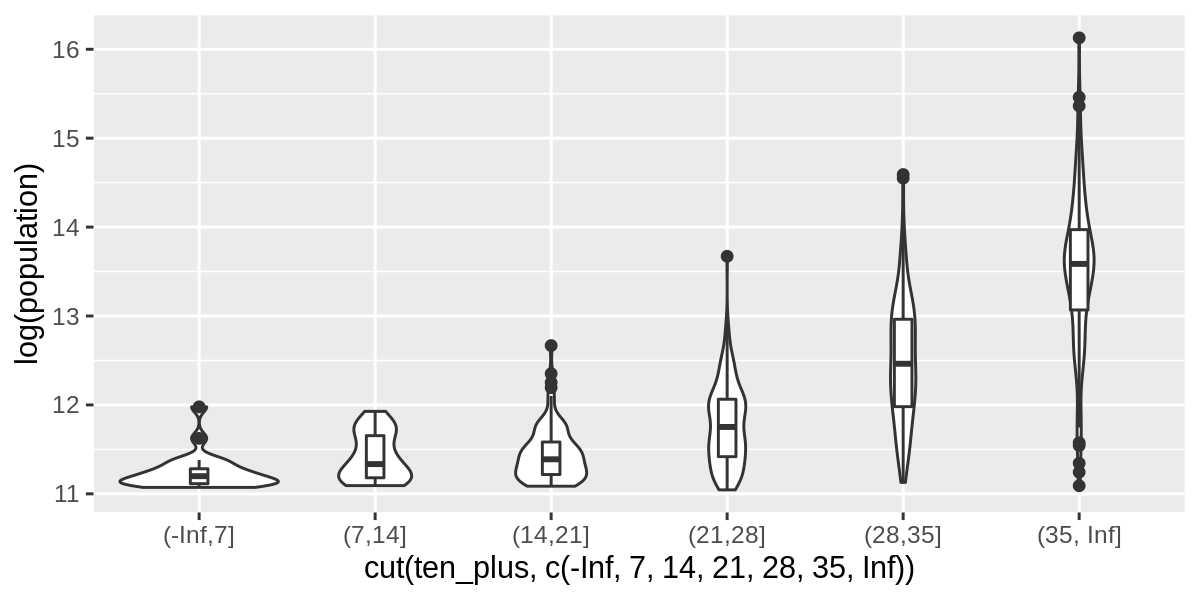

In [49]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 7, 14, 21, 28, 35, Inf)), log(population))) +  
geom_violin() + 
geom_boxplot(width=0.1)

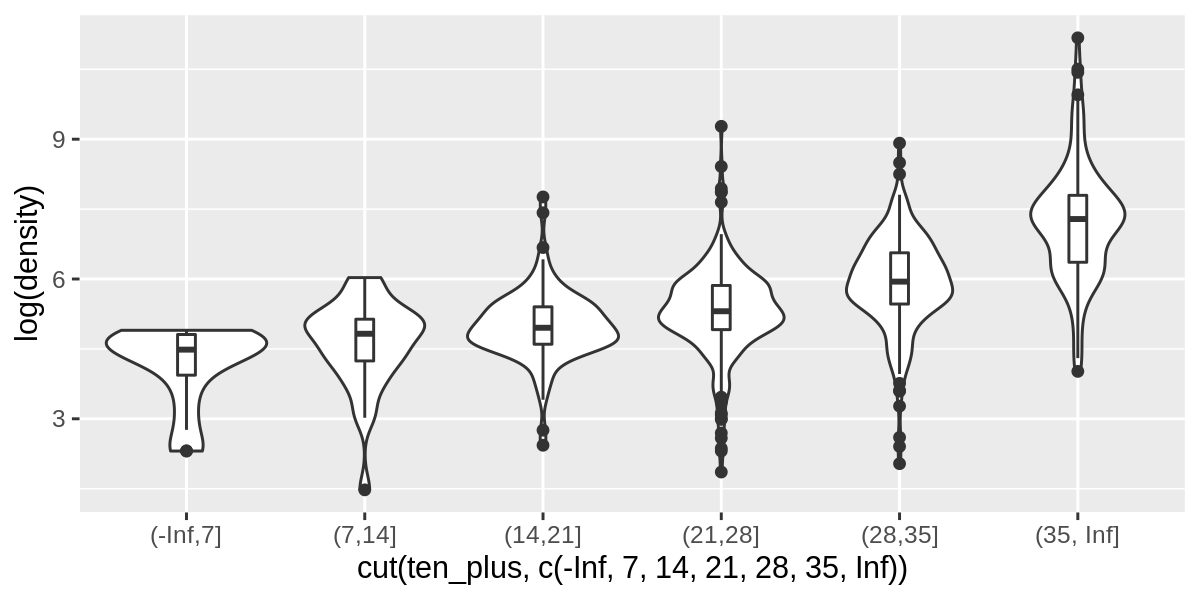

In [50]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 7, 14, 21, 28, 35, Inf)), log(density))) +  
geom_violin() + 
geom_boxplot(width=0.1)

In [51]:
abbrev["domestic_passengers"].describe()

count    8.3e+02
mean     4.2e+06
std      9.3e+06
min      0.0e+00
25%      0.0e+00
50%      3.0e+05
75%      2.2e+06
max      4.6e+07
Name: domestic_passengers, dtype: float64

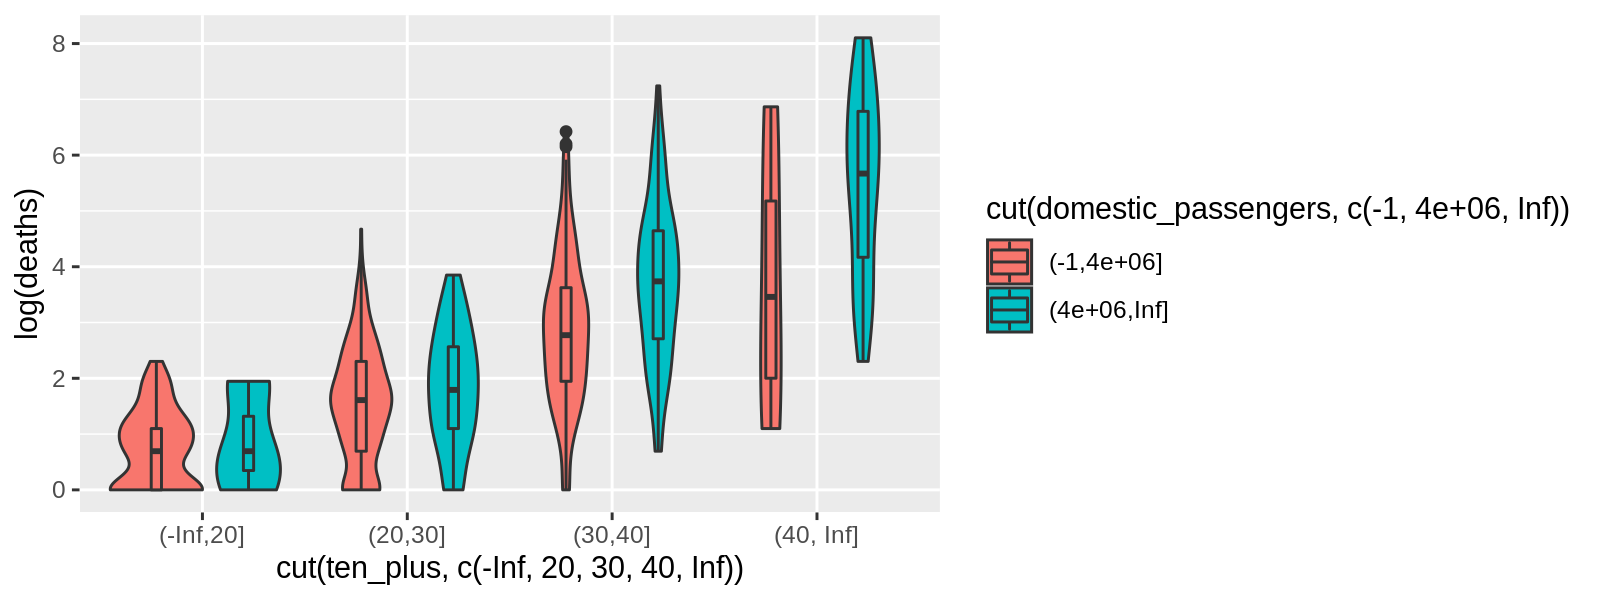

In [53]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 20, 30, 40, Inf)), log(deaths), fill=cut(domestic_passengers, c(-1, 4000000, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

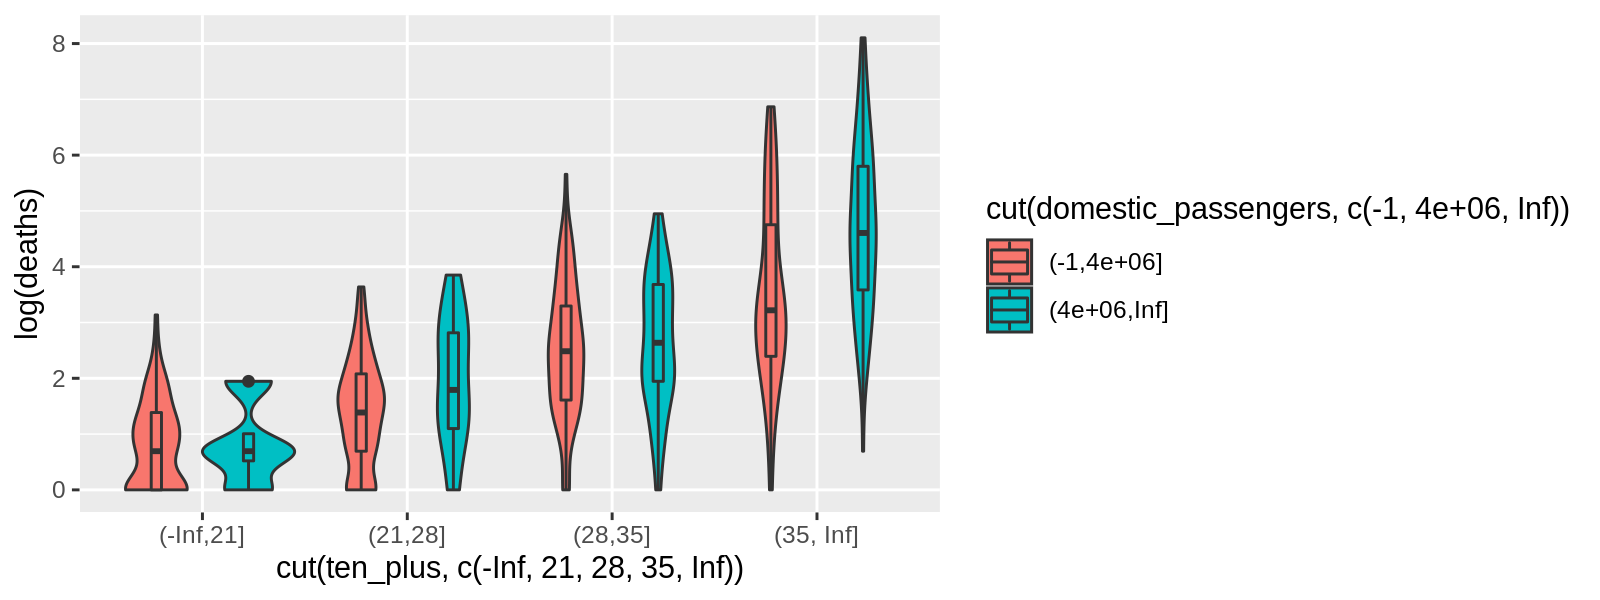

In [55]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 21, 28, 35, Inf)), log(deaths), fill=cut(domestic_passengers, c(-1, 4000000, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [56]:
abbrev["intl_passengers"].describe()

count    8.3e+02
mean     7.5e+05
std      2.9e+06
min      0.0e+00
25%      0.0e+00
50%      0.0e+00
75%      0.0e+00
max      2.4e+07
Name: intl_passengers, dtype: float64

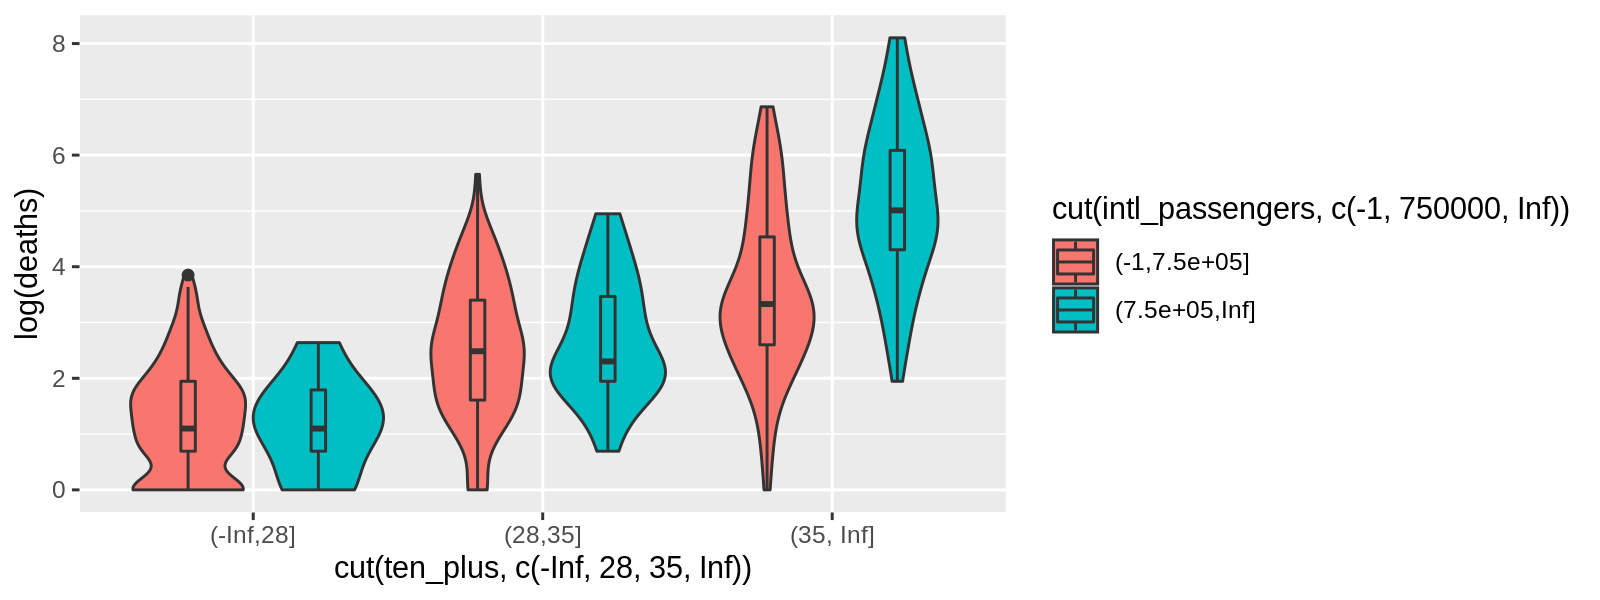

In [59]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 28, 35, Inf)), log(deaths), fill=cut(intl_passengers, c(-1, 750000, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [60]:
abbrev.columns

Index(['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
       'empl_transp_utilities', 'prc_fam_poverty', 'avg_income',
       'prc_public_transp', 'population', 'pop_65_plus', 'health_ins',
       'county', 'state', 'FIPS', 'area', 'prc_obese', 'incarcerated',
       'domestic_passengers', 'intl_passengers', 'deaths_march24',
       'deaths_april1', 'deaths', 'cases_march24', 'cases_april1',
       'cases_april23', 'ten_plus', 'order', 'density'],
      dtype='object')

In [61]:
abbrev.prc_obese.describe()

count    827.0
mean      31.1
std        5.3
min       14.2
25%       27.6
50%       31.5
75%       34.8
max       47.7
Name: prc_obese, dtype: float64

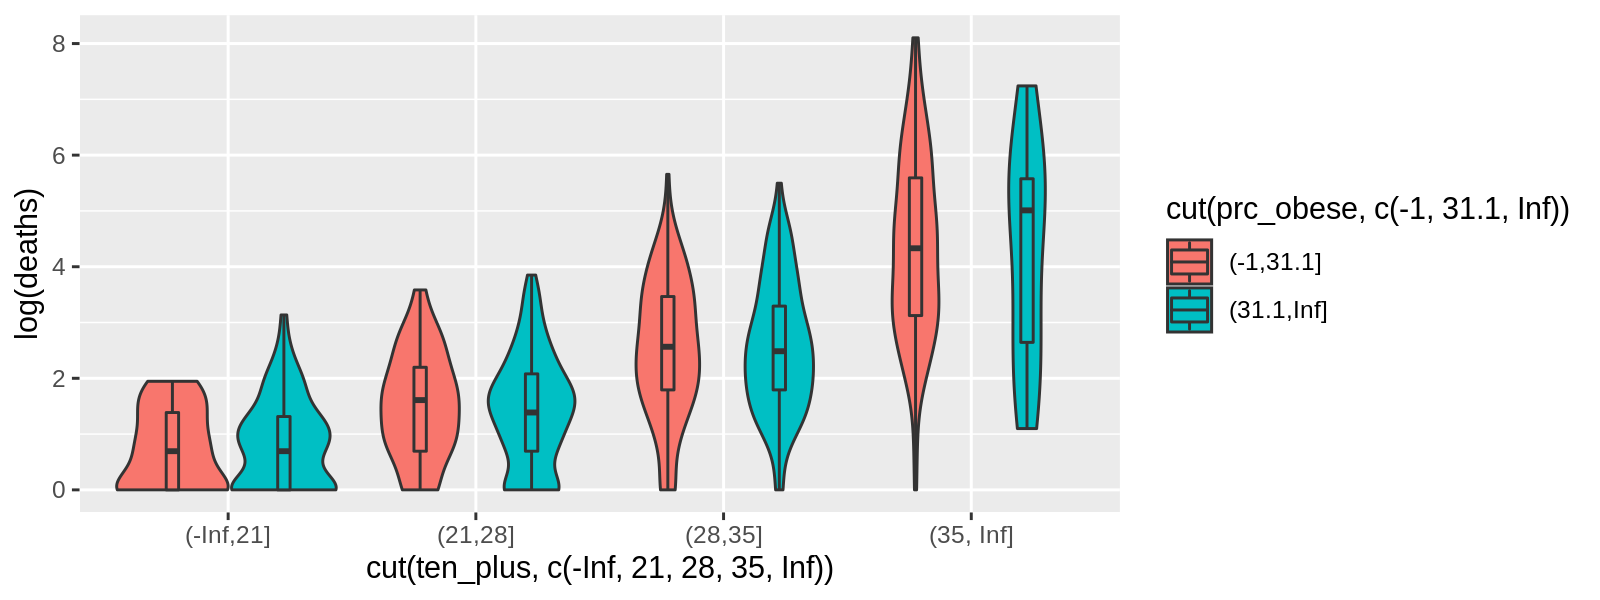

In [62]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 21, 28, 35, Inf)), log(deaths), fill=cut(prc_obese, c(-1, 31.1, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [63]:
abbrev.incarcerated.describe()

count      827.0
mean       690.3
std       1126.7
min          0.0
25%        210.5
50%        383.0
75%        743.5
max      17367.0
Name: incarcerated, dtype: float64

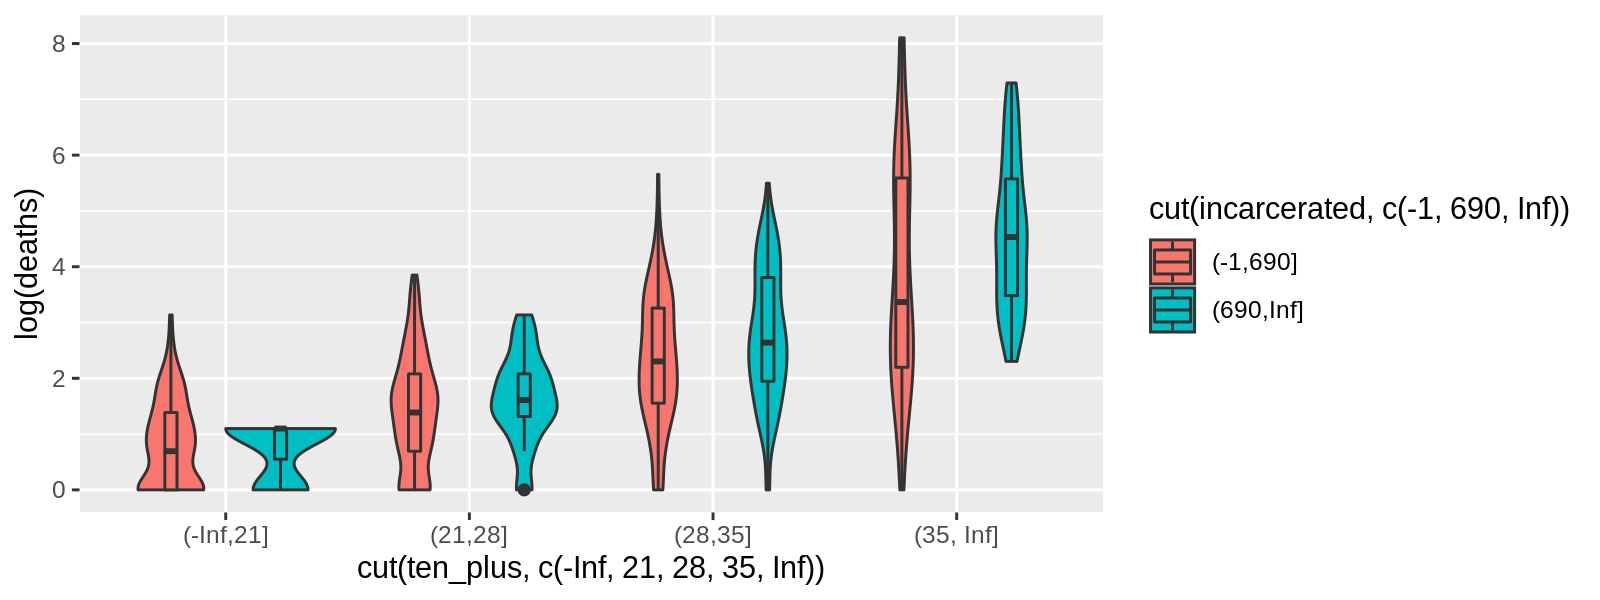

In [64]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 21, 28, 35, Inf)), log(deaths), fill=cut(incarcerated, c(-1, 690, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [65]:
abbrev.prc_public_transp.describe()

count    827.0
mean       2.2
std        5.5
min        0.0
25%        0.3
50%        0.7
75%        1.8
max       60.7
Name: prc_public_transp, dtype: float64

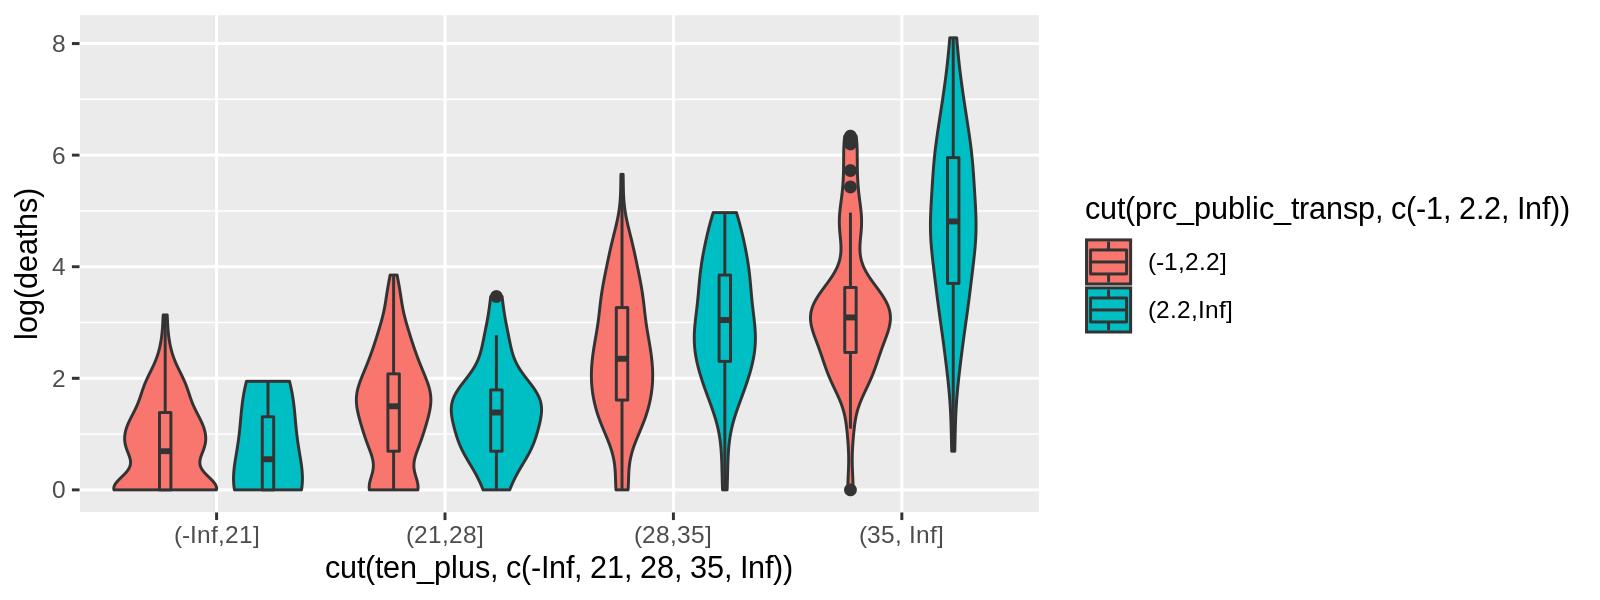

In [66]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 21, 28, 35, Inf)), log(deaths), fill=cut(prc_public_transp, c(-1, 2.2, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [67]:
abbrev.prc_fam_poverty.describe()

count    827.0
mean       9.0
std        4.2
min        1.3
25%        5.9
50%        8.4
75%       11.4
max       29.4
Name: prc_fam_poverty, dtype: float64

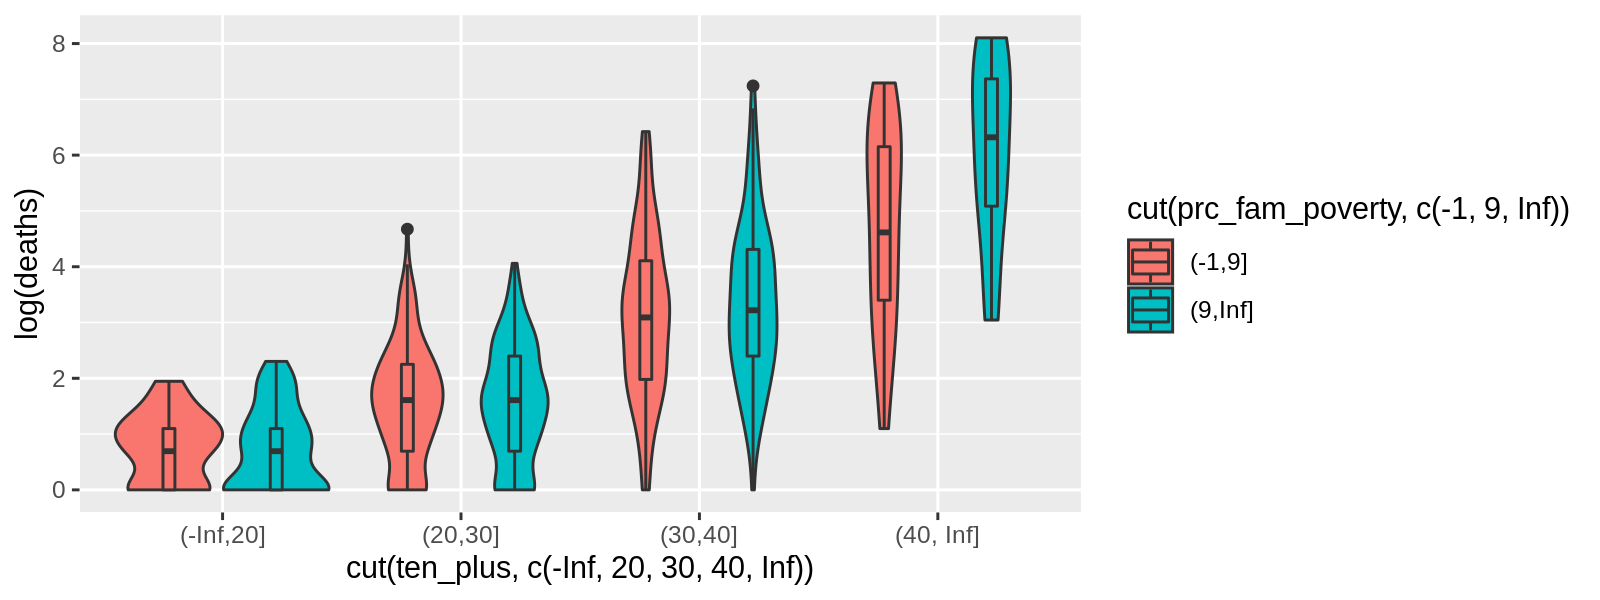

In [68]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 20, 30, 40, Inf)), log(deaths), fill=cut(prc_fam_poverty, c(-1, 9.0, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [69]:
abbrev.columns

Index(['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
       'empl_transp_utilities', 'prc_fam_poverty', 'avg_income',
       'prc_public_transp', 'population', 'pop_65_plus', 'health_ins',
       'county', 'state', 'FIPS', 'area', 'prc_obese', 'incarcerated',
       'domestic_passengers', 'intl_passengers', 'deaths_march24',
       'deaths_april1', 'deaths', 'cases_march24', 'cases_april1',
       'cases_april23', 'ten_plus', 'order', 'density'],
      dtype='object')

In [70]:
abbrev.cases_march24.describe()

count     827.0
mean       54.9
std       323.6
min         0.0
25%         2.0
50%         5.0
75%        18.0
max      5066.0
Name: cases_march24, dtype: float64

In [71]:
abbrev.order.describe()

count    827.0
mean      25.7
std        8.1
min        0.0
25%       22.0
50%       25.0
75%       32.0
max       38.0
Name: order, dtype: float64

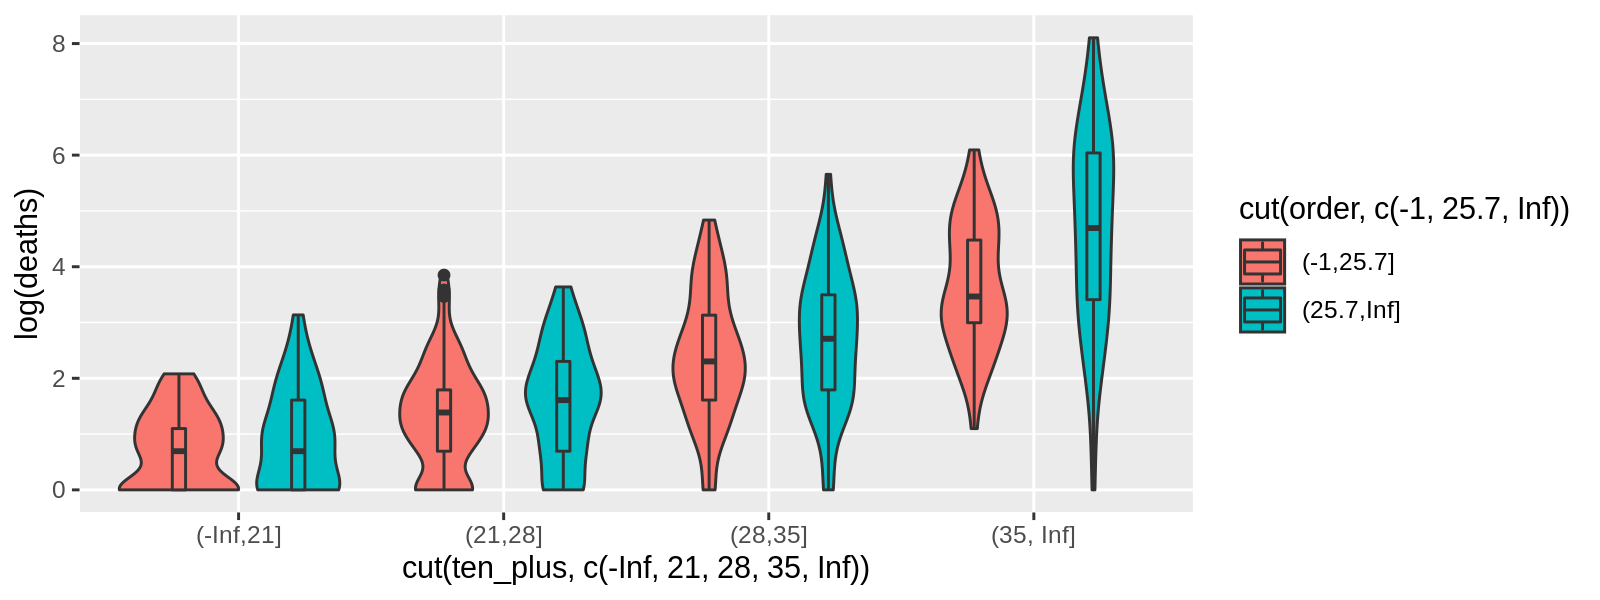

In [72]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 21, 28, 35, Inf)), log(deaths), fill=cut(order, c(-1, 25.7, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

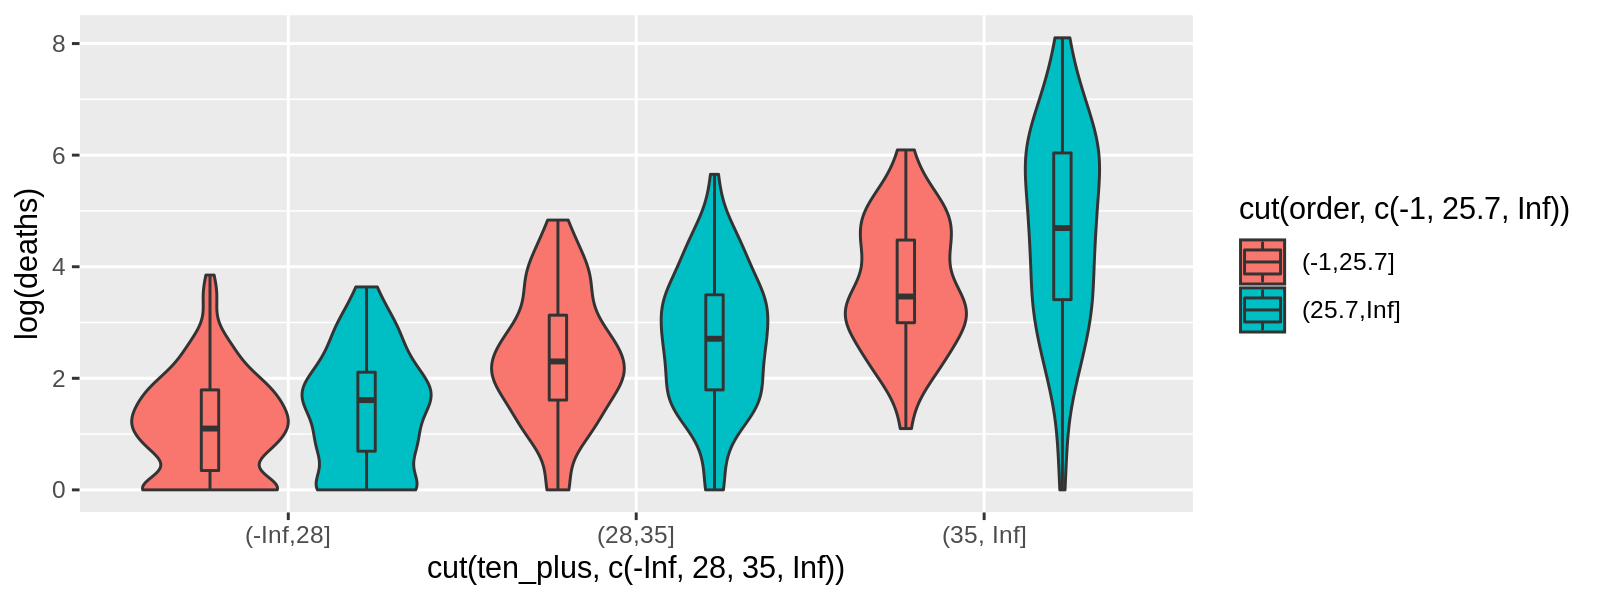

In [73]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 28, 35, Inf)), log(deaths), fill=cut(order, c(-1, 25.7, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [74]:
abbrev.pop_65_plus.describe()

count    827.0
mean      16.7
std        4.2
min        7.7
25%       14.0
50%       16.3
75%       18.6
max       56.8
Name: pop_65_plus, dtype: float64

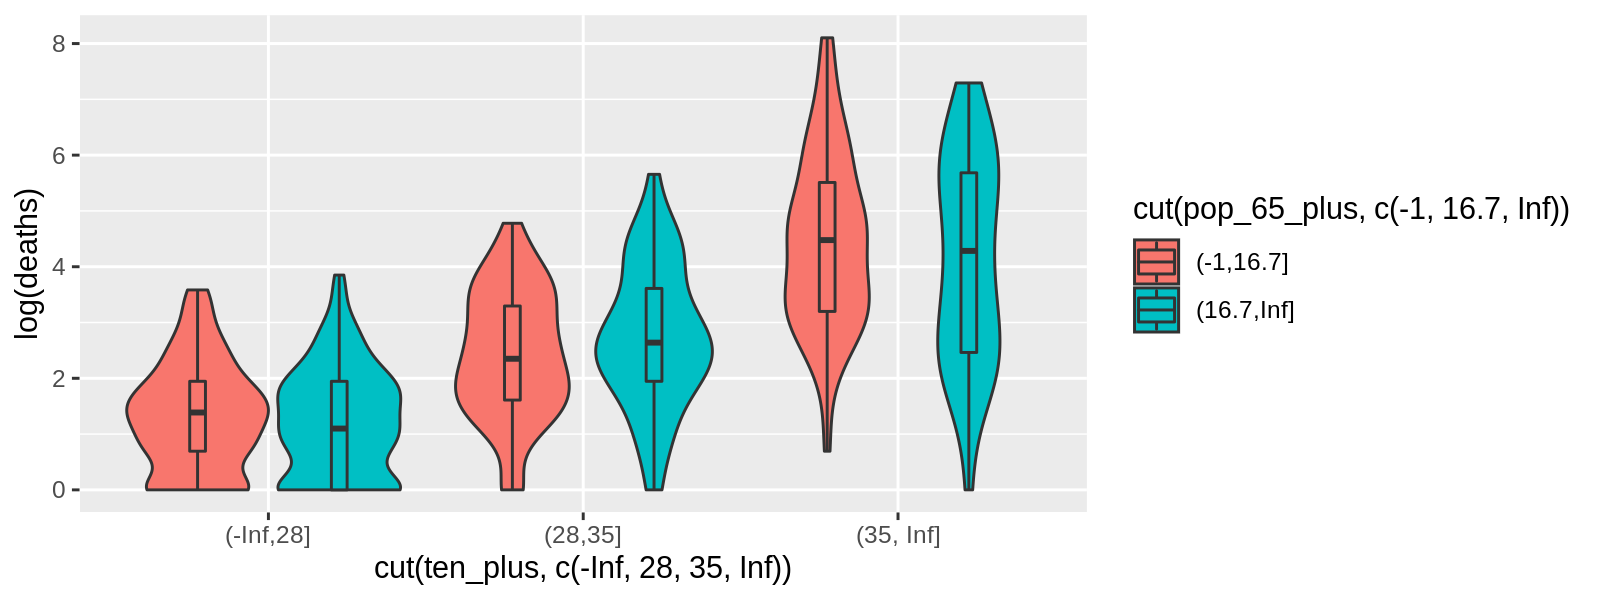

In [75]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 28, 35, Inf)), log(deaths), fill=cut(pop_65_plus, c(-1, 16.7, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [76]:
abbrev.avg_income.describe()

count      827.0
mean     32026.4
std       7871.9
min      14605.0
25%      26839.5
50%      30614.0
75%      35698.0
max      74911.0
Name: avg_income, dtype: float64

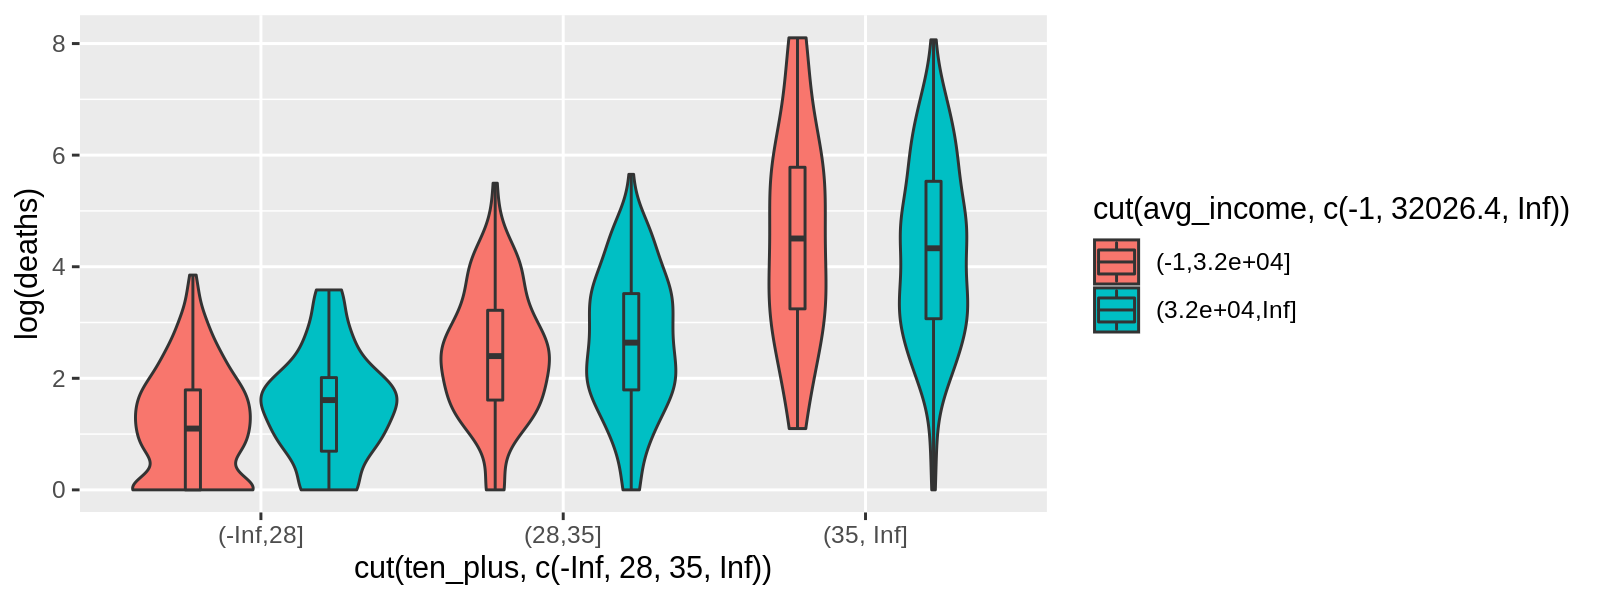

In [77]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 28, 35, Inf)), log(deaths), fill=cut(avg_income, c(-1, 32026.4, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [78]:
abbrev.empl_transp_utilities.describe()

count    827.0
mean       5.3
std        1.9
min        0.0
25%        4.0
50%        5.0
75%        6.4
max       17.2
Name: empl_transp_utilities, dtype: float64

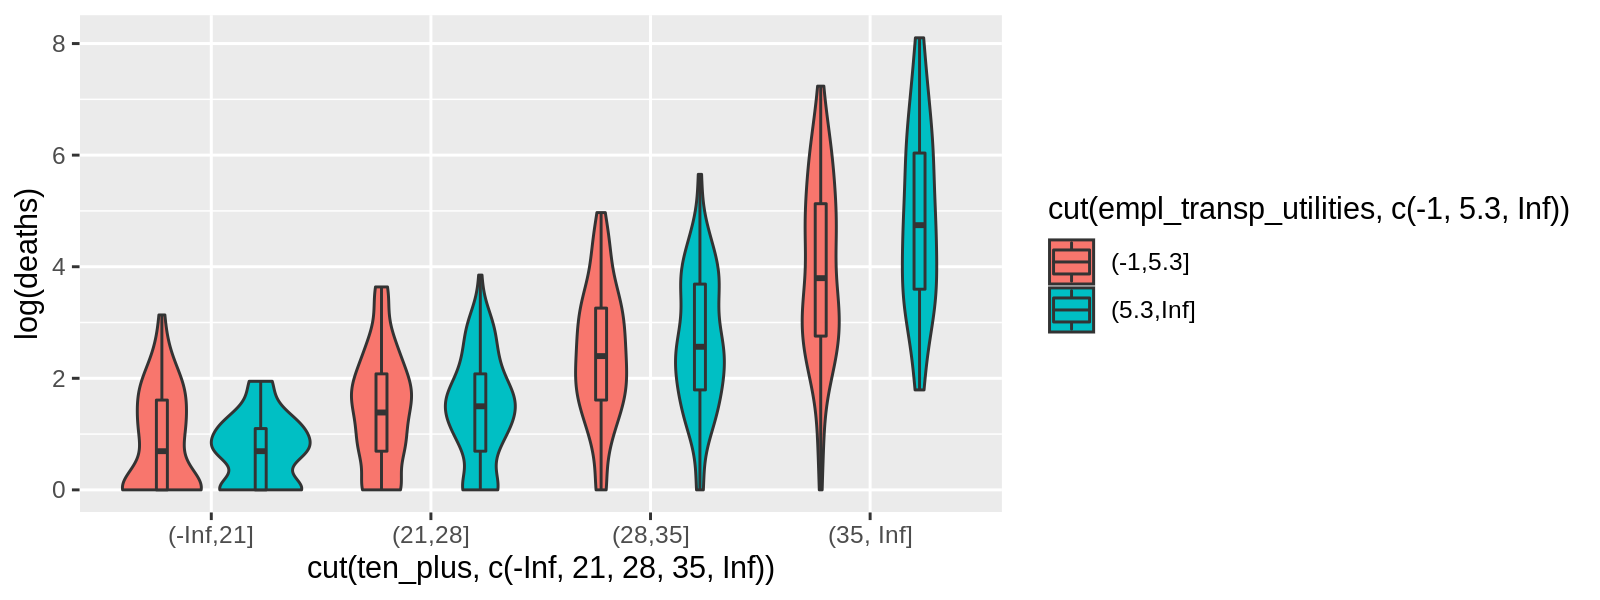

In [79]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 21, 28, 35, Inf)), log(deaths), fill=cut(empl_transp_utilities, c(-1, 5.3, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

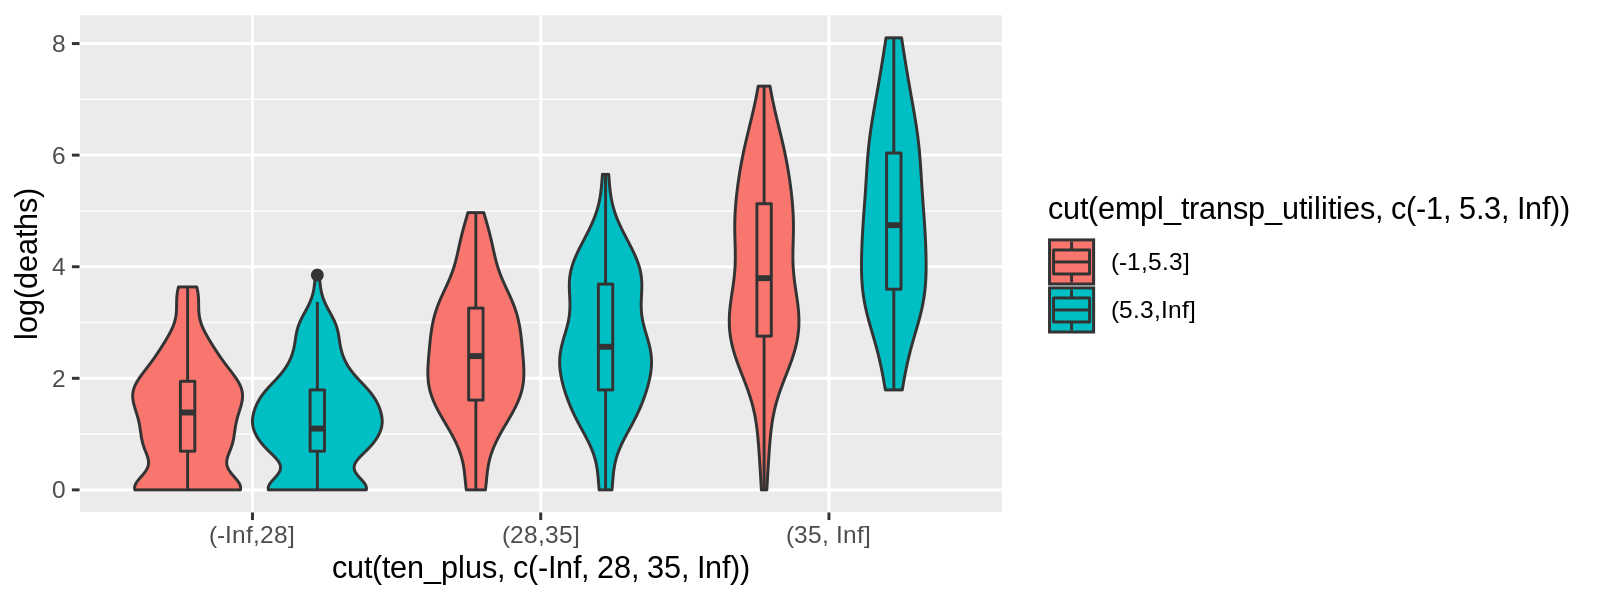

In [80]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 28, 35, Inf)), log(deaths), fill=cut(empl_transp_utilities, c(-1, 5.3, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

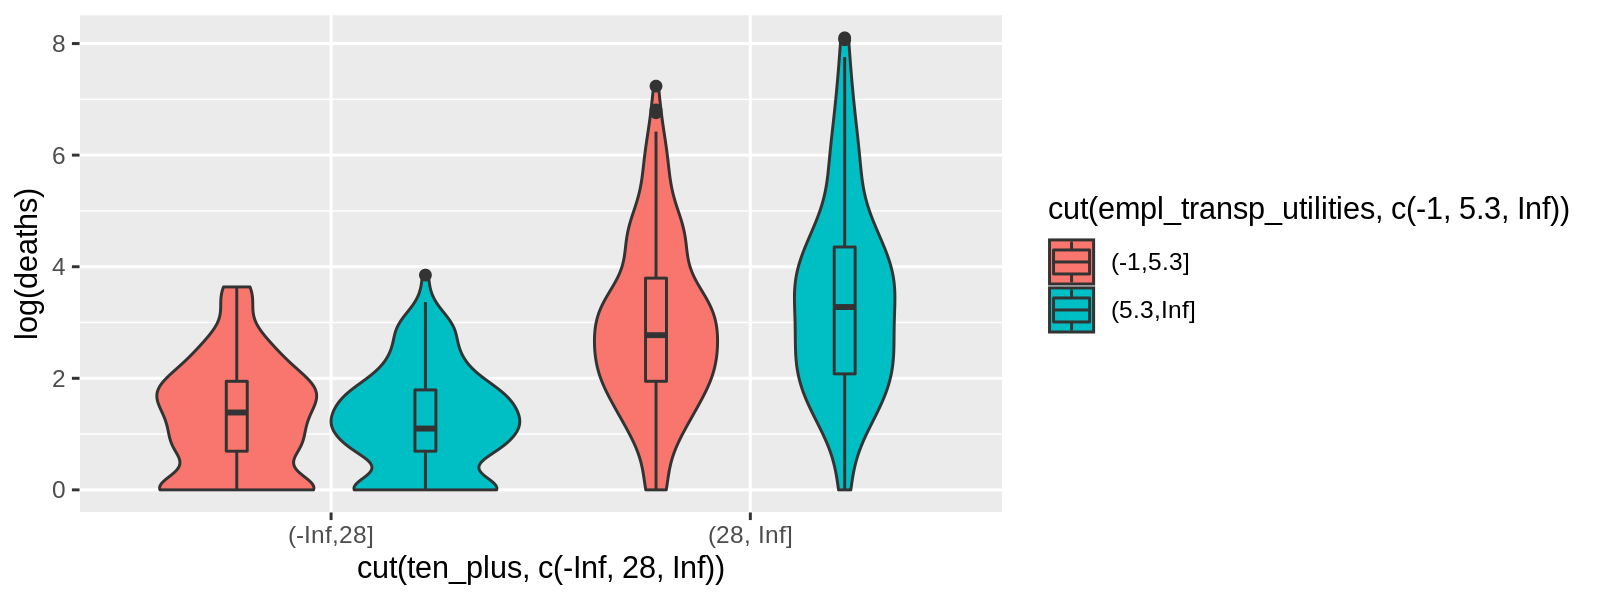

In [81]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 28, Inf)), log(deaths), fill=cut(empl_transp_utilities, c(-1, 5.3, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

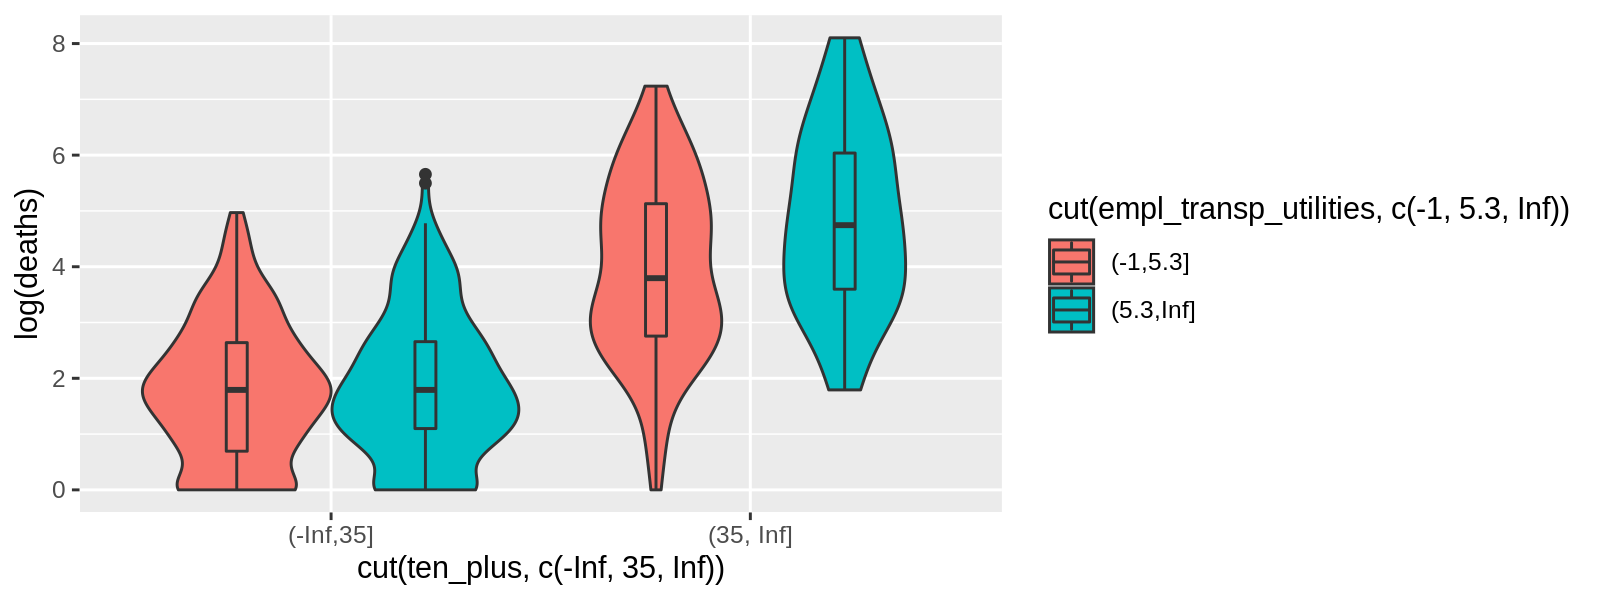

In [82]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 35, Inf)), log(deaths), fill=cut(empl_transp_utilities, c(-1, 5.3, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [83]:
abbrev.empl_retail.describe()

count    827.0
mean      11.5
std        2.0
min        0.0
25%       10.3
50%       11.4
75%       12.6
max       21.3
Name: empl_retail, dtype: float64

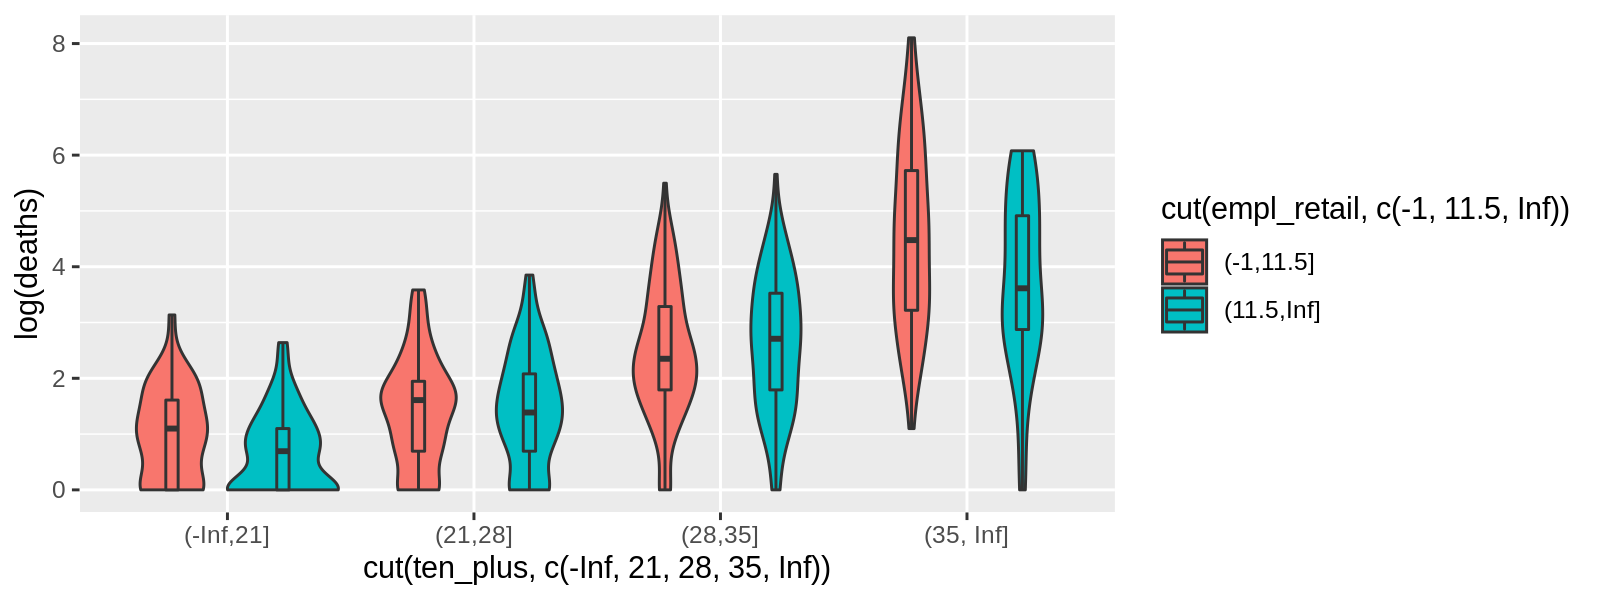

In [84]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 21, 28, 35, Inf)), log(deaths), fill=cut(empl_retail, c(-1, 11.5, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

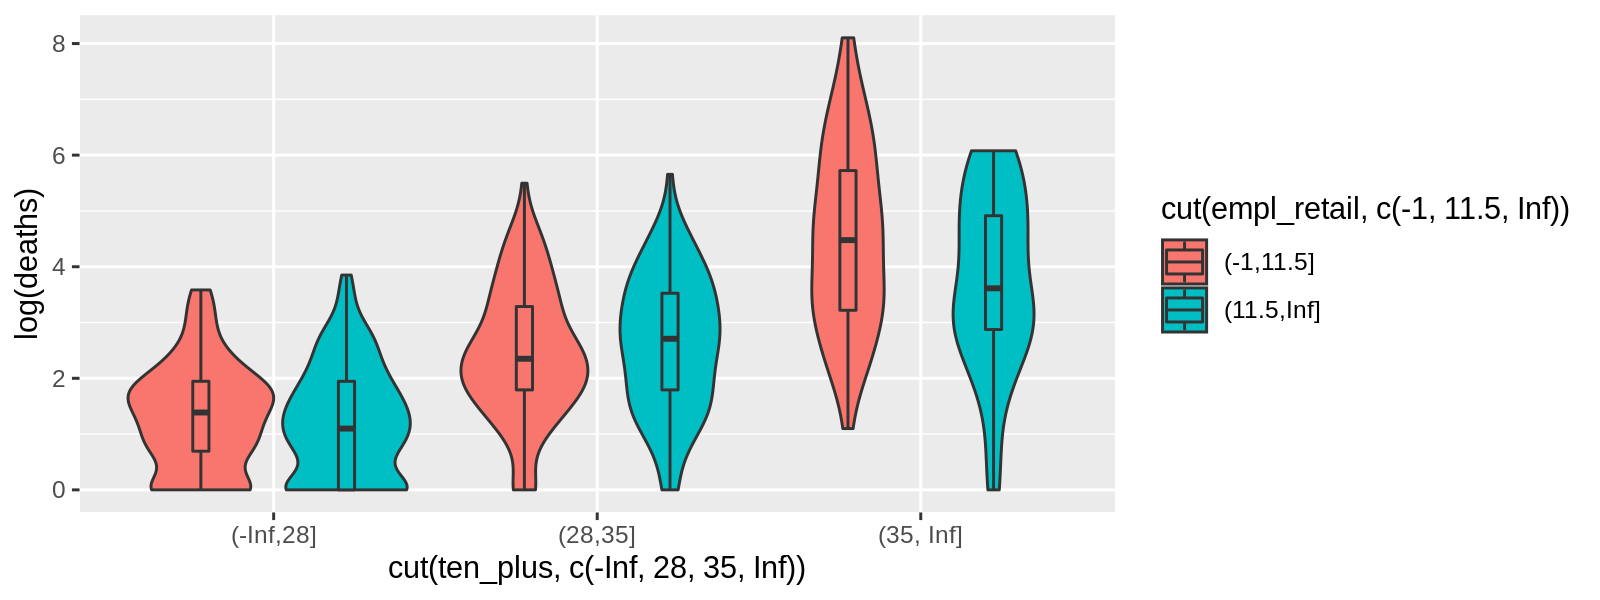

In [85]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 28, 35, Inf)), log(deaths), fill=cut(empl_retail, c(-1, 11.5, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

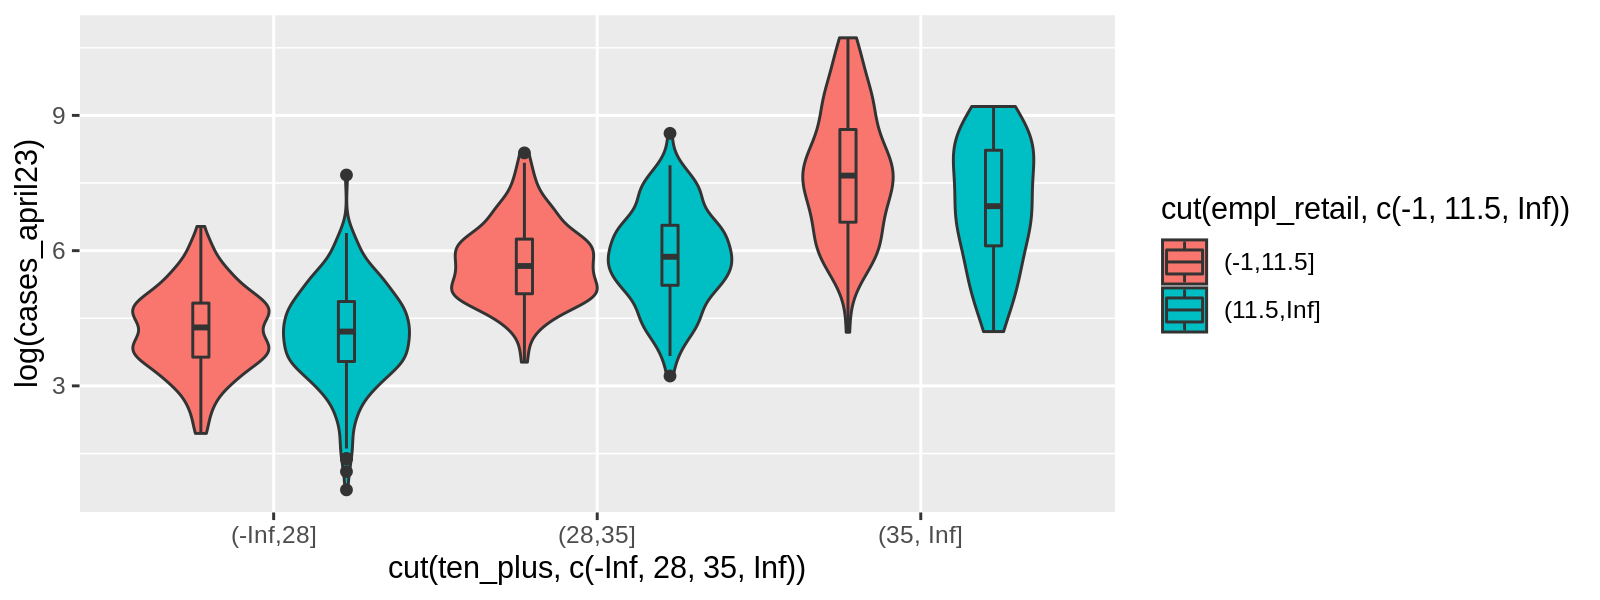

In [86]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 28, 35, Inf)), log(cases_april23), fill=cut(empl_retail, c(-1, 11.5, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [87]:
abbrev.empl_manufacturing.describe()

count    827.0
mean      11.0
std        5.9
min        0.0
25%        6.7
50%       10.0
75%       14.3
max       43.9
Name: empl_manufacturing, dtype: float64

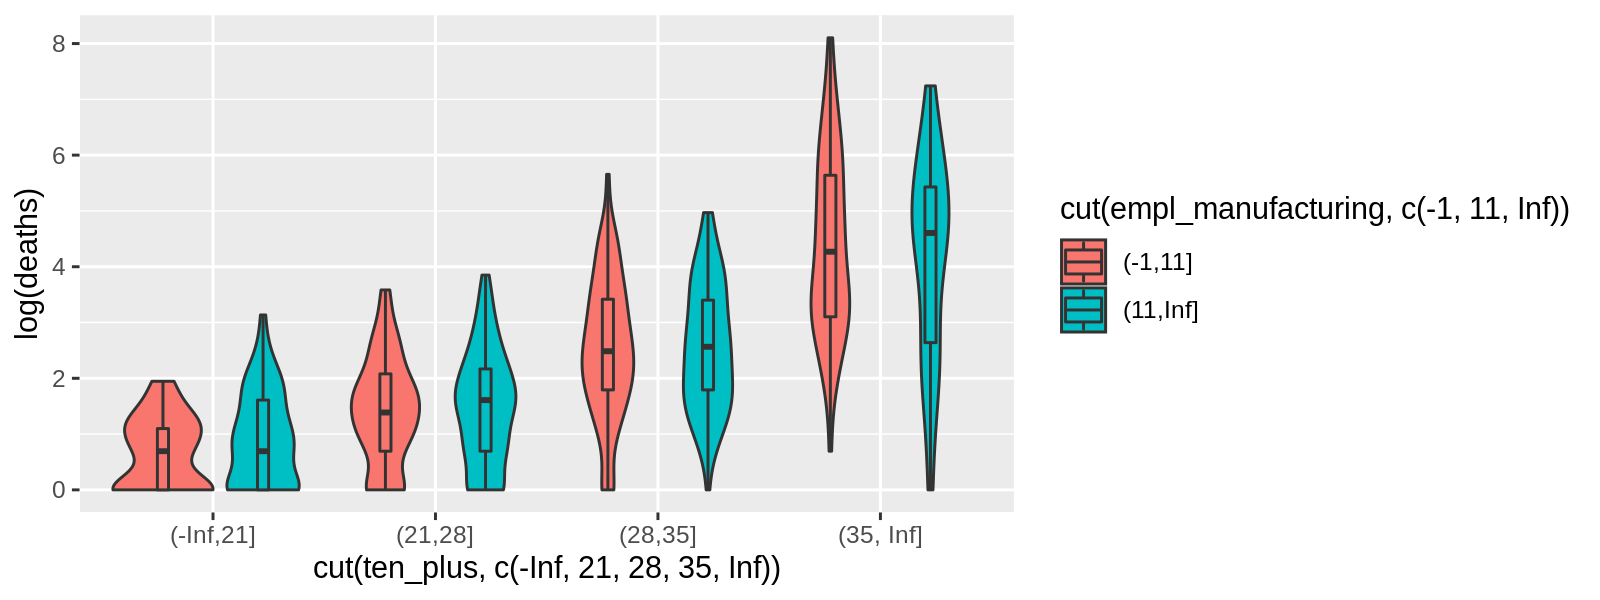

In [88]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 21, 28, 35, Inf)), log(deaths), fill=cut(empl_manufacturing, c(-1, 11.0, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

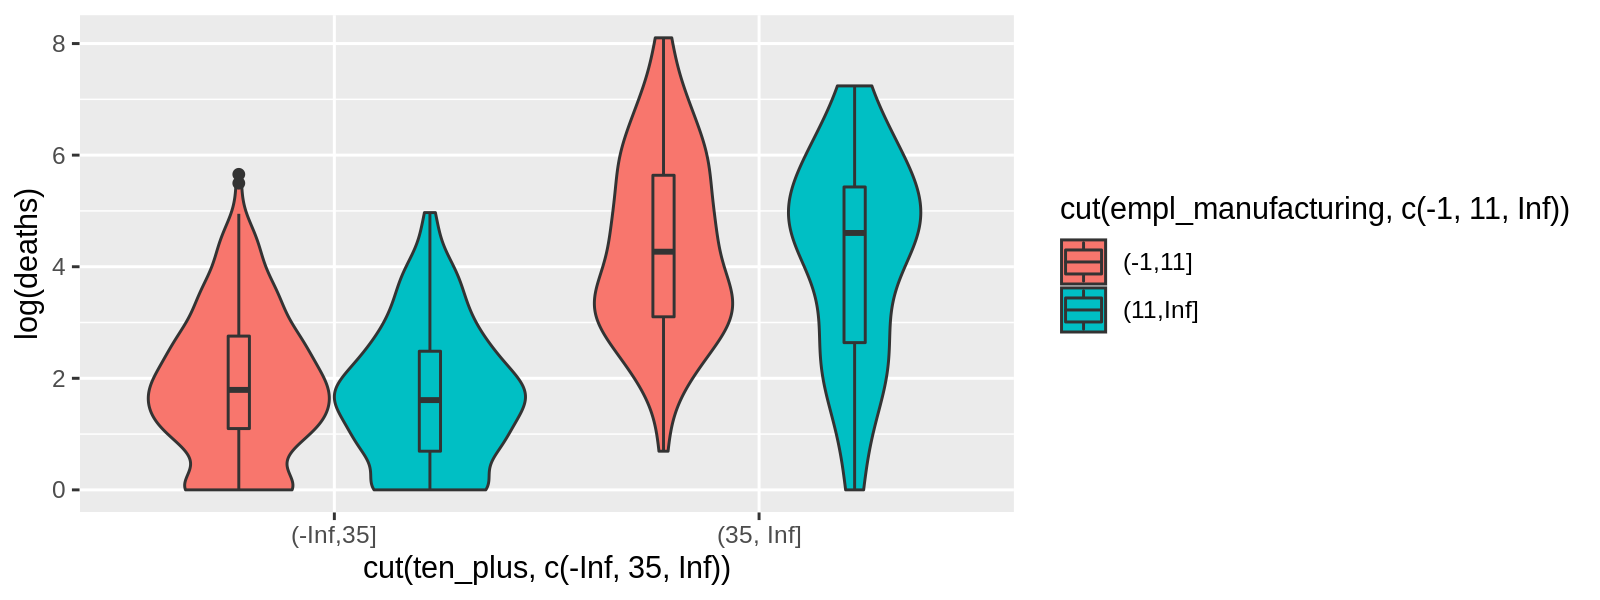

In [89]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 35, Inf)), log(deaths), fill=cut(empl_manufacturing, c(-1, 11.0, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [90]:
abbrev.empl_services.describe()

count    827.0
mean       9.7
std        2.8
min        0.0
25%        8.0
50%        9.3
75%       10.9
max       32.0
Name: empl_services, dtype: float64

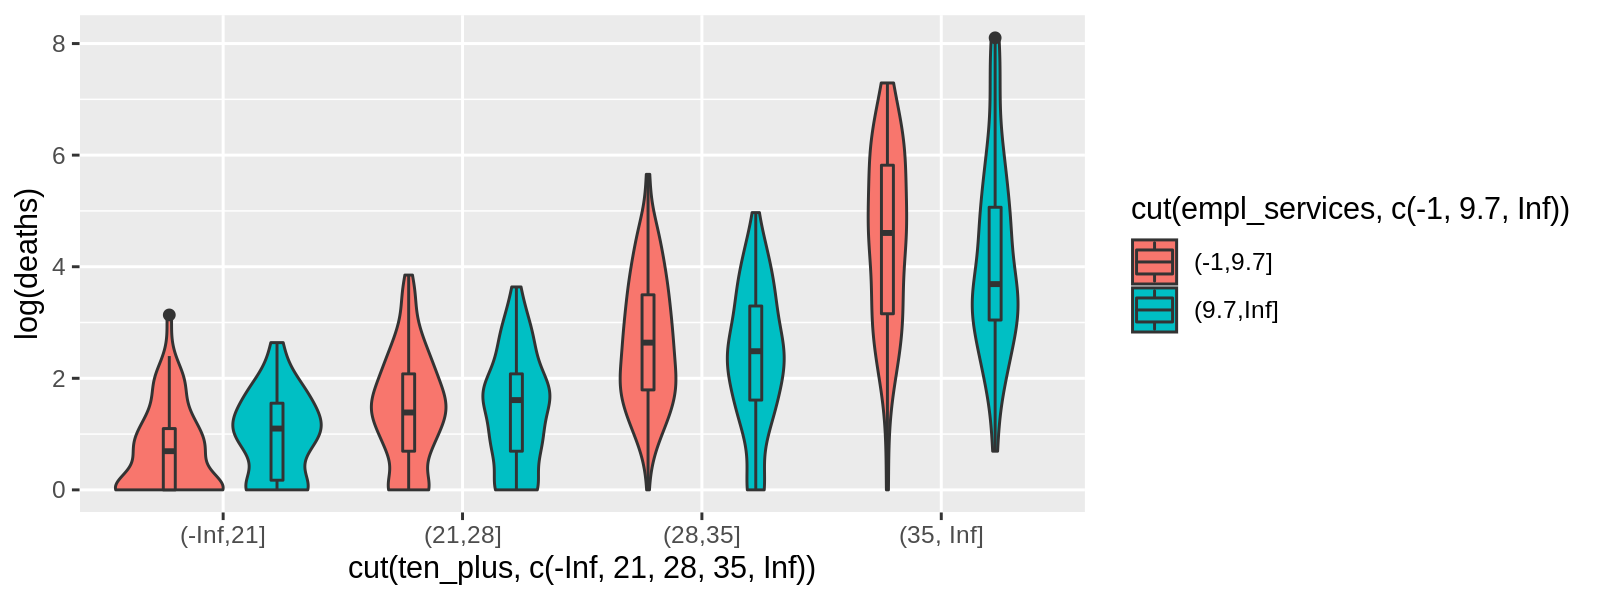

In [91]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 21, 28, 35, Inf)), log(deaths), fill=cut(empl_services, c(-1, 9.7, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

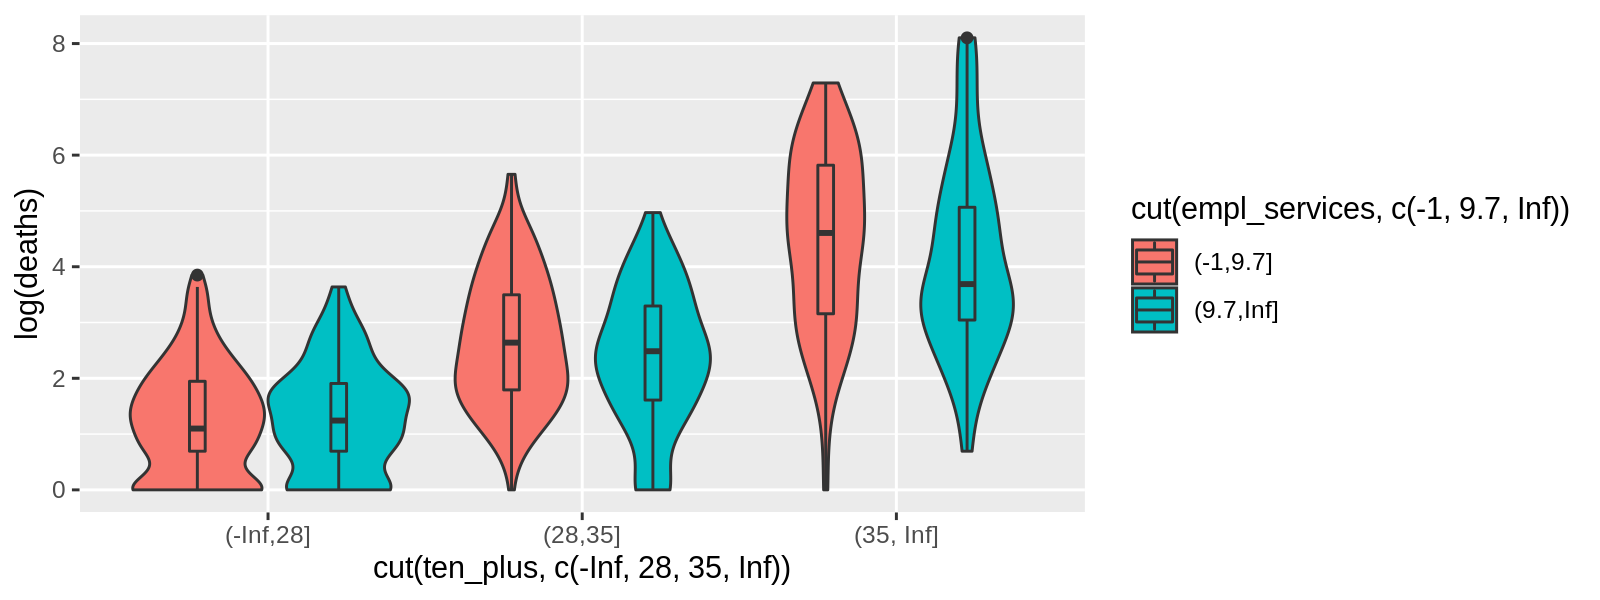

In [92]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 28, 35, Inf)), log(deaths), fill=cut(empl_services, c(-1, 9.7, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

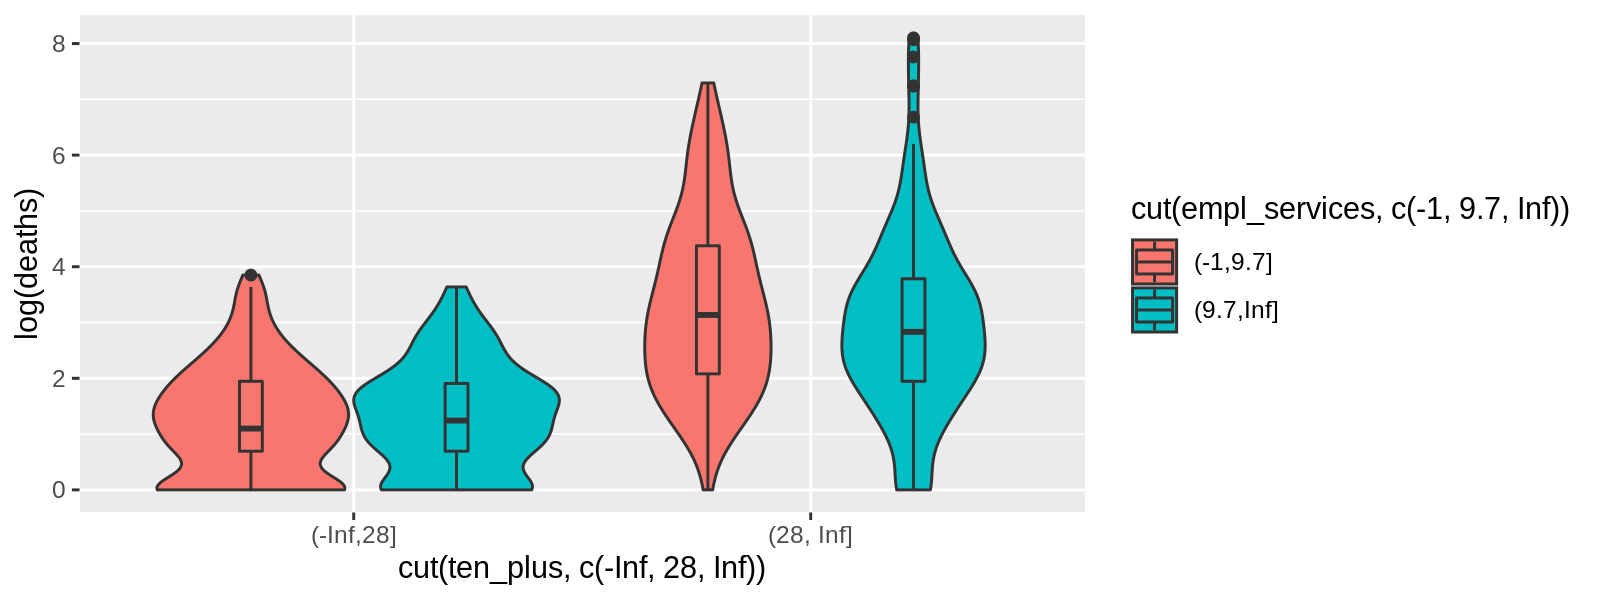

In [93]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 28, Inf)), log(deaths), fill=cut(empl_services, c(-1, 9.7, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

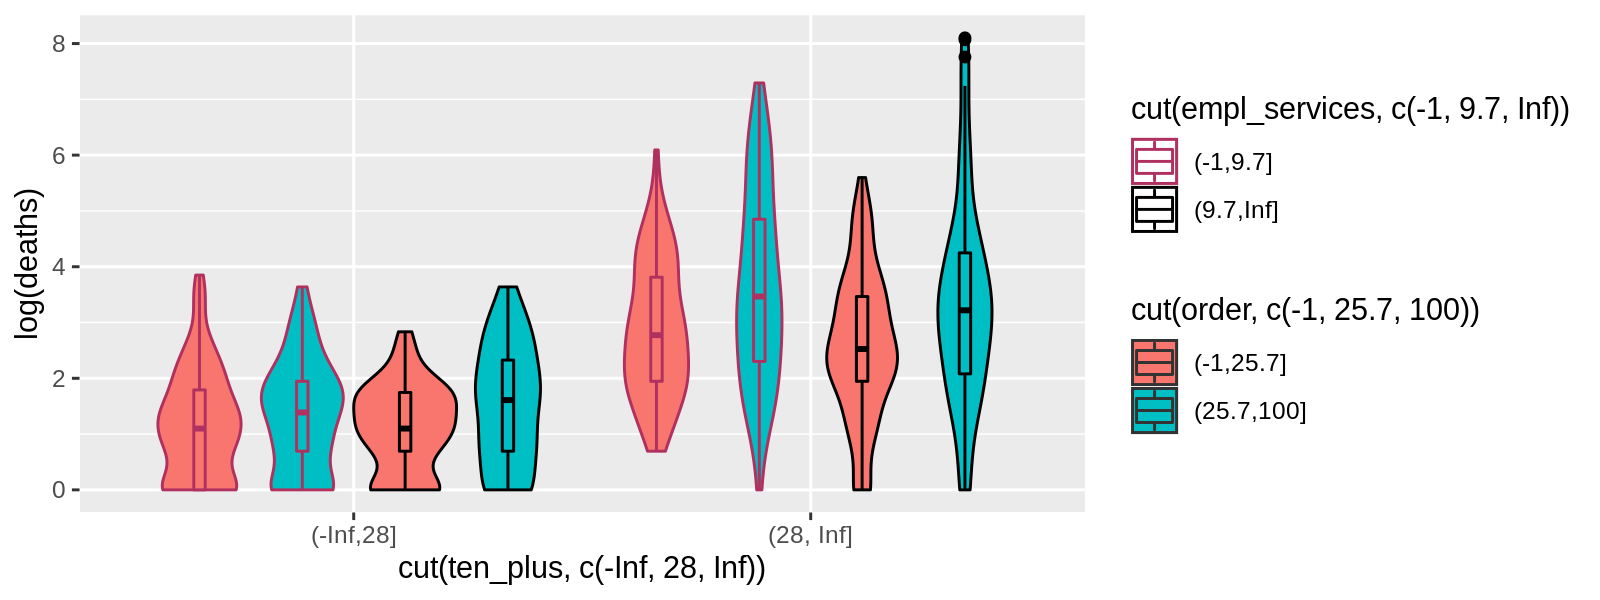

In [101]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 28, Inf)), log(deaths), color=cut(empl_services, c(-1, 9.7, Inf)), fill=cut(order, c(-1, 25.7, 100)))) +  
scale_colour_manual(values = c("Maroon", "Black")) +
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [102]:
abbrev.empl_social.describe()

count    827.0
mean      23.9
std        4.8
min        0.0
25%       20.9
50%       23.2
75%       26.4
max       46.2
Name: empl_social, dtype: float64

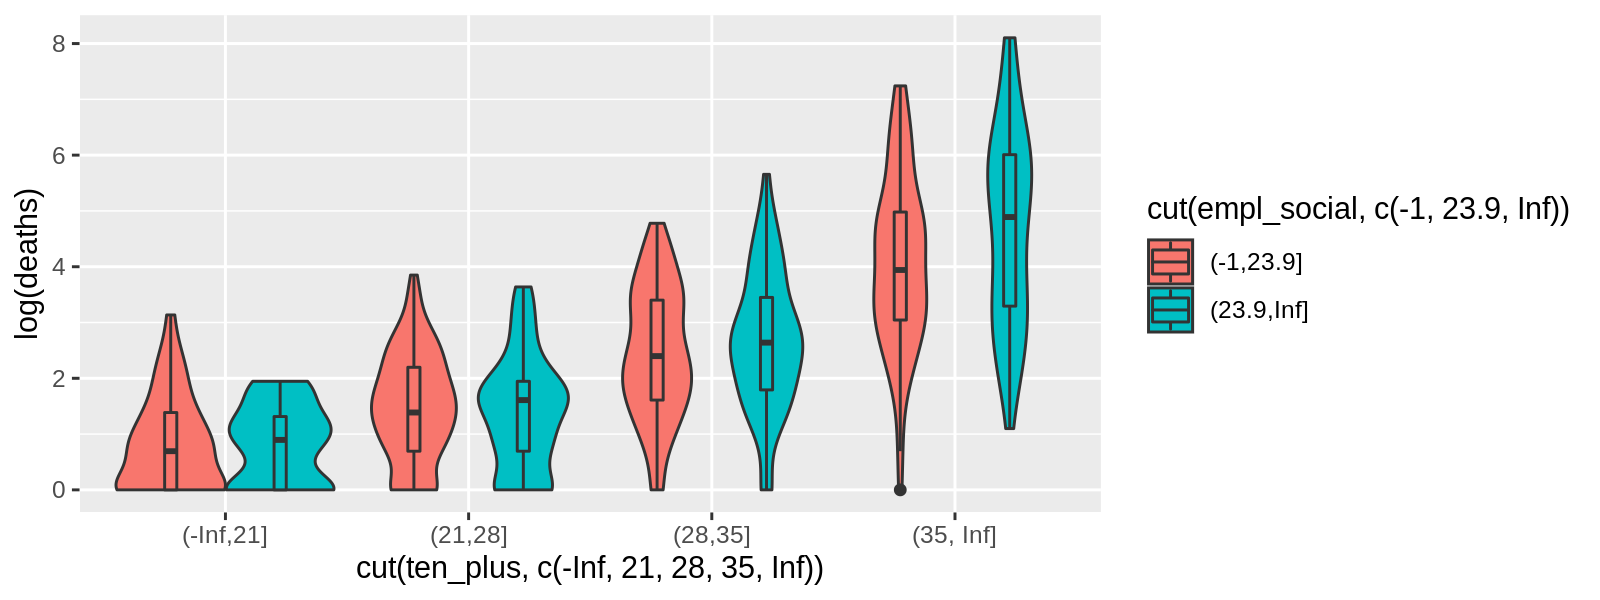

In [103]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 21, 28, 35, Inf)), log(deaths), fill=cut(empl_social, c(-1, 23.9, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

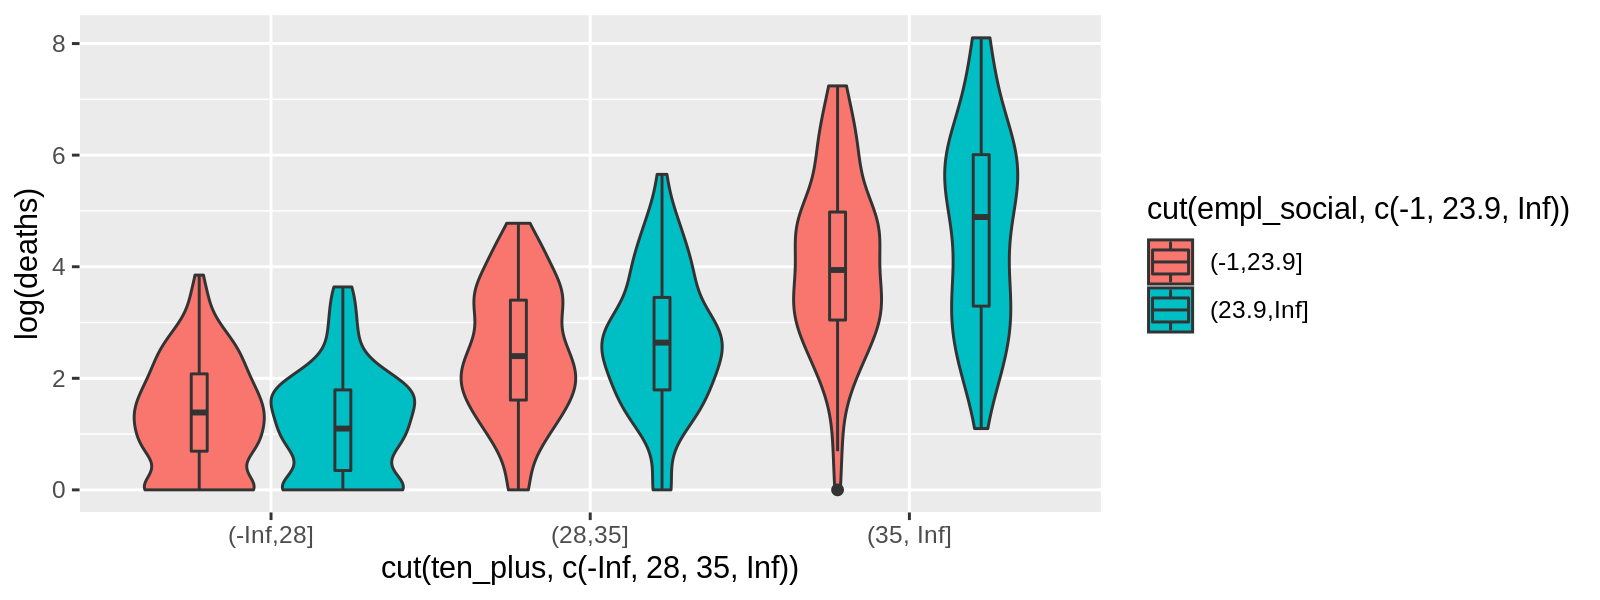

In [104]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 28, 35, Inf)), log(deaths), fill=cut(empl_social, c(-1, 23.9, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [105]:
abbrev.empl_professional.describe()

count    827.0
mean      10.1
std        3.6
min        0.0
25%        7.7
50%        9.6
75%       11.9
max       30.1
Name: empl_professional, dtype: float64

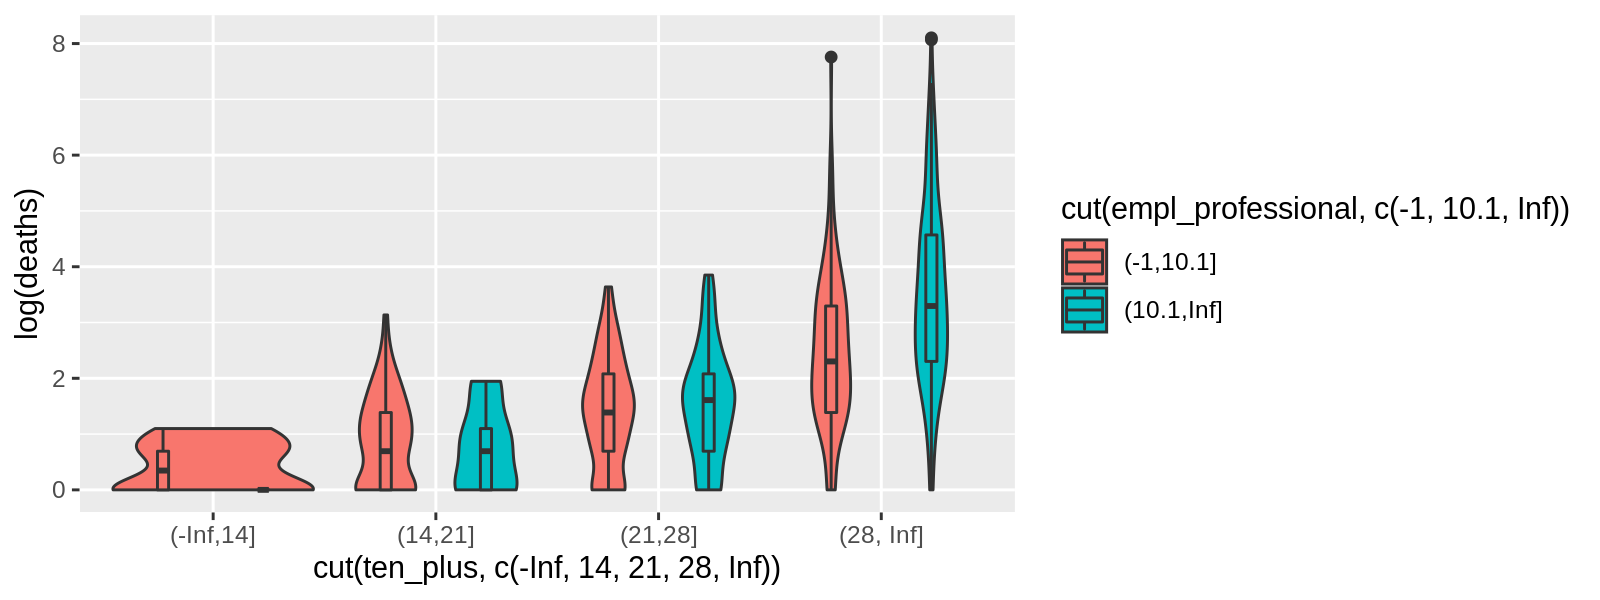

In [106]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 14, 21, 28, Inf)), log(deaths), fill=cut(empl_professional, c(-1, 10.1, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

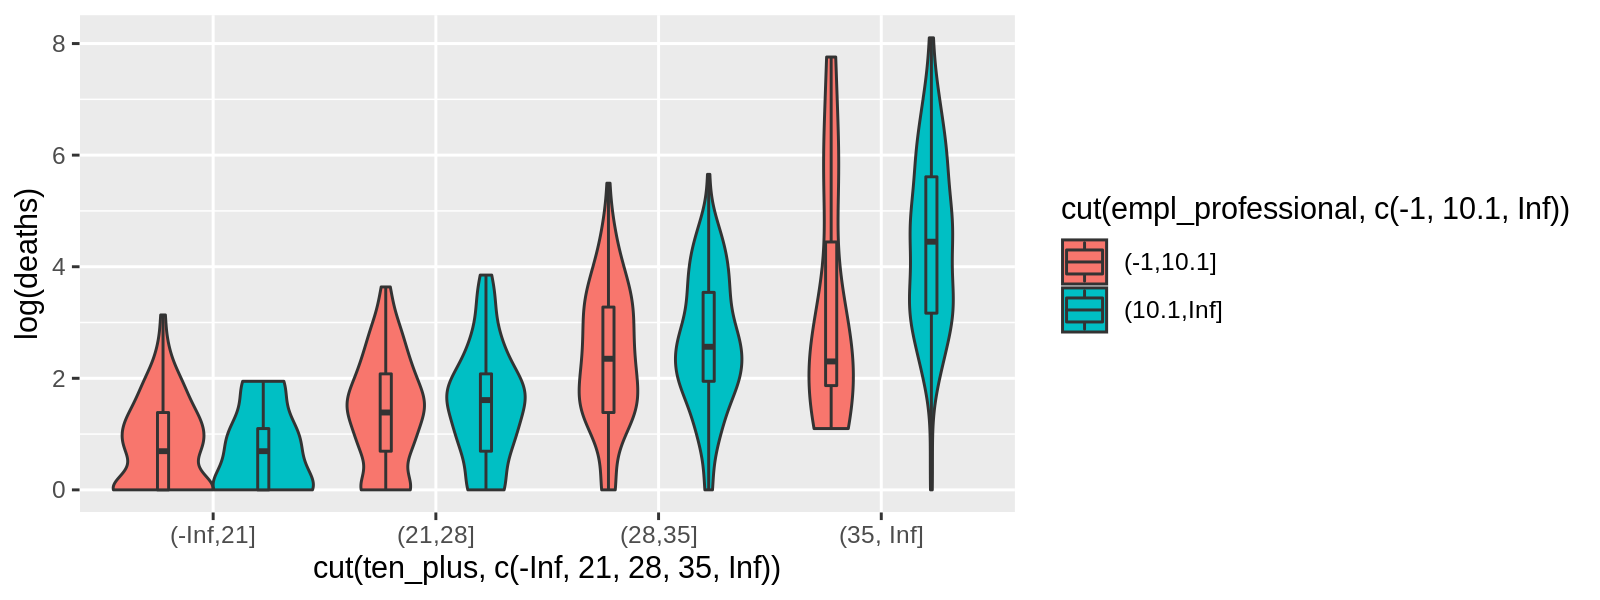

In [107]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 21, 28, 35, Inf)), log(deaths), fill=cut(empl_professional, c(-1, 10.1, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [108]:
abbrev.empl_agriculture.describe()

count    827.0
mean       1.9
std        2.7
min        0.0
25%        0.5
50%        1.0
75%        2.3
max       25.7
Name: empl_agriculture, dtype: float64

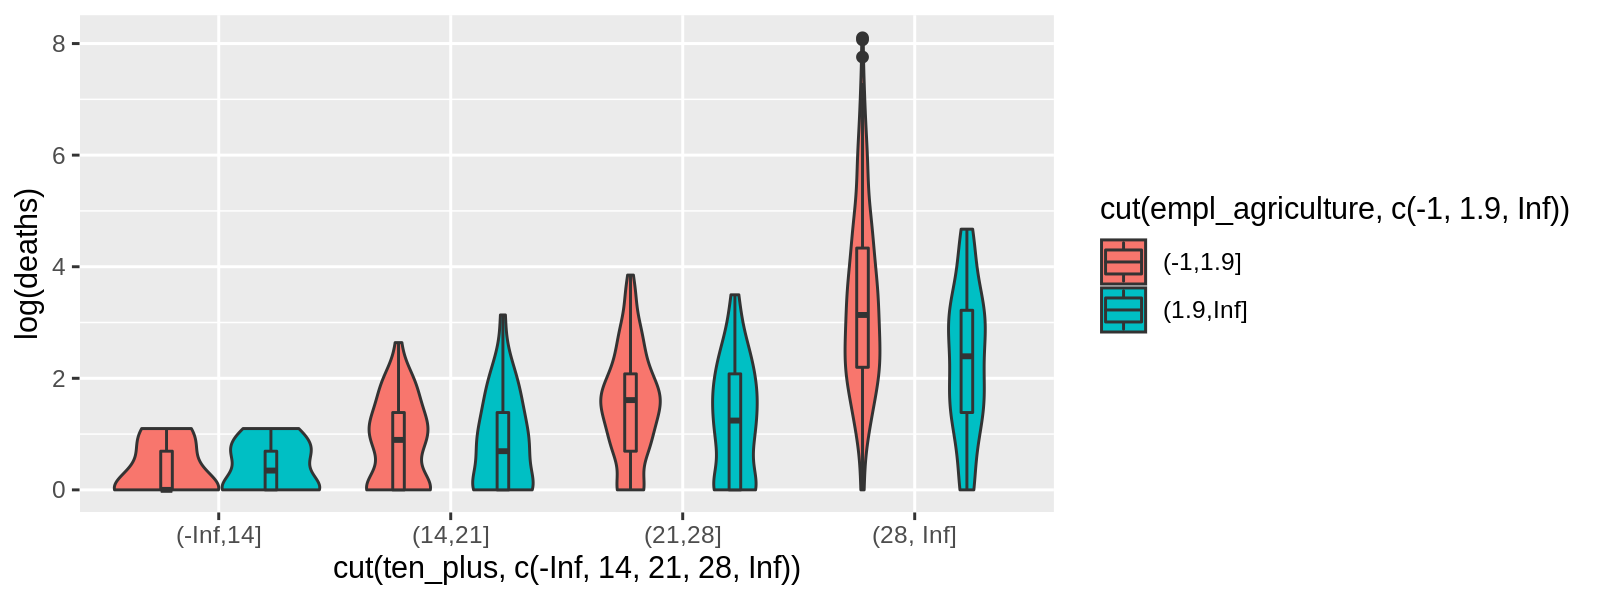

In [109]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 14, 21, 28, Inf)), log(deaths), fill=cut(empl_agriculture, c(-1, 1.9, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

# more agriculture is more rural...

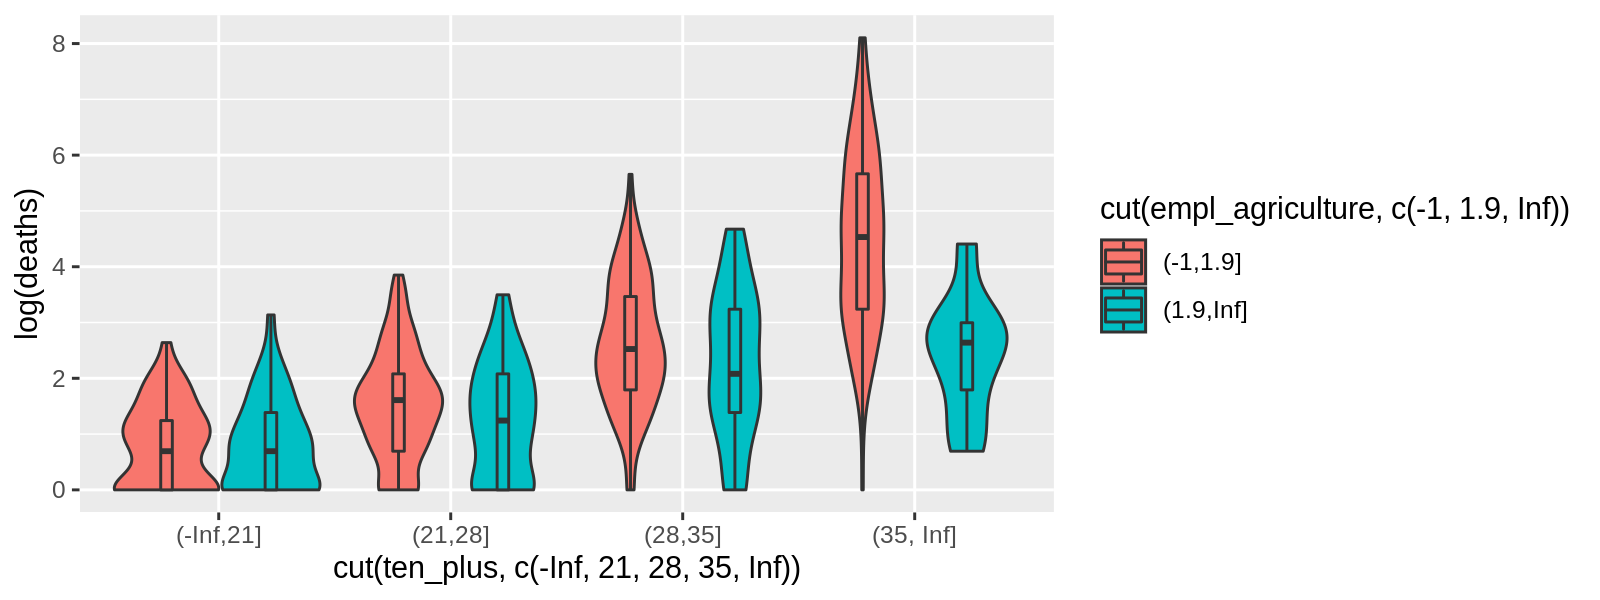

In [110]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 21, 28, 35, Inf)), log(deaths), fill=cut(empl_agriculture, c(-1, 1.9, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

# more agriculture is more rural...

In [111]:
abbrev.household_size.describe()

count    827.0
mean       2.6
std        0.3
min        1.9
25%        2.4
50%        2.5
75%        2.7
max        4.1
Name: household_size, dtype: float64

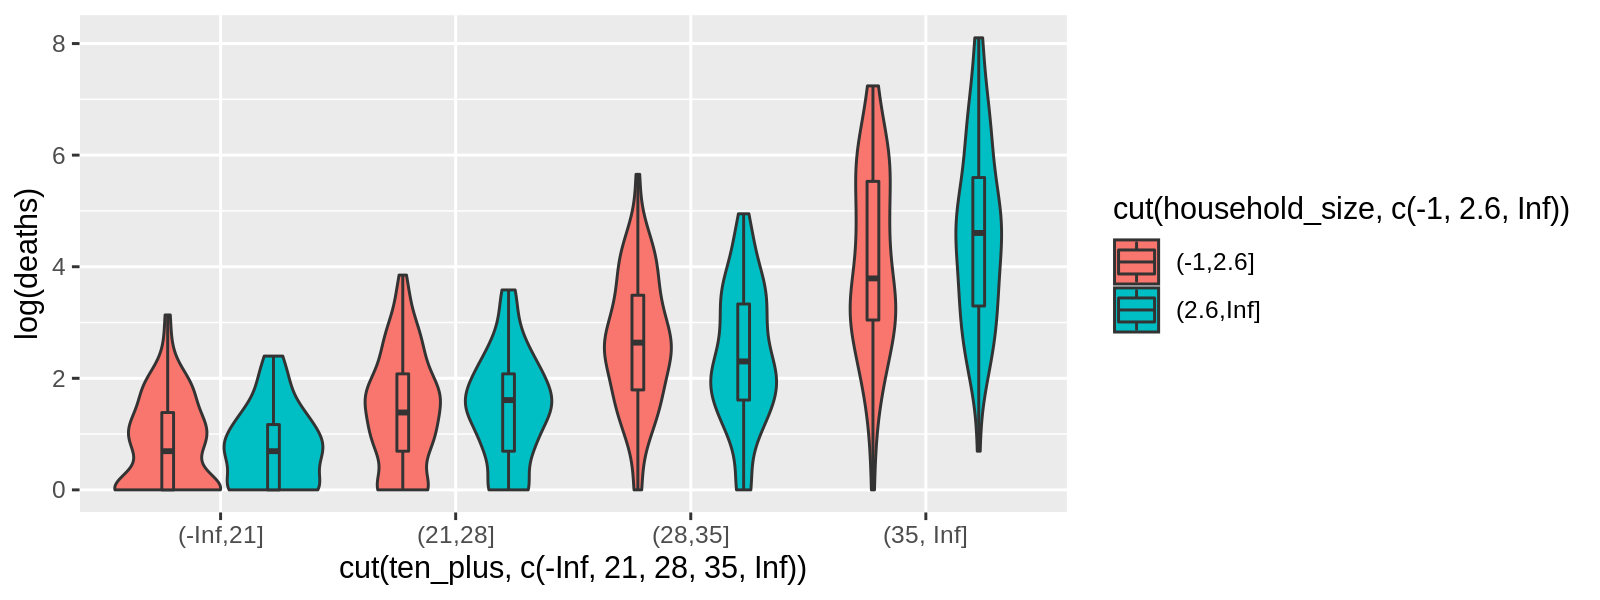

In [112]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 21, 28, 35, Inf)), log(deaths), fill=cut(household_size, c(-1, 2.6, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [113]:
abbrev[["order", "ten_plus"]].describe()

order  ten_plus
count  827.0     827.0
mean    25.7      27.6
std      8.1       8.4
min      0.0       0.0
25%     22.0      23.0
50%     25.0      28.0
75%     32.0      33.0
max     38.0      52.0

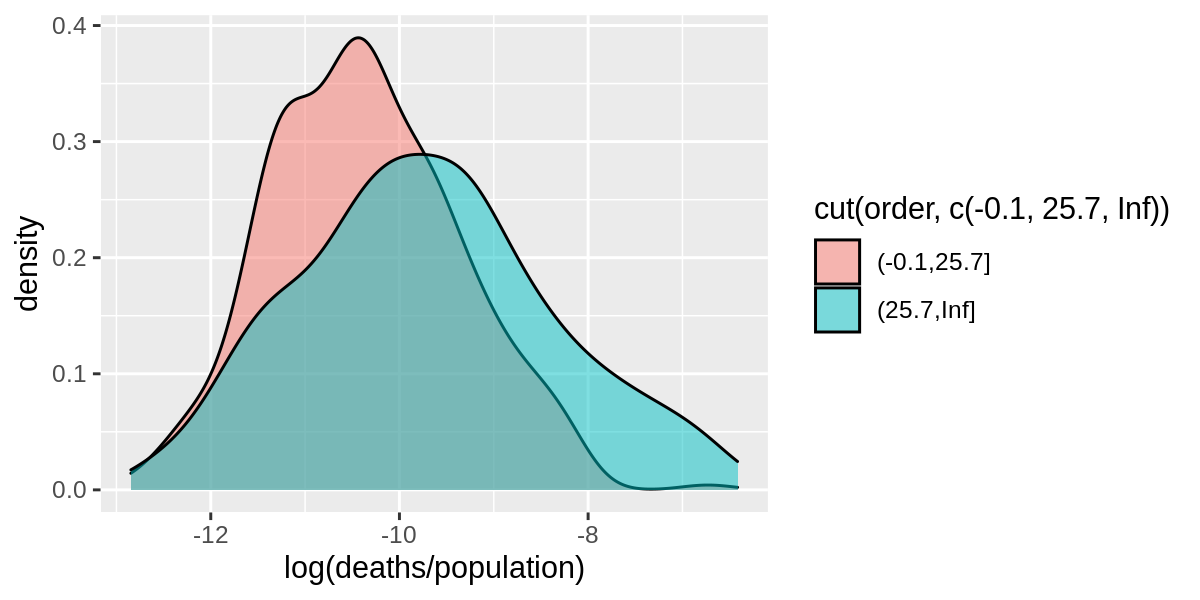

In [114]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(order, c(-0.1, 25.7, Inf)))) + geom_density(alpha=.5)

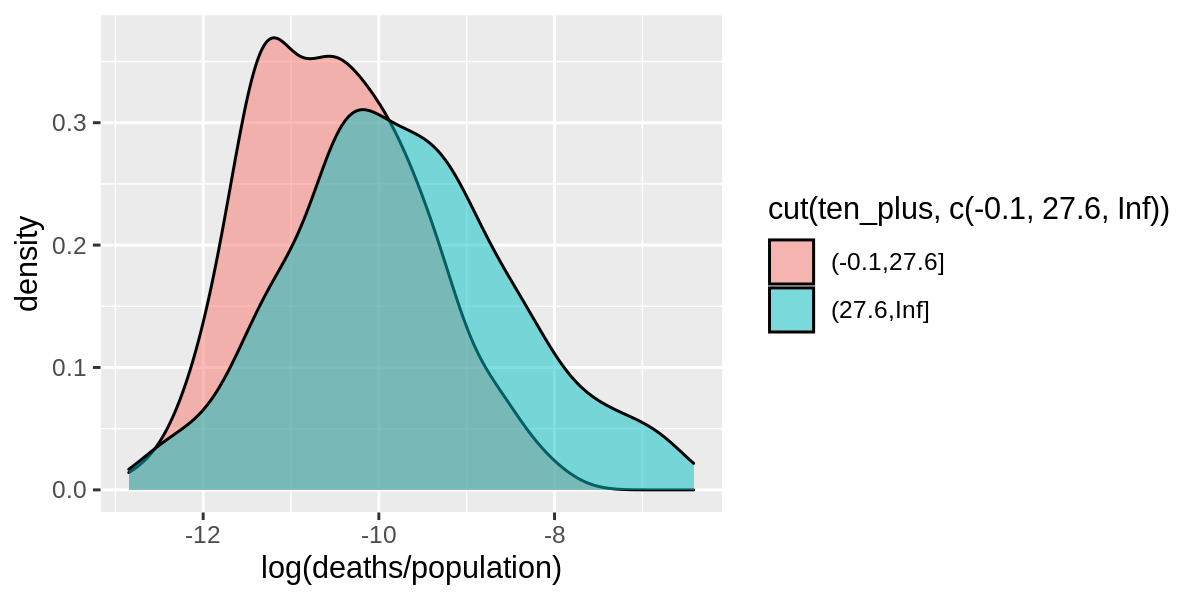

In [115]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(ten_plus, c(-0.1, 27.6, Inf)))) + geom_density(alpha=.5)
# not surprising that >avg time since 10+ cases detected on average have higher deaths/population

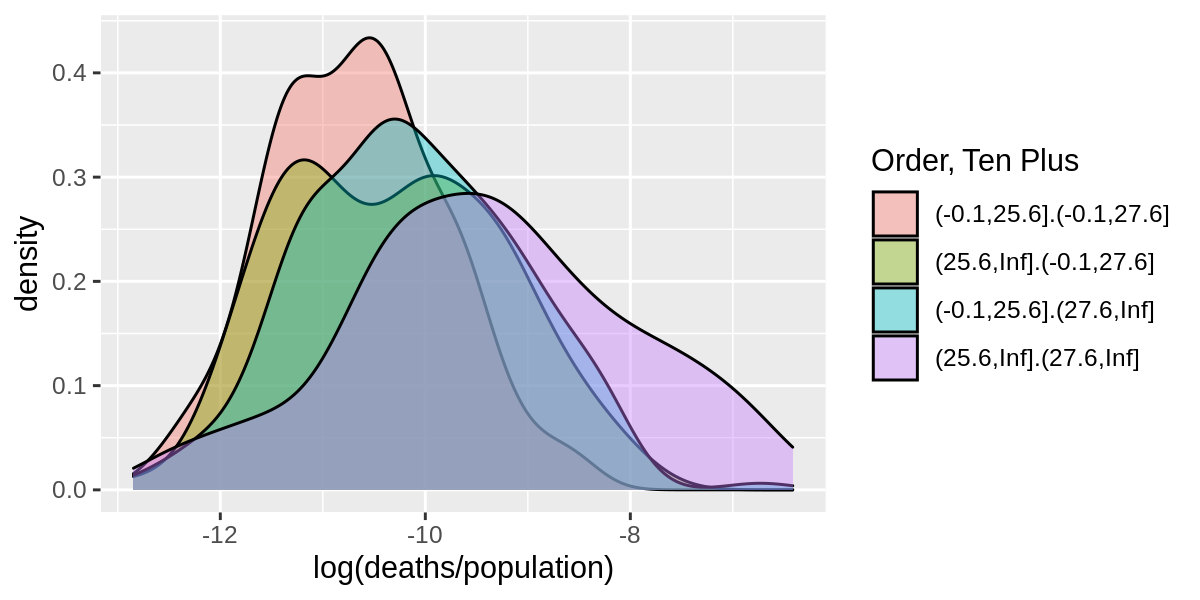

In [116]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=interaction(cut(order, c(-0.1, 25.6, Inf)), 
                                                              cut(ten_plus, c(-0.1, 27.6, Inf))))) + geom_density(alpha=.4) +
scale_fill_discrete(name  ="Order, Ten Plus")

In [117]:
abbrev.empl_retail.describe()

count    827.0
mean      11.5
std        2.0
min        0.0
25%       10.3
50%       11.4
75%       12.6
max       21.3
Name: empl_retail, dtype: float64

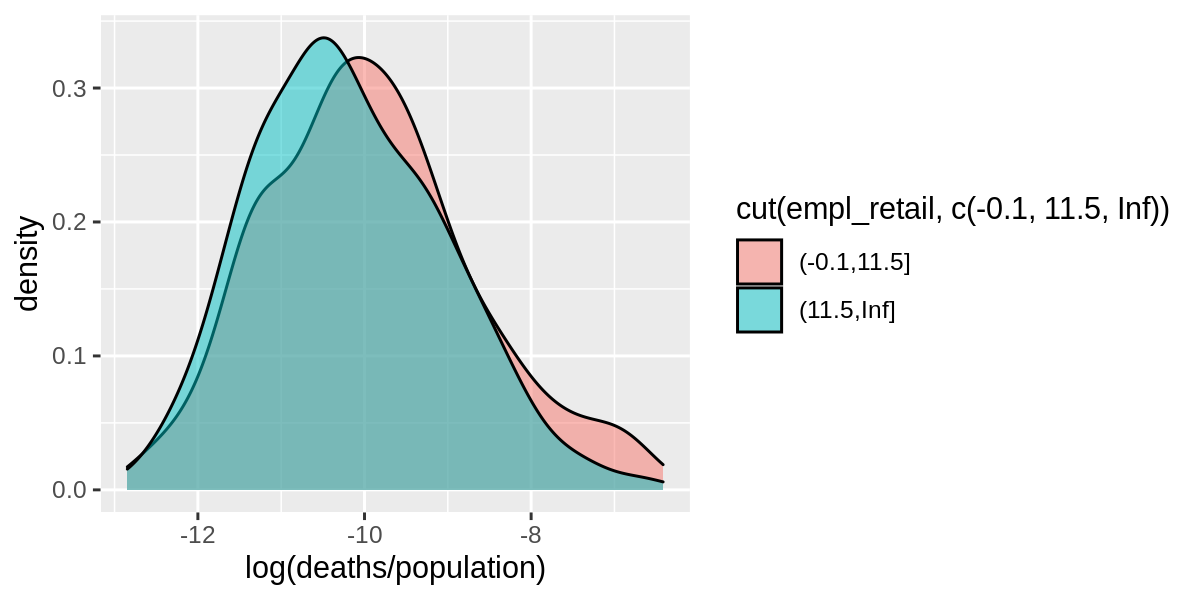

In [118]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(empl_retail, c(-0.1, 11.5, Inf)))) + geom_density(alpha=.5)
# opposite of what I had expected

In [119]:
abbrev.prc_public_transp.describe()

count    827.0
mean       2.2
std        5.5
min        0.0
25%        0.3
50%        0.7
75%        1.8
max       60.7
Name: prc_public_transp, dtype: float64

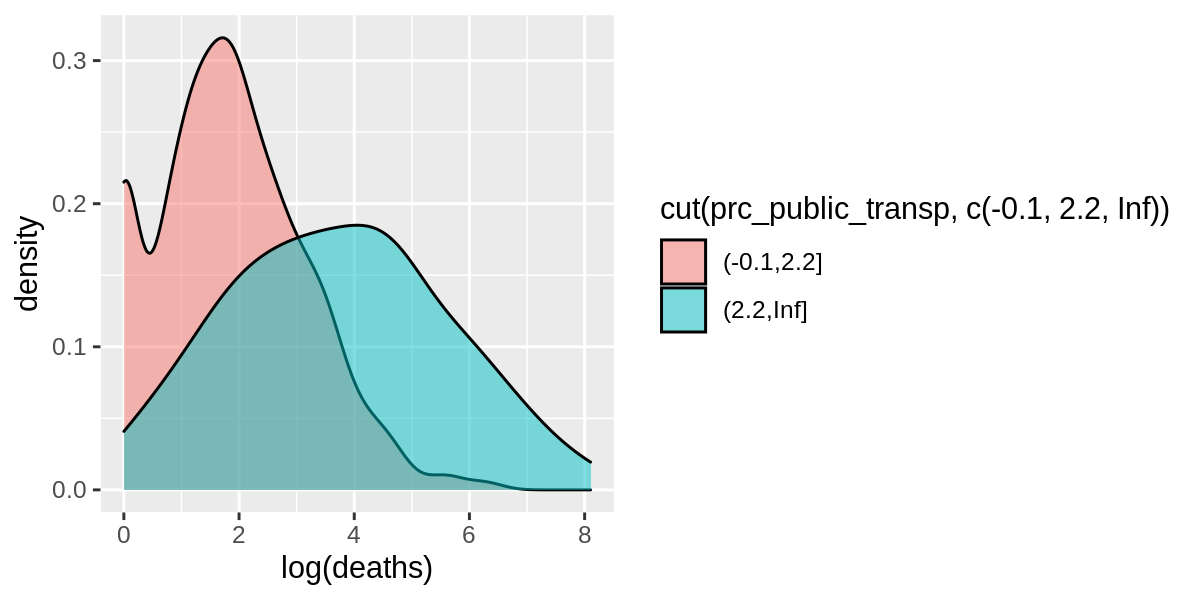

In [120]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths), fill=cut(prc_public_transp, c(-0.1, 2.2, Inf)))) + geom_density(alpha=.5)
# does look like a higher mean deaths/population for counties with higher than average % of population commuting via public transportation

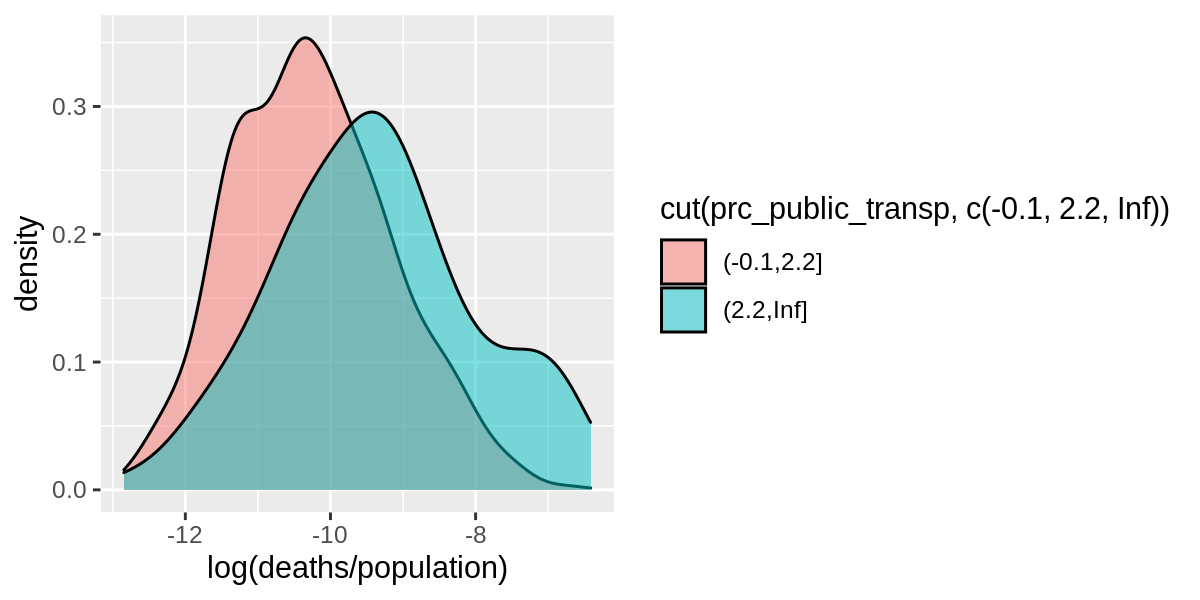

In [121]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(prc_public_transp, c(-0.1, 2.2, Inf)))) + geom_density(alpha=.5)
# does look like a higher mean deaths/population for counties with higher than average % of population commuting via public transportation

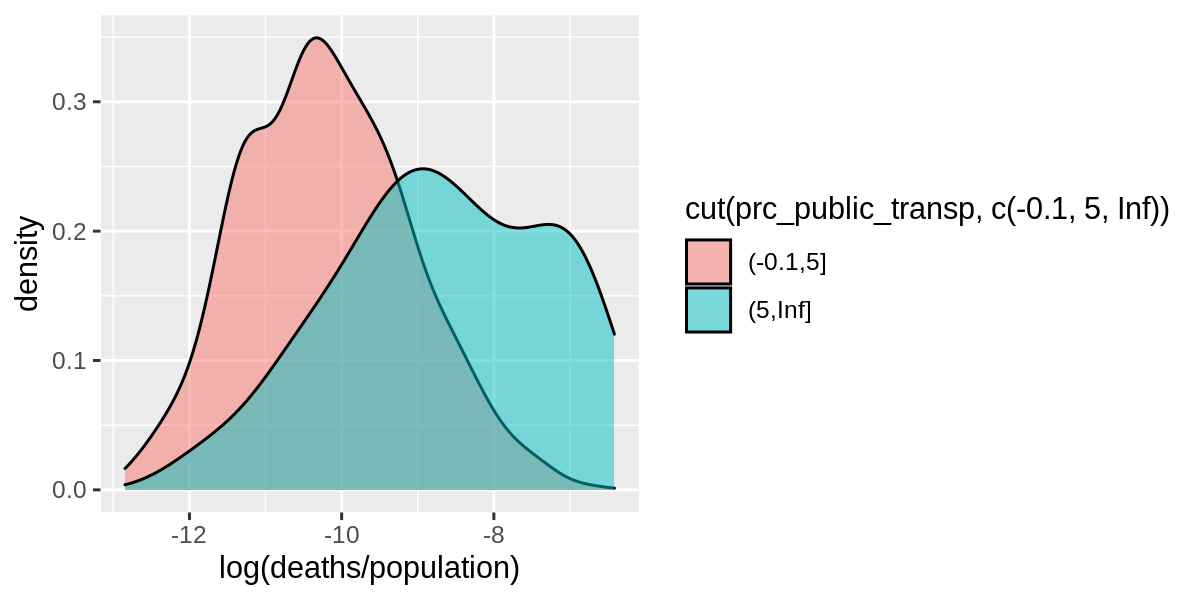

In [122]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(prc_public_transp, c(-0.1, 5, Inf)))) + geom_density(alpha=.5)

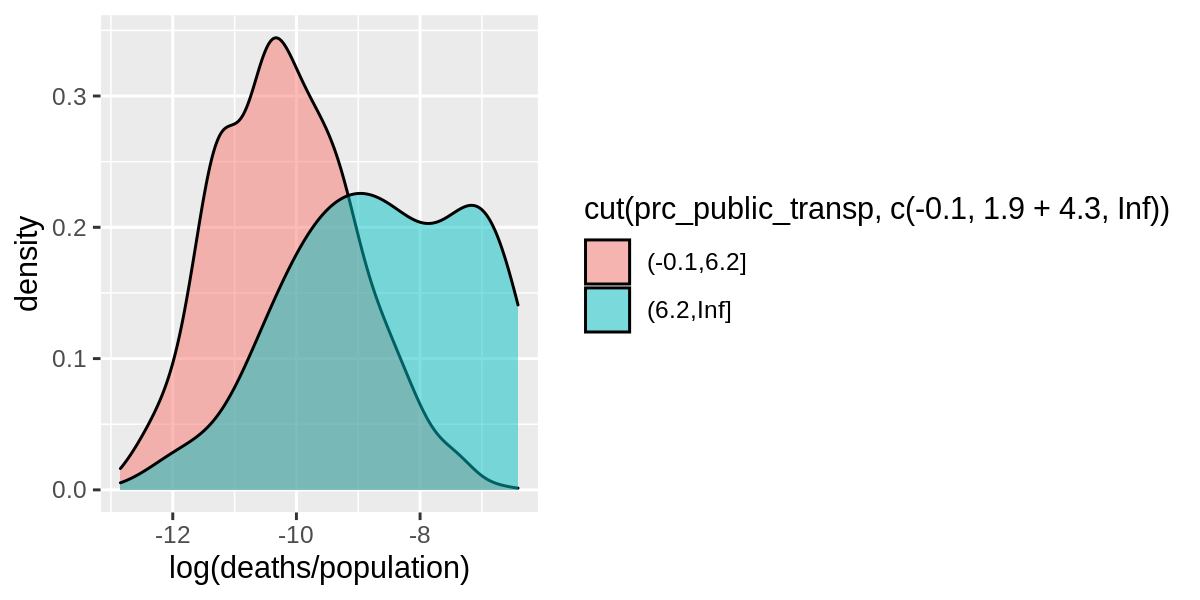

In [123]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(prc_public_transp, c(-0.1, 1.9+4.3, Inf)))) + geom_density(alpha=.5)

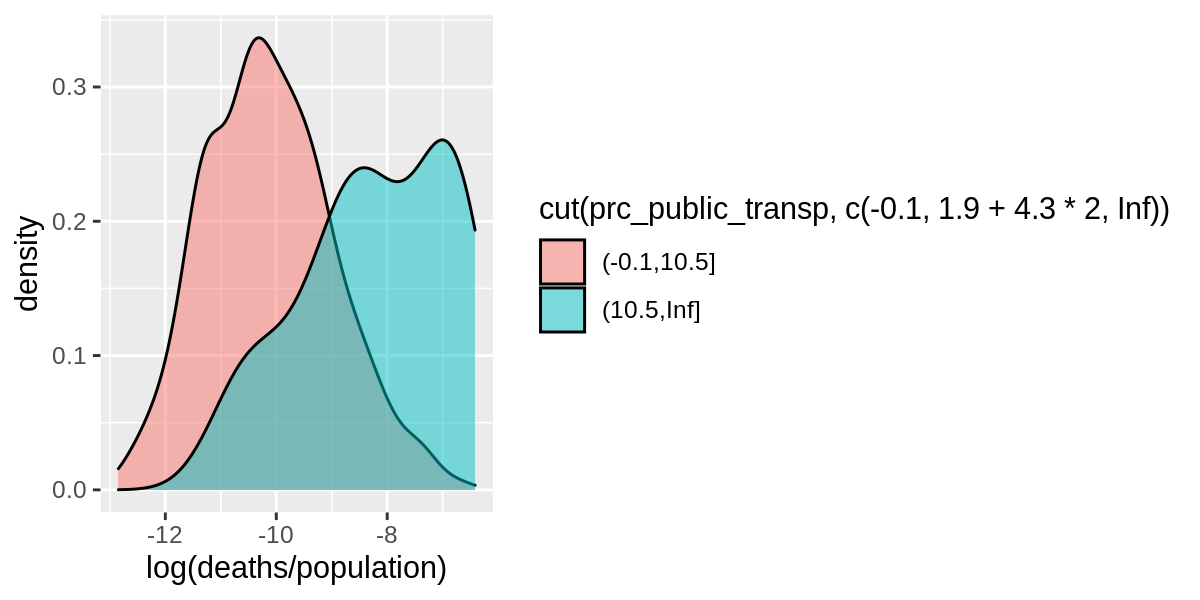

In [124]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(prc_public_transp, c(-0.1, 1.9+4.3*2, Inf)))) + geom_density(alpha=.5)

In [125]:
abbrev["death_prc"] = abbrev["deaths"]/abbrev["population"]

/home/anna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "county". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/anna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "state". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))


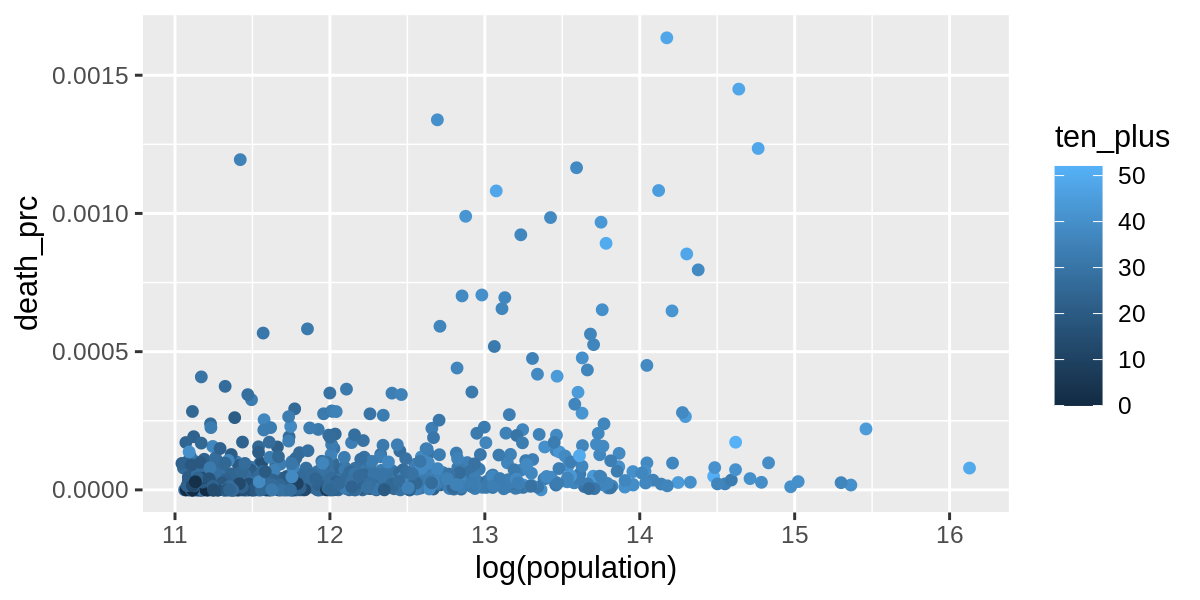

In [126]:
%%R -i abbrev -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(log(population), death_prc, color=ten_plus))

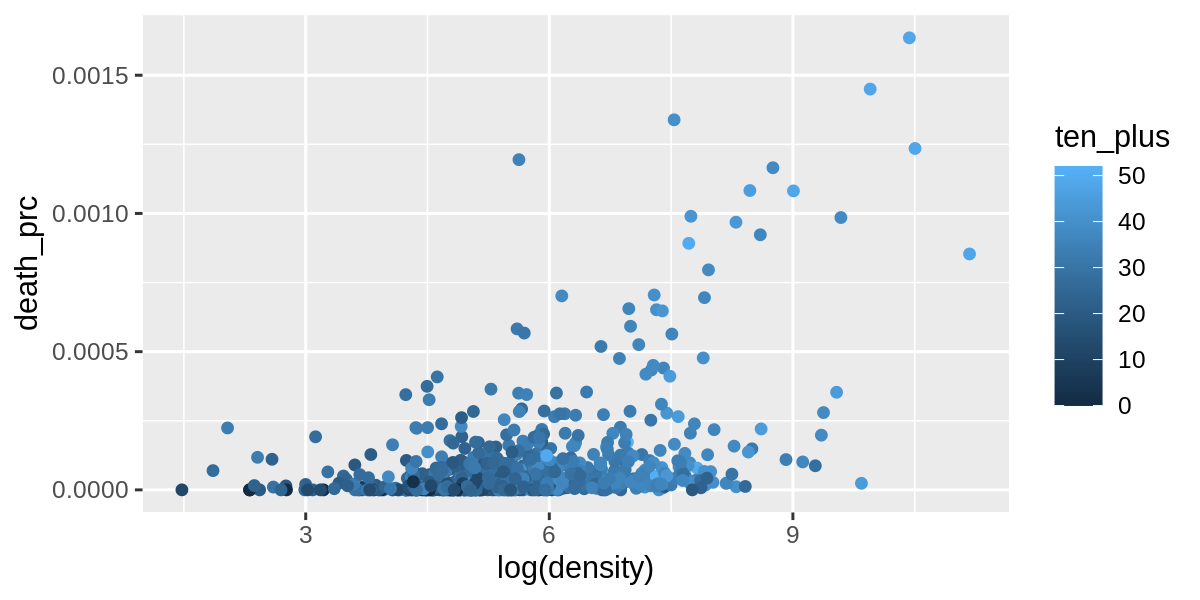

In [127]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(log(density), death_prc, color=ten_plus))

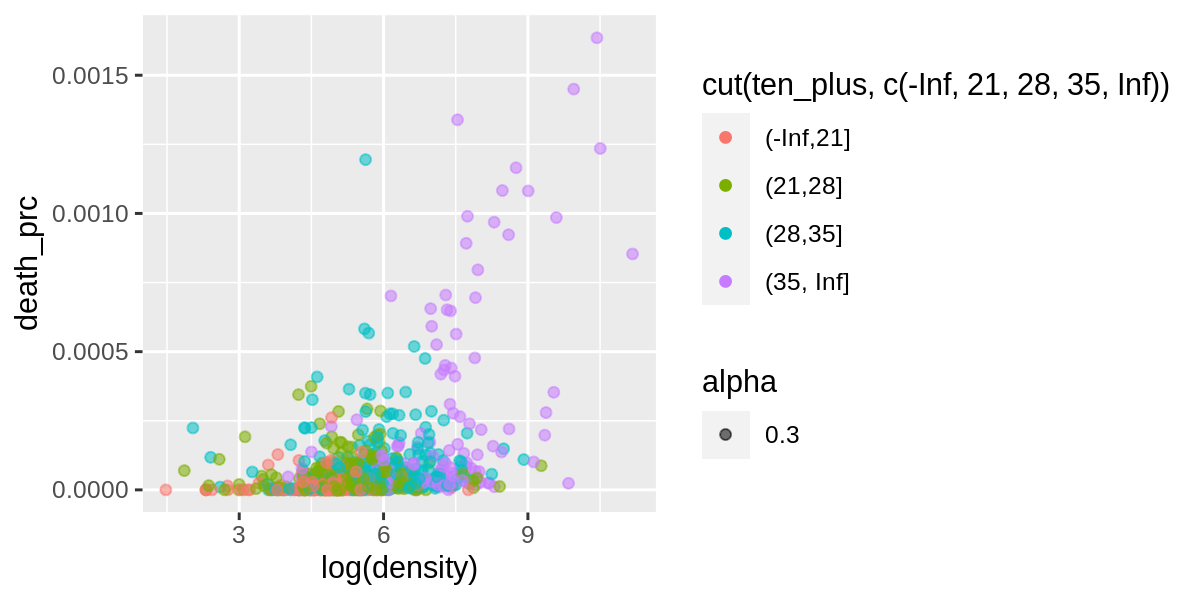

In [128]:
%%R -i abbrev -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(log(density), death_prc, color=cut(ten_plus, c(-Inf, 21, 28, 35, Inf)), alpha=0.3))

### many variables have normal-like distribution

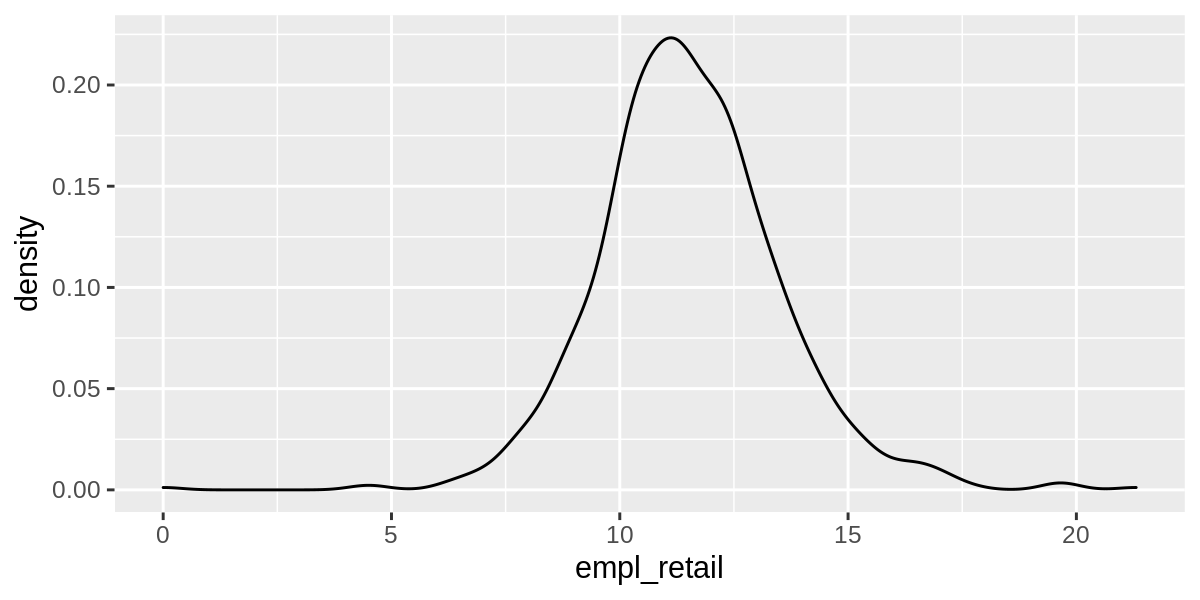

In [316]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(empl_retail)) + geom_density()

### but there are many that aren't very normal-like and will try transforming them (log transform)

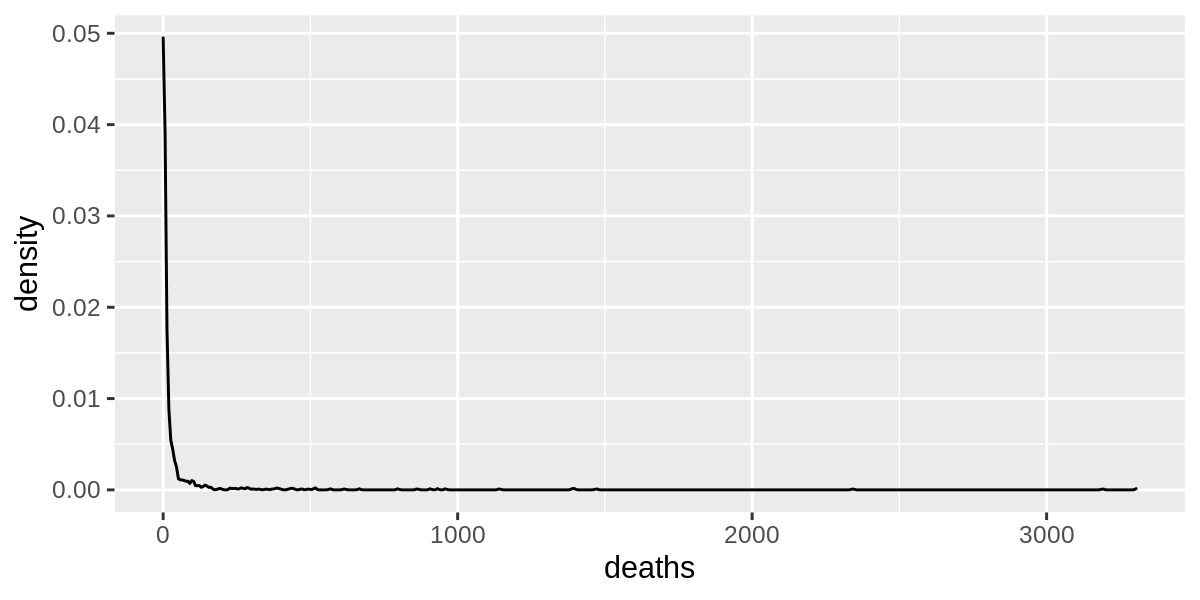

In [353]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(deaths)) + geom_density()

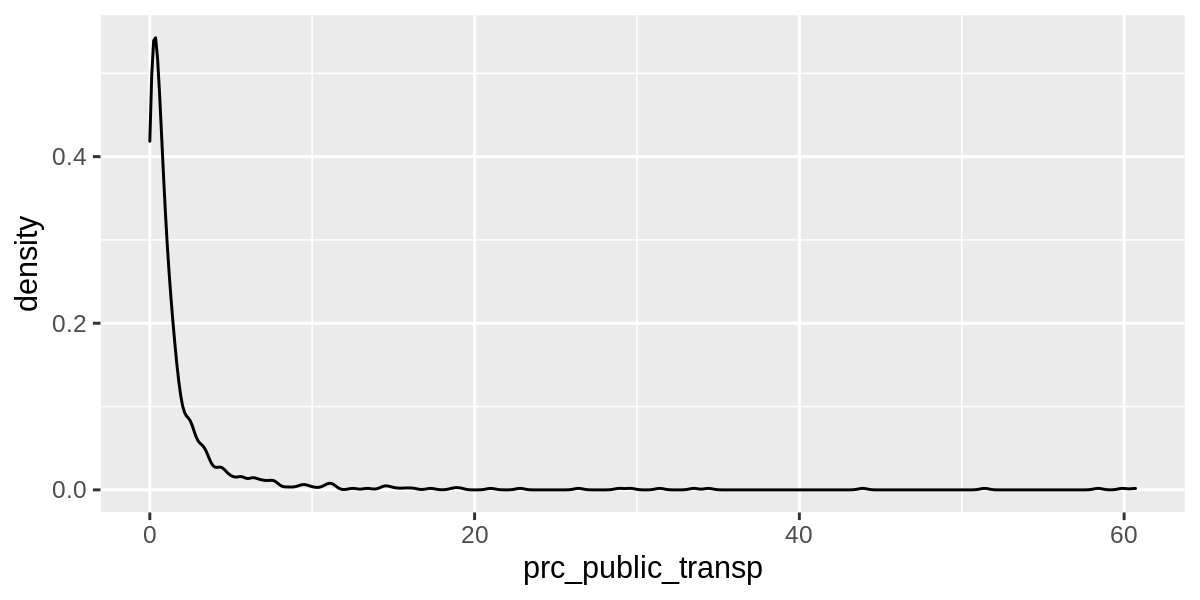

In [322]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(prc_public_transp)) + geom_density()

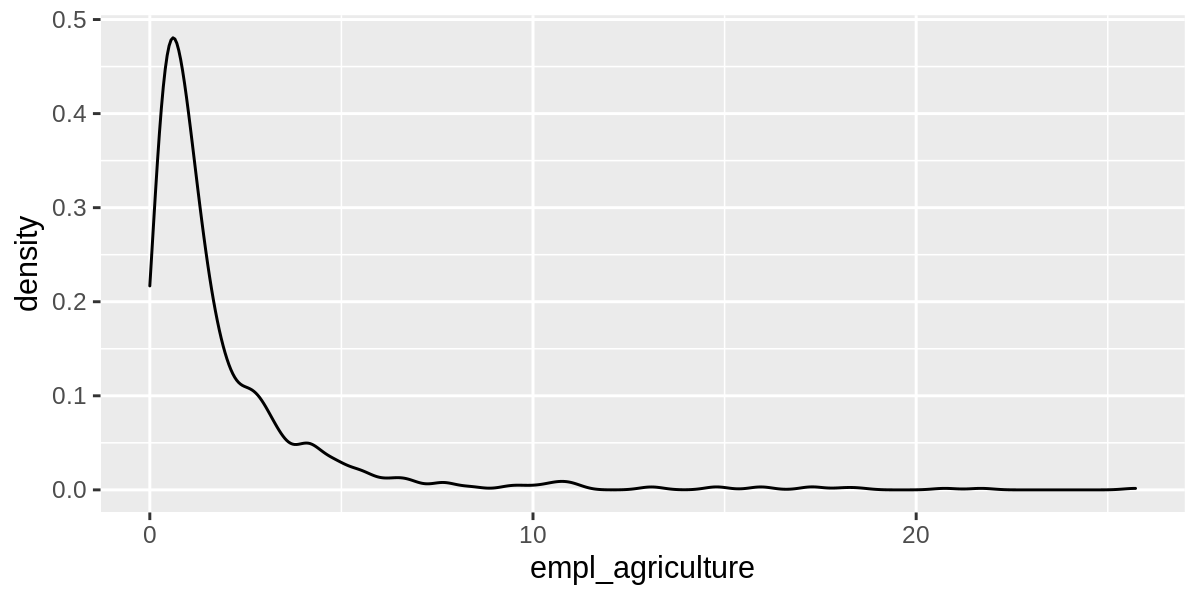

In [302]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(empl_agriculture)) + geom_density()

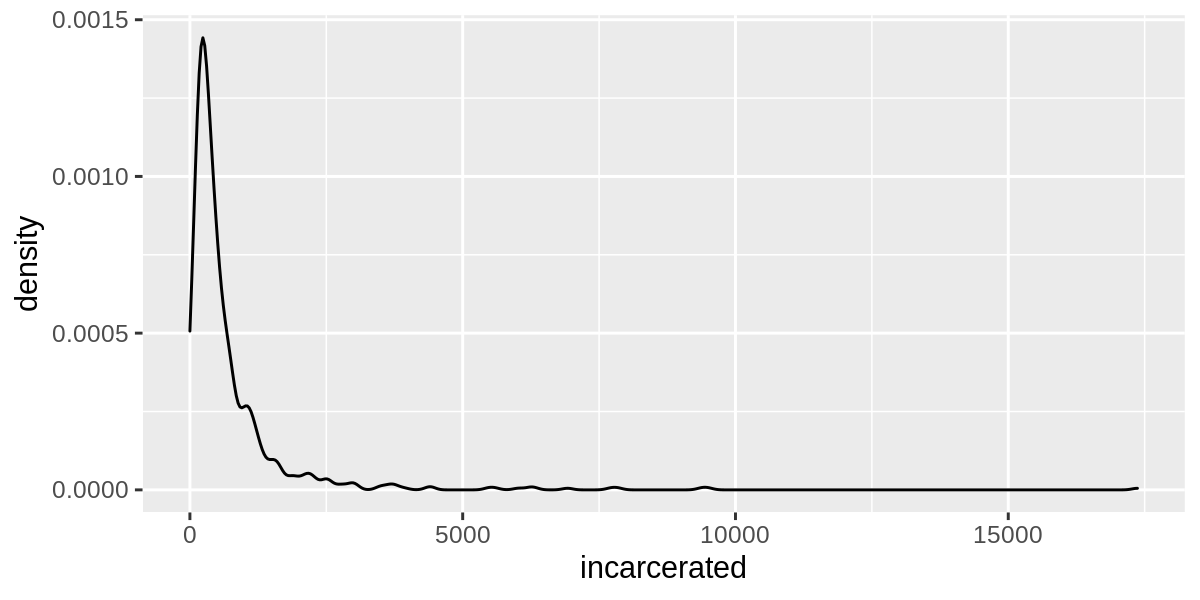

In [299]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(incarcerated)) + geom_density()

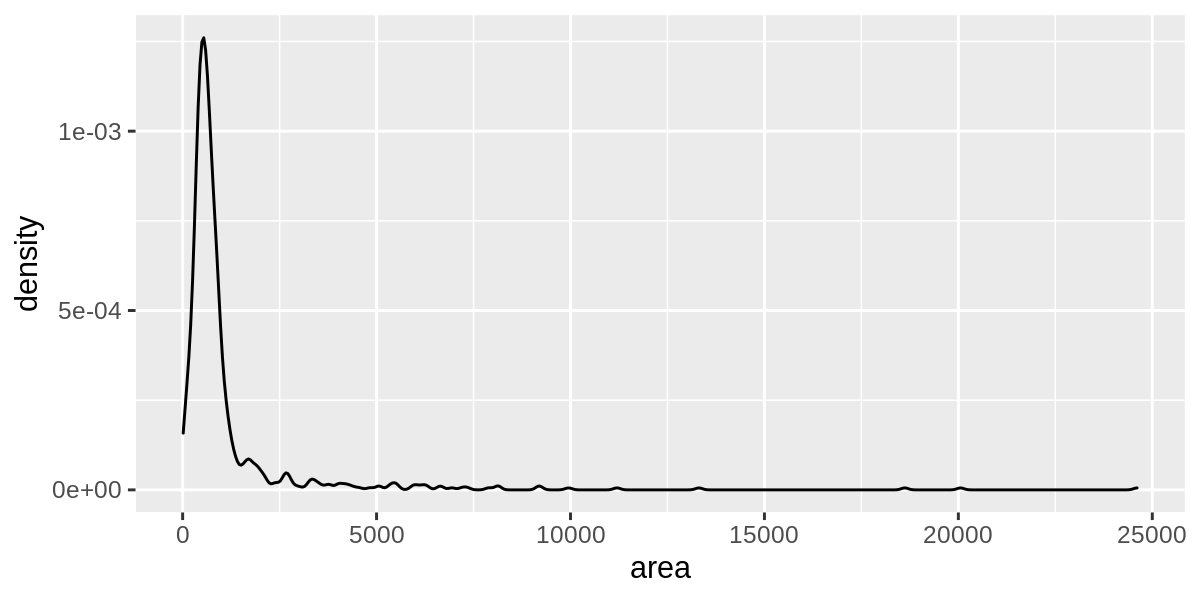

In [296]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(area)) + geom_density()

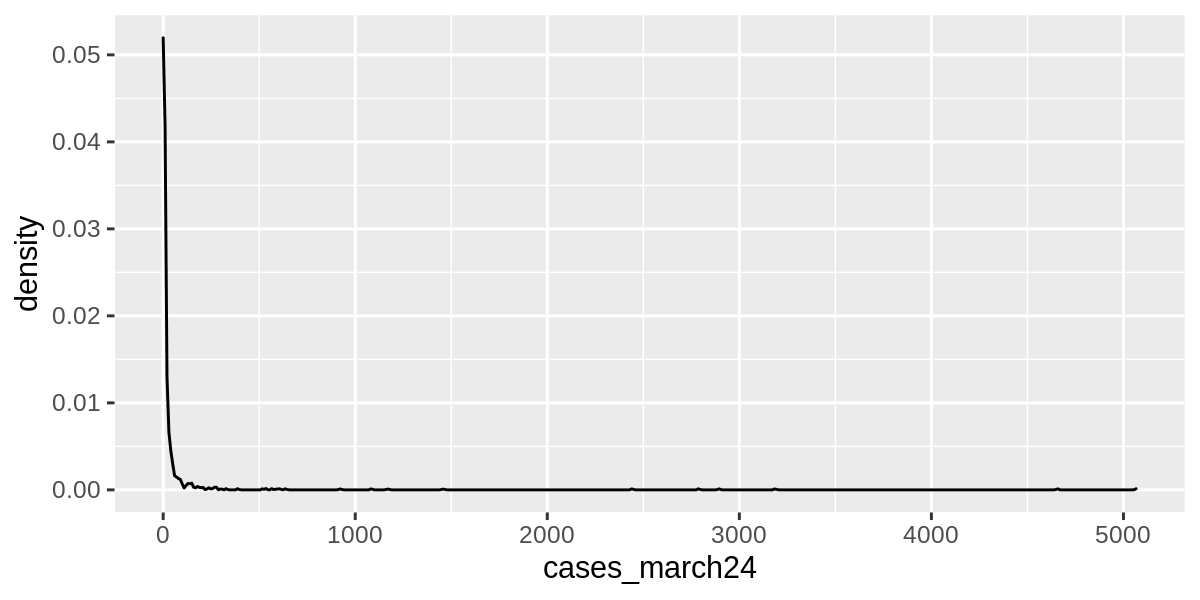

In [294]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cases_march24)) + geom_density()

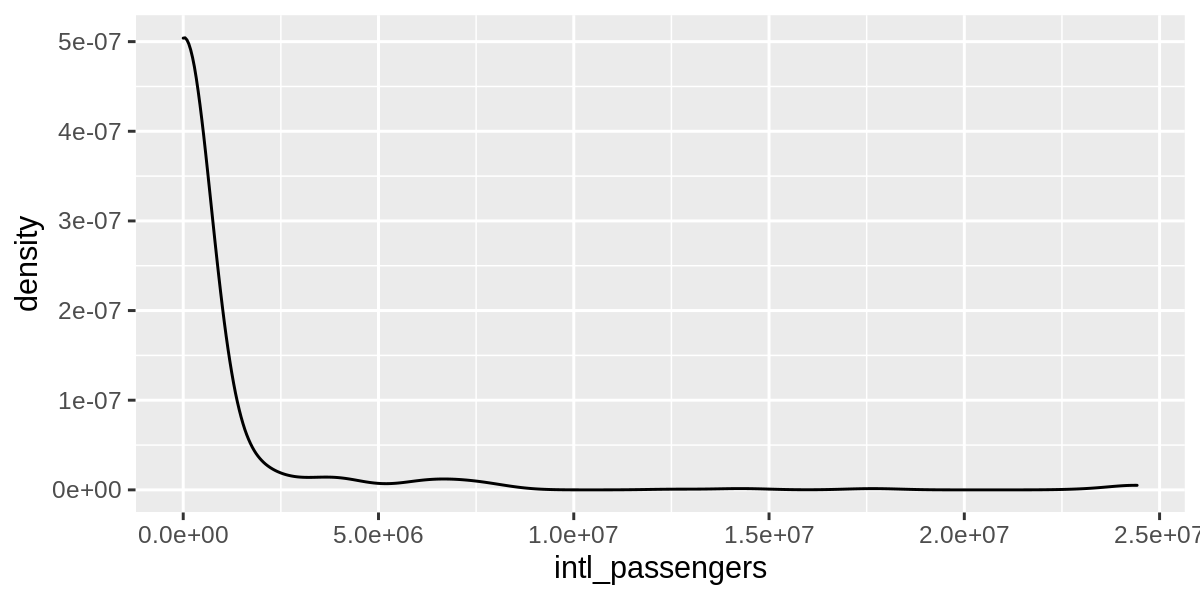

In [293]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(intl_passengers)) + geom_density()

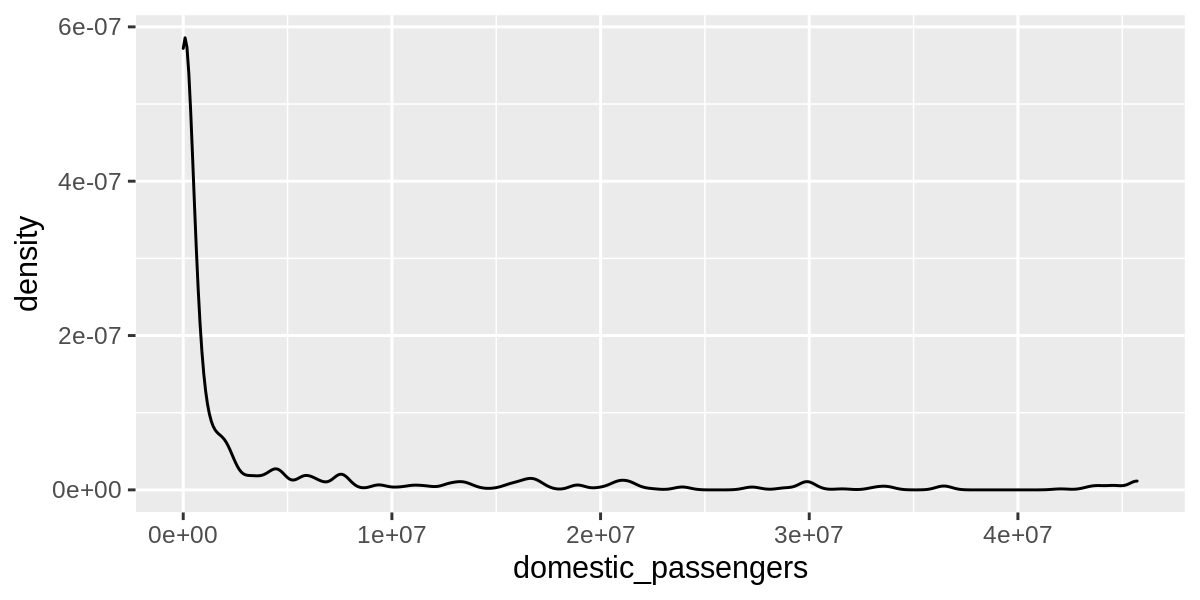

In [292]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(domestic_passengers)) + geom_density()

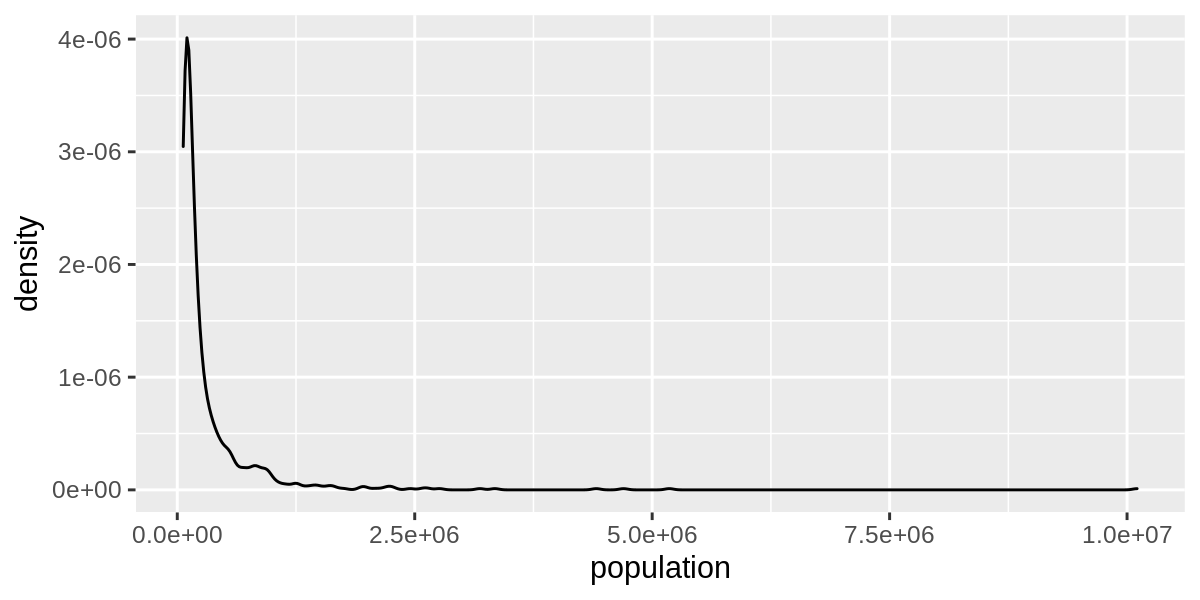

In [283]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(population)) + geom_density()

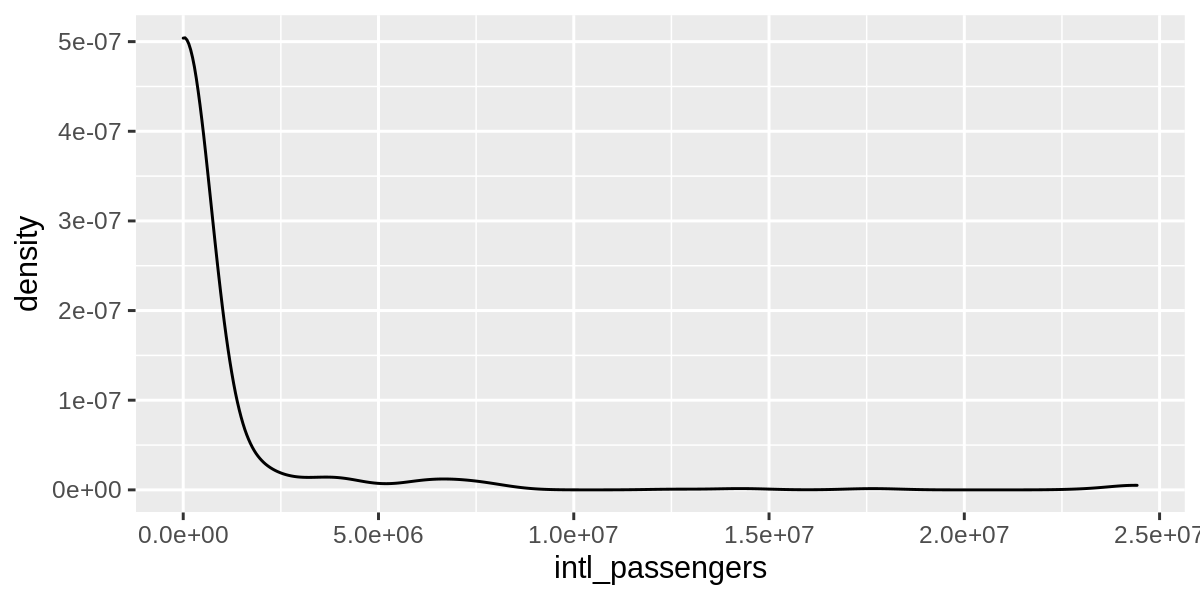

In [304]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(intl_passengers)) + geom_density()

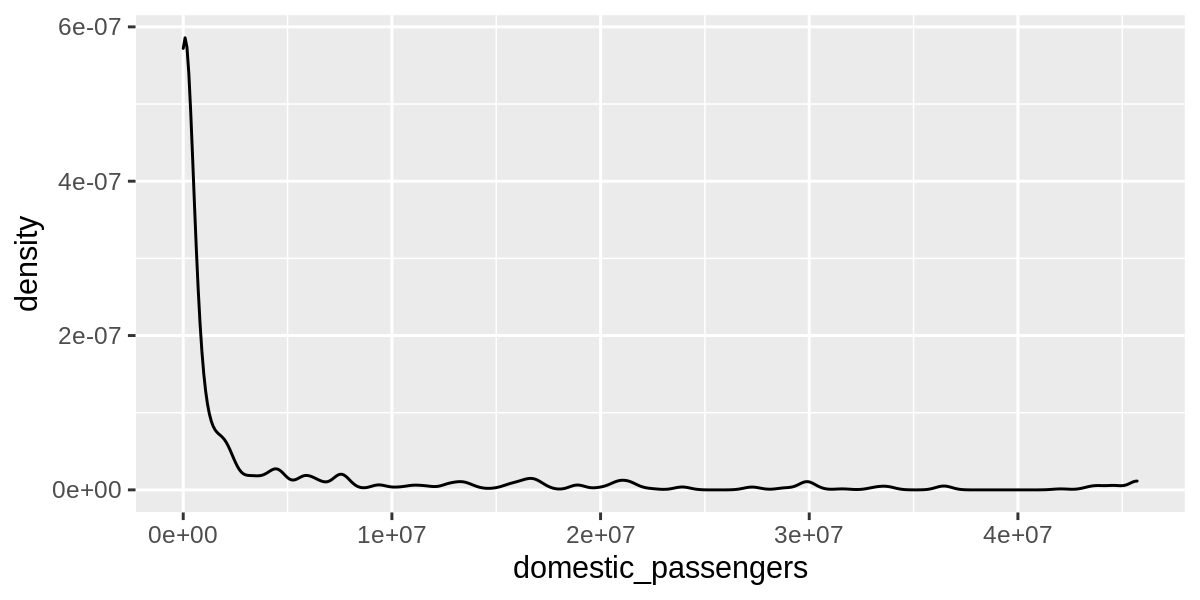

In [289]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(domestic_passengers)) + geom_density()

#### one very left-skewed variable is healh_ins (will transform to prc_uninsured so can apply log transform)

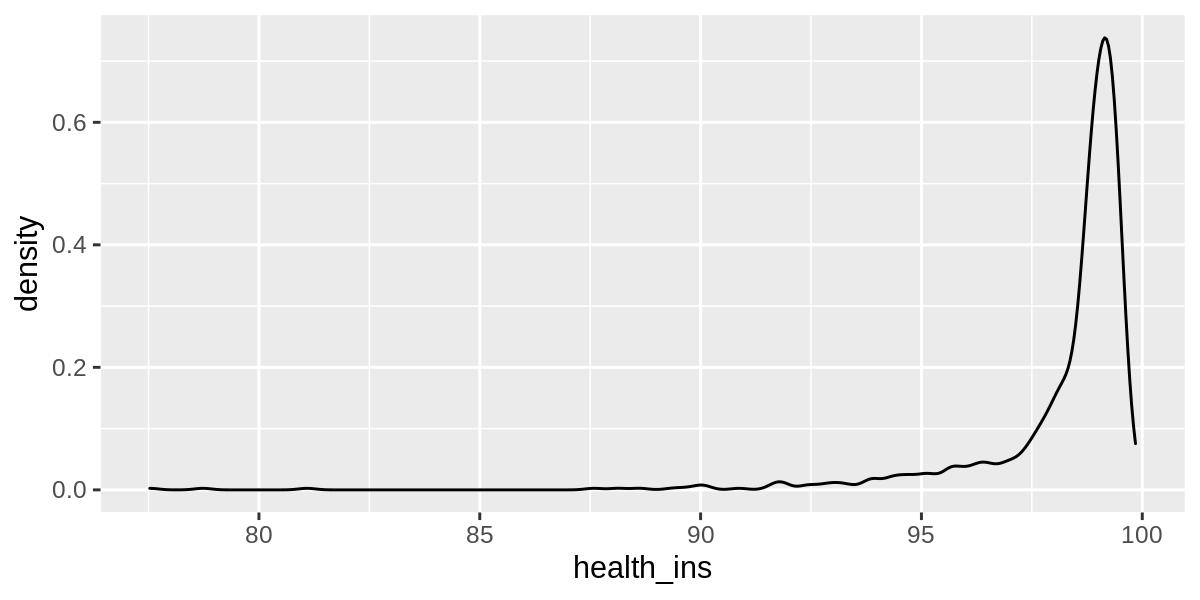

In [348]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(health_ins)) + geom_density()

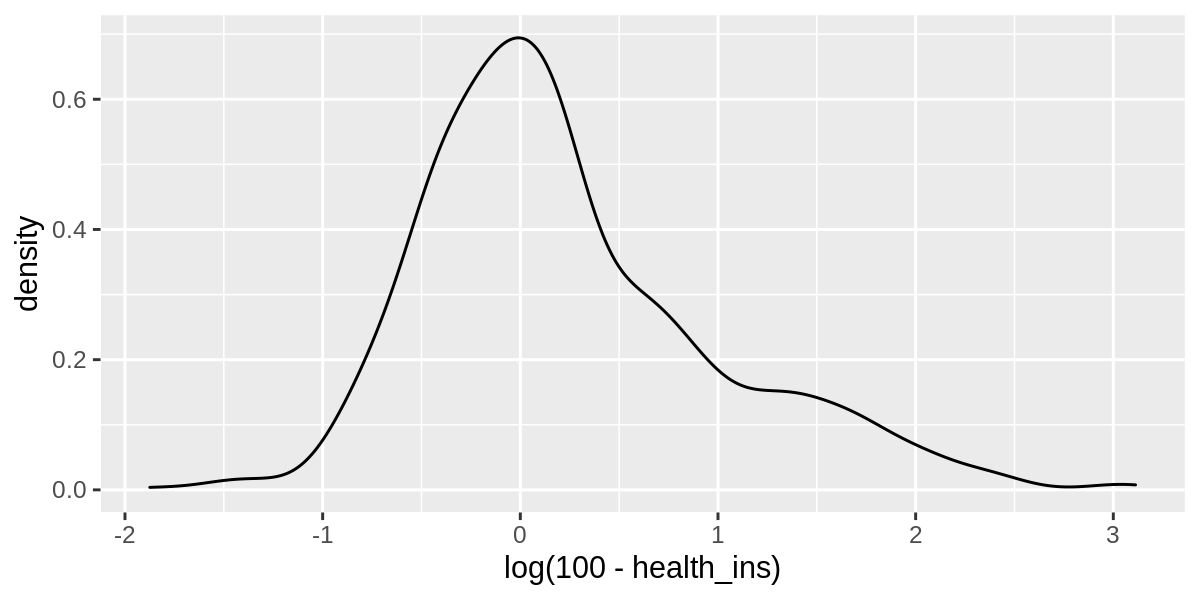

In [347]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(log(100-health_ins))) + geom_density()

### More Multivariate Plots

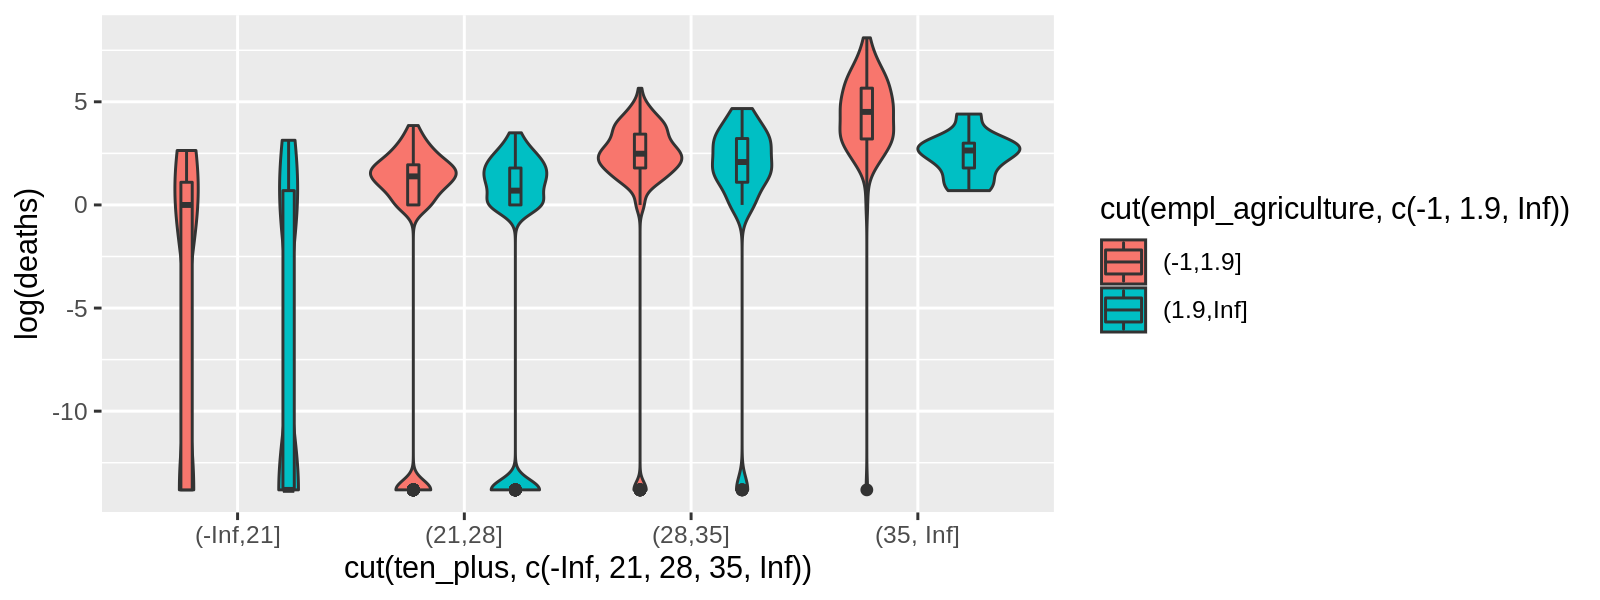

In [130]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 21, 28, 35, Inf)), log(deaths), fill=cut(empl_agriculture, c(-1, 1.9, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

# more agriculture is more rural...

In [131]:
abbrev[(abbrev["death_prc"] < 0.001) & (np.log(abbrev["density"]) > 8)][['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
       'empl_transp_utilities', 'prc_fam_poverty', 'avg_income',
       'prc_public_transp', 'population', 'pop_65_plus', 'health_ins',
        'area', 'prc_obese', 'incarcerated','domestic_passengers', 'intl_passengers']]

# all of these have an airport within 20 miles getting at least domestic passengers (most also intl.)


household_size  empl_agriculture  empl_professional  empl_social  \
37              2.4           8.1e-02               16.8         30.6   
59              2.5           1.1e-01               16.8         18.2   
91              2.8           7.2e-01               14.5         17.2   
154             2.4           3.2e-01               12.7         30.7   
165             2.0           3.2e-01               13.1         29.4   
215             2.2           2.9e-02               23.4         16.7   
237             3.0           6.5e-01               14.7         19.2   
273             2.6           5.0e-01               11.1         28.2   
339             2.4           1.1e-01               25.2         18.0   
343             2.3           1.0e+00               18.8         20.3   
347             2.3           3.1e-01               23.9         18.8   
357             2.6           2.1e-01               14.9         23.1   
429             2.4           1.3e-01               10.5         23.9   
489             2.1           1.2e-01               21.6         23.2   
513             2.5           1.7e-01               12.3         31.4   
529             2.1           2.9e-01               28.0         14.6   
553             2.4           2.2e-01               14.6         21.3   
584             2.9           9.9e-02               13.2         23.2   
608             2.6           2.3e-01               12.6         29.7   
720             2.4           1.9e-01               15.3         24.6   
775             2.7           1.9e-01               13.4         25.8   
824             2.4           3.2e-01               10.7         26.3   

     empl_services  empl_manufacturing  empl_retail  empl_transp_utilities  \
37            10.3                 4.9          8.7                    4.0   
59             9.5                 6.3         10.4                    6.9   
91             9.4                 8.4         10.6                    7.1   
154            9.2                 4.5          8.8                    6.3   
165           12.3                 8.2          7.9                    5.3   
215            9.6                 3.3          6.2                    4.8   
237           11.1                11.6         10.5                    3.9   
273            9.5                11.7          9.8                    5.1   
339           10.6                 5.3          9.3                    4.5   
343            9.7                 5.2          9.4                    4.3   
347            9.7                 1.3          4.4                    3.4   
357            9.5                 9.5          9.5                    7.7   
429           12.9                 6.4         12.6                    4.2   
489           10.4                 2.5          6.5                    2.8   
513            9.3                 6.5          9.2                    6.6   
529            6.7                 2.9          4.6                    2.5   
553           11.1                 7.1         12.8                    4.5   
584            6.3                 8.1         11.0                    9.8   
608            8.3                 7.3         10.2                    6.2   
720           10.9                 6.7         10.8                    3.7   
775            6.5                 7.8         10.7                    4.8   
824            9.1                14.8         11.2                    5.9   

     prc_fam_poverty  avg_income  prc_public_transp  population  pop_65_plus  \
37              11.8       41657               31.4      807252         12.0   
59              11.6       42150               43.9      676061         11.8   
91              10.8       32467                2.5     2637772         10.7   
154             13.9       31433               16.2      602495         14.0   
165             17.0       31537               10.1      302838         13.8   
215              9.9       61158               18.

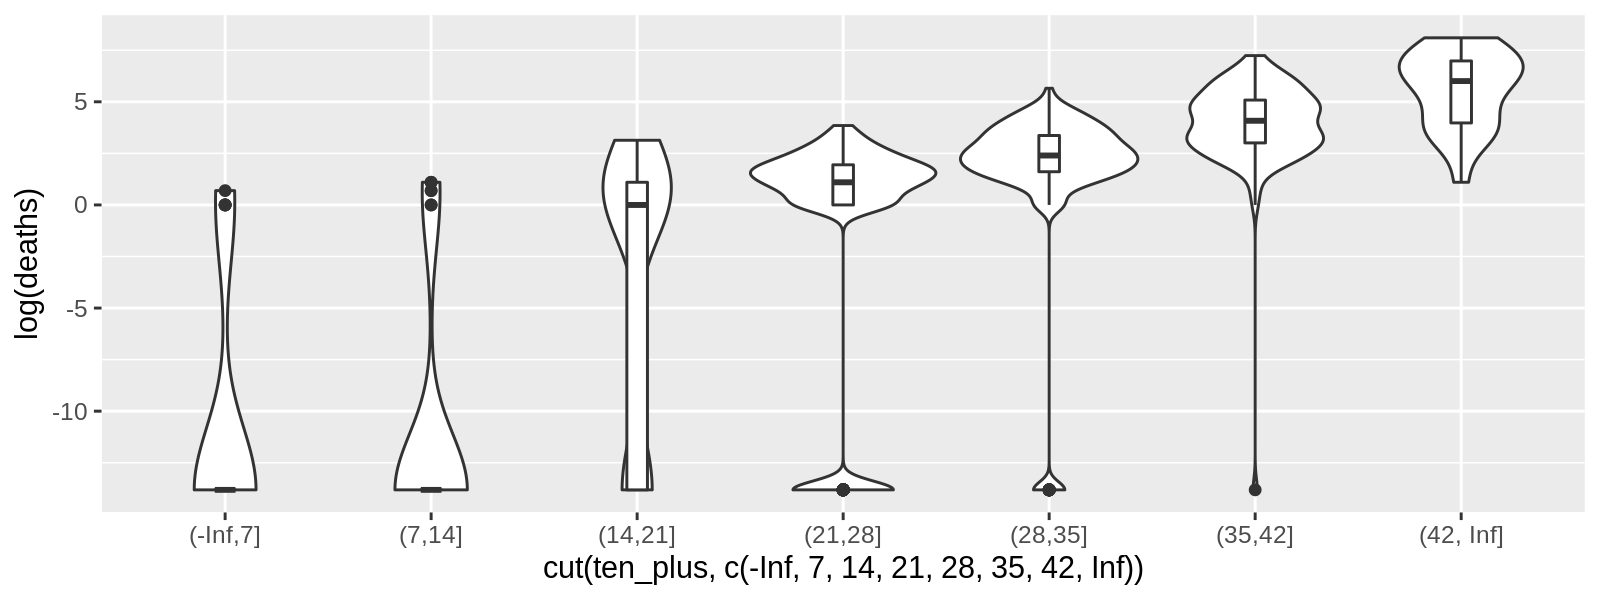

In [132]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 7, 14, 21, 28, 35, 42, Inf)), log(deaths))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

# the more that has elapsed since the first 10+ cases identified, on average higher number of deaths

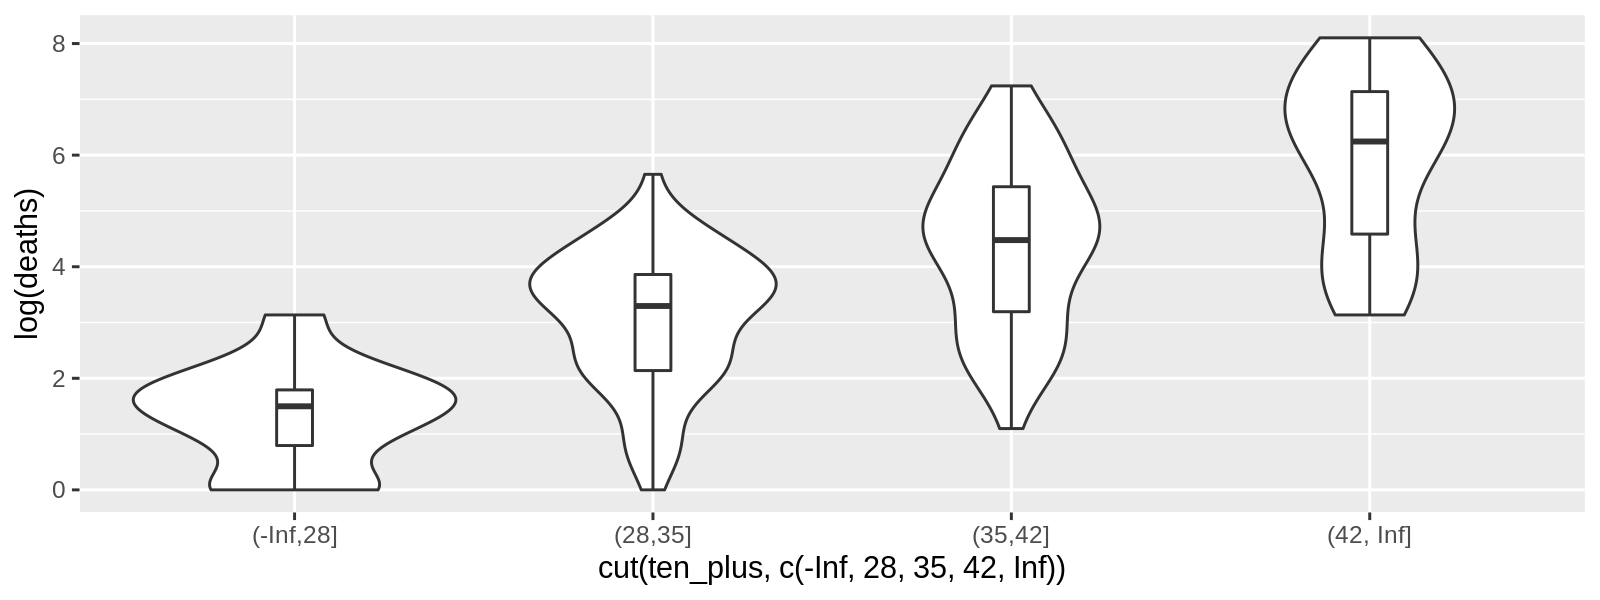

In [268]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev[abbrev$deaths_march24 > 0,], aes(cut(ten_plus, c(-Inf, 28, 35, 42, Inf)), log(deaths))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

# again, pretty obvious: once have any deaths, the more time that passes on average there is a higher number of deaths

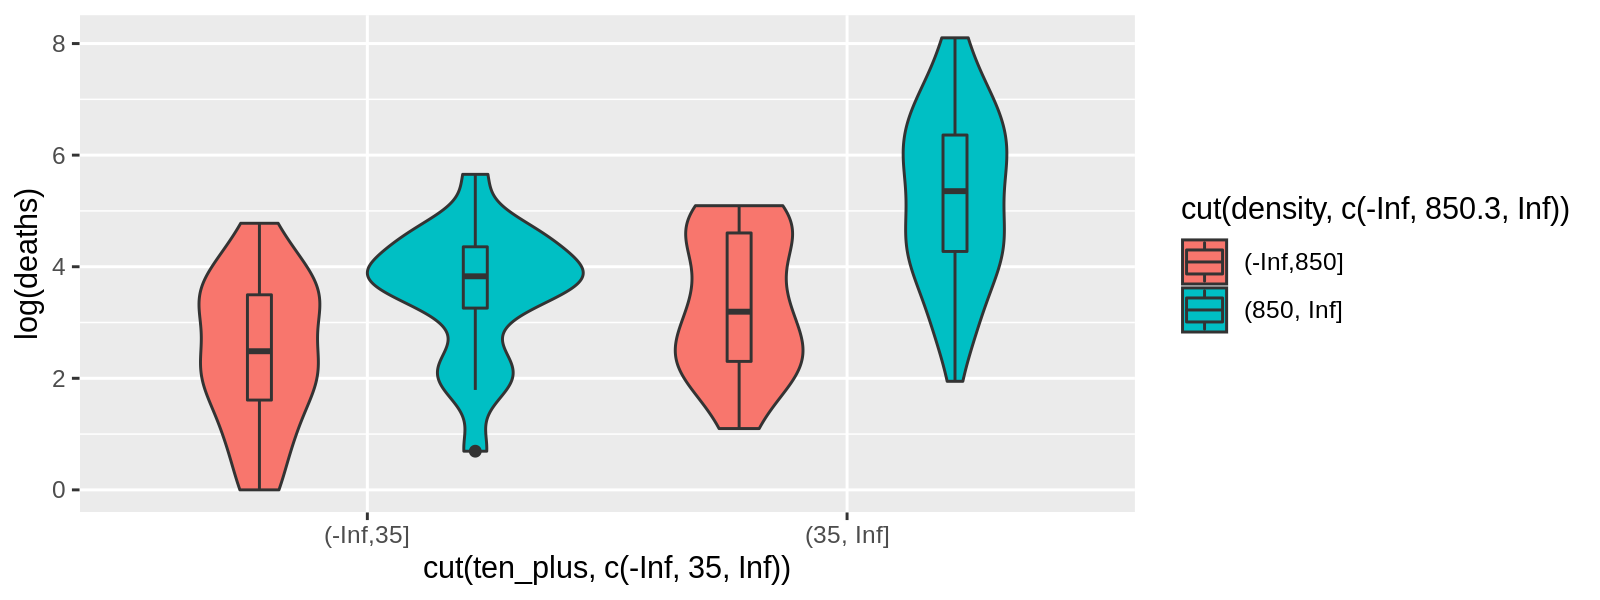

In [274]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev[abbrev$deaths_march24 > 0,], aes(cut(ten_plus, c(-Inf,  35, Inf)), log(deaths), fill=cut(density, c(-Inf, 850.3, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

# density important

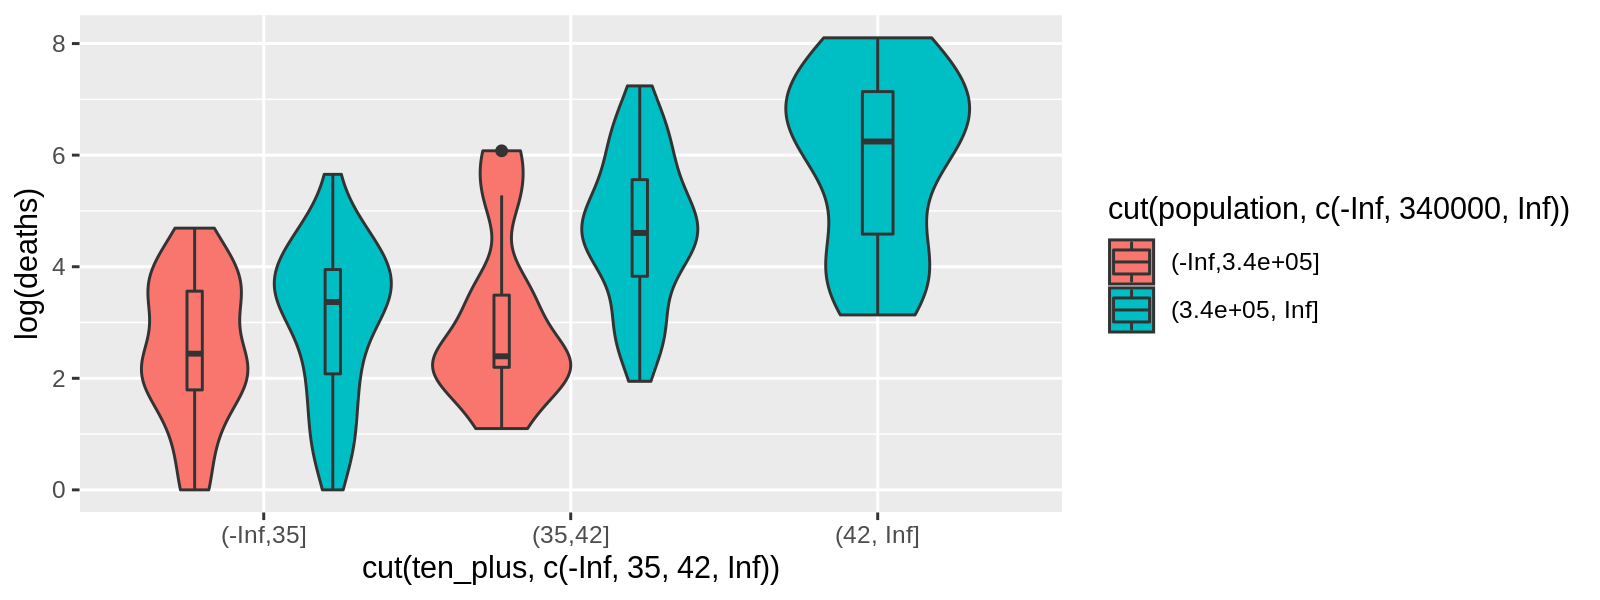

In [278]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev[abbrev$deaths_march24 > 0,], aes(cut(ten_plus, c(-Inf,  35, 42, Inf)), log(deaths), fill=cut(population, c(-Inf, 340000, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

# and population

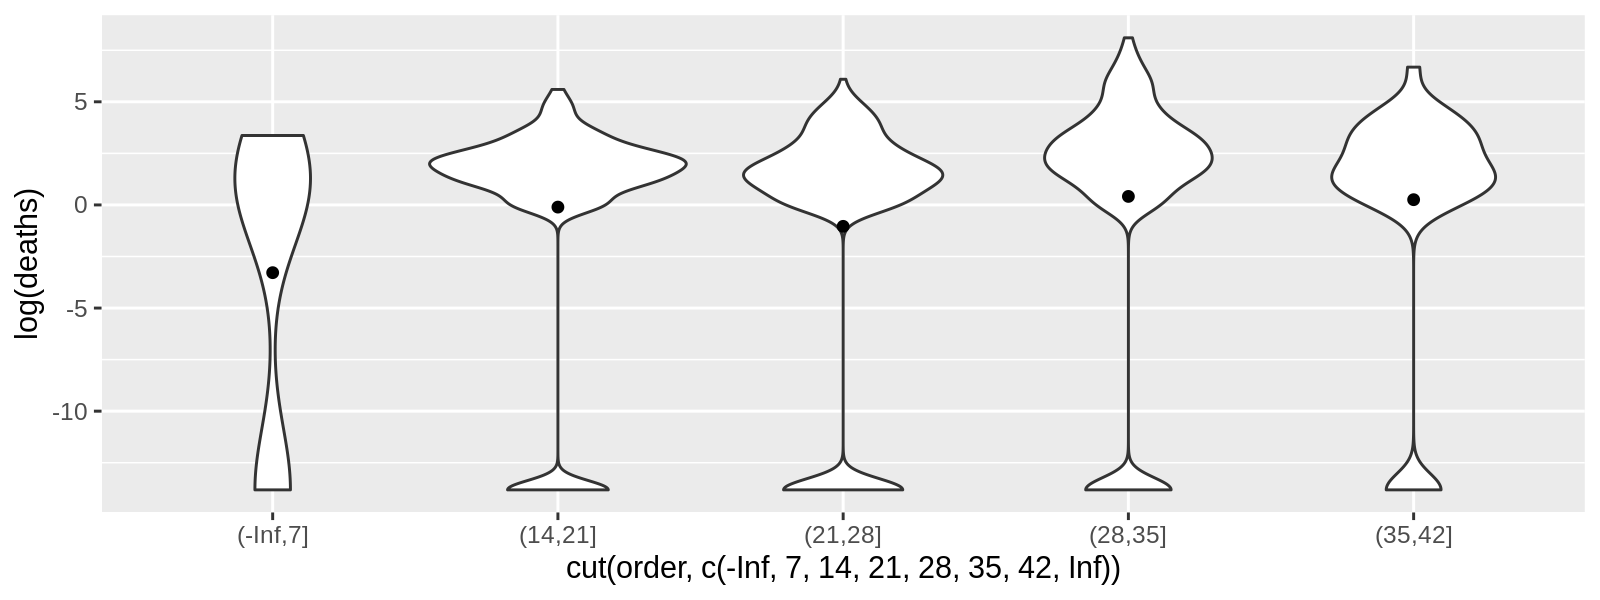

In [254]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(order, c(-Inf, 7, 14, 21, 28, 35, 42, Inf)), log(deaths))) +  
geom_violin() + stat_summary(fun.y="mean", geom="point", position=position_dodge(0.9))

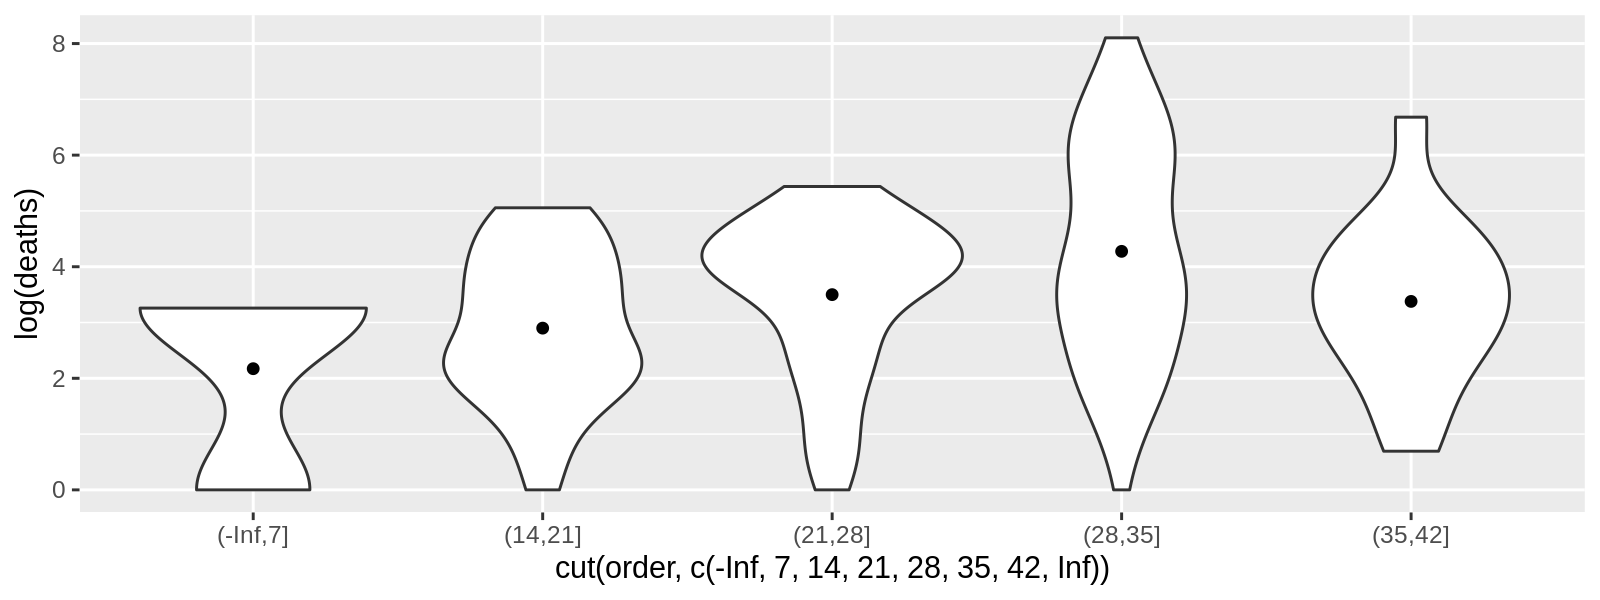

In [270]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev[abbrev$deaths_march24 > 0,], aes(cut(order, c(-Inf, 7, 14, 21, 28, 35, 42, Inf)), log(deaths))) +  
geom_violin() + stat_summary(fun.y="mean", geom="point", position=position_dodge(0.9))

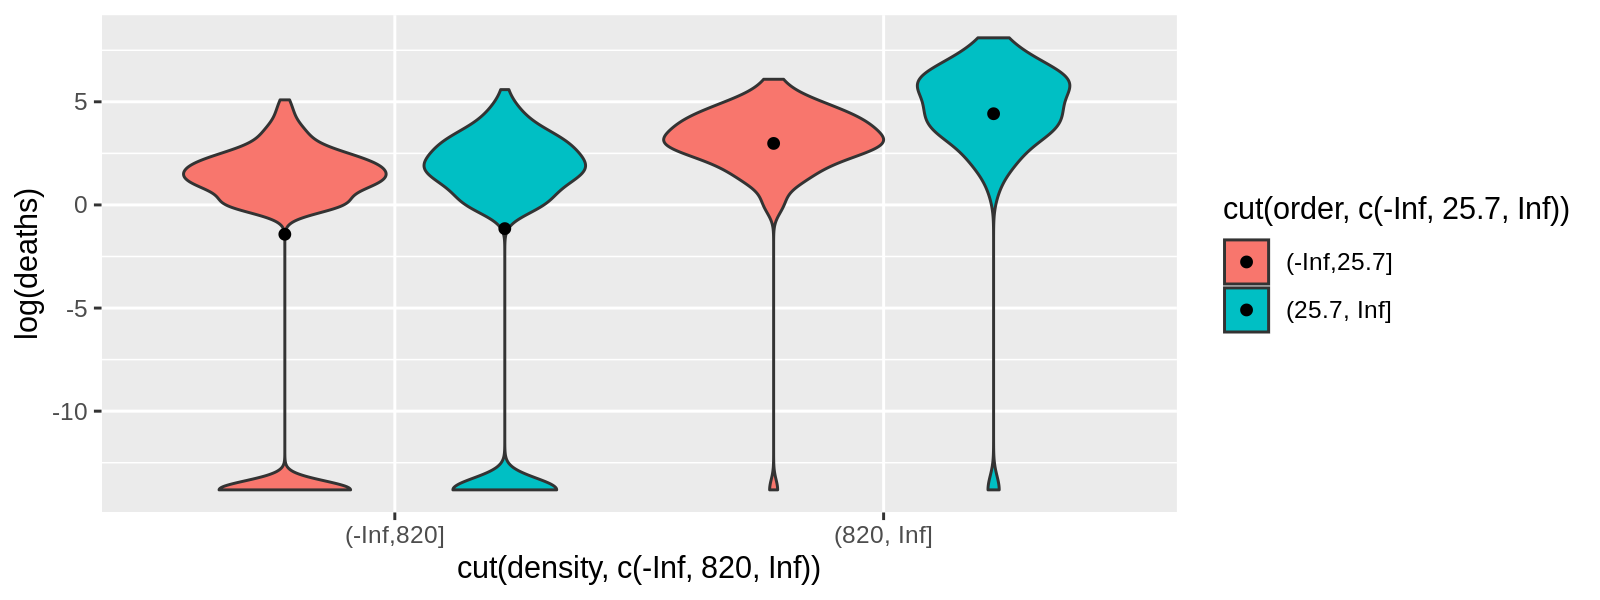

In [251]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(density, c(-Inf, 820, Inf)), log(deaths), fill=cut(order, c(-Inf, 25.7, Inf)))) +  
geom_violin() + stat_summary(fun.y="mean", geom="point", position=position_dodge(0.9))

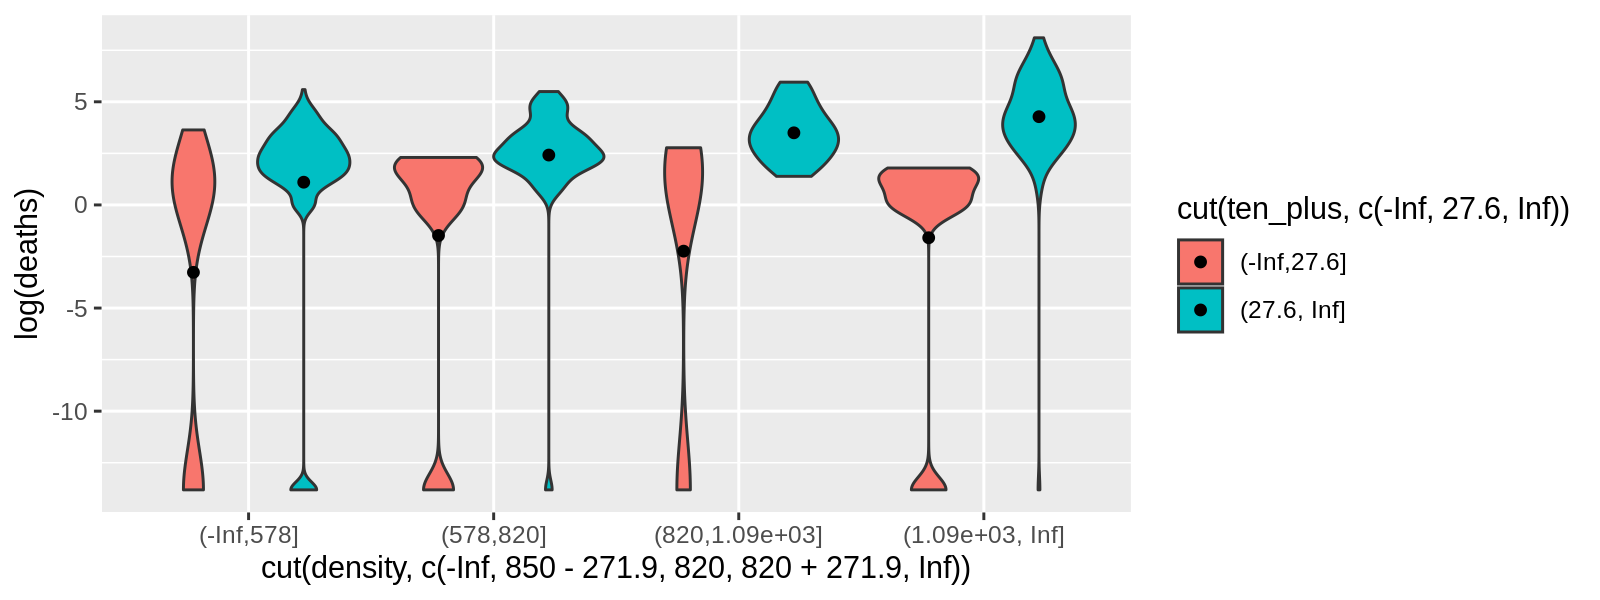

In [231]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(density, c(-Inf, 850-271.9, 820, 820+271.9, Inf)), log(deaths), fill=cut(ten_plus, c(-Inf, 27.6, Inf)))) +  
geom_violin() + stat_summary(fun.y="mean", geom="point", position=position_dodge(0.9))

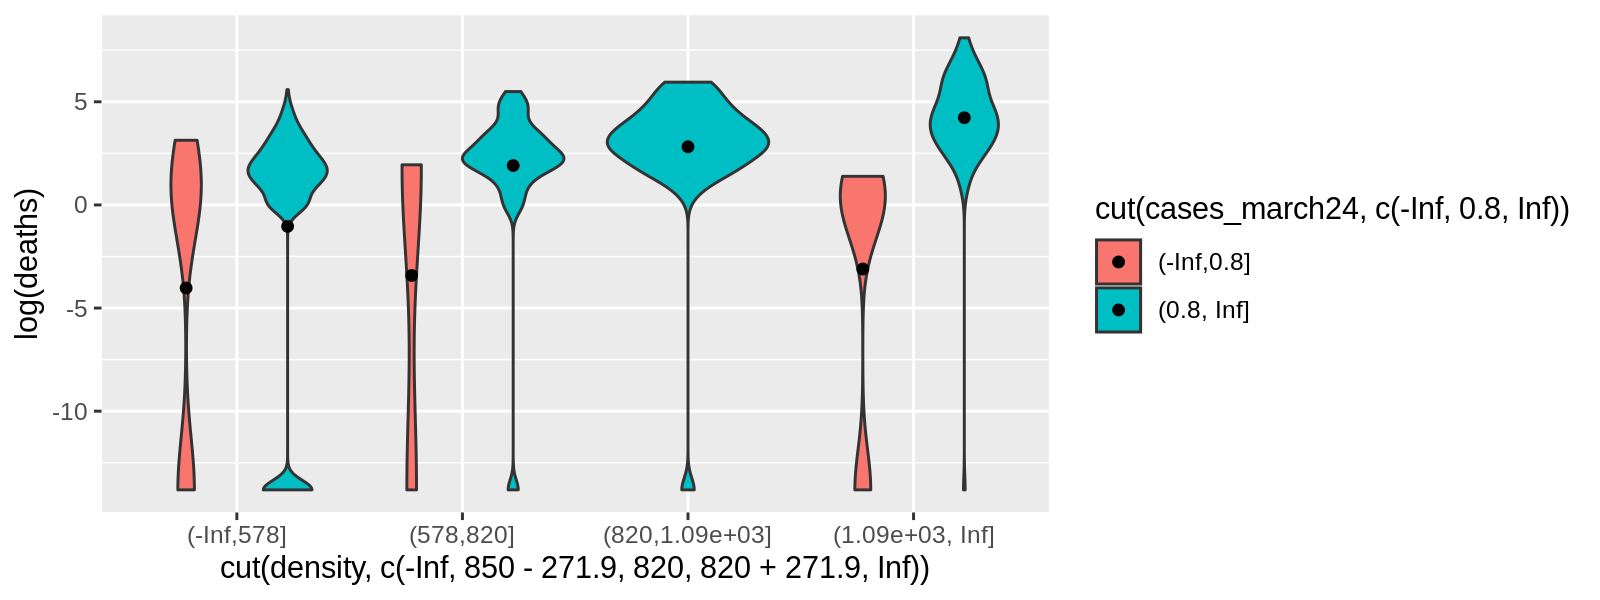

In [225]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(density, c(-Inf, 850-271.9, 820, 820+271.9, Inf)), log(deaths), fill=cut(cases_march24, c(-Inf, 0.8, Inf)))) +  
geom_violin() + stat_summary(fun.y="mean", geom="point", position=position_dodge(0.9))

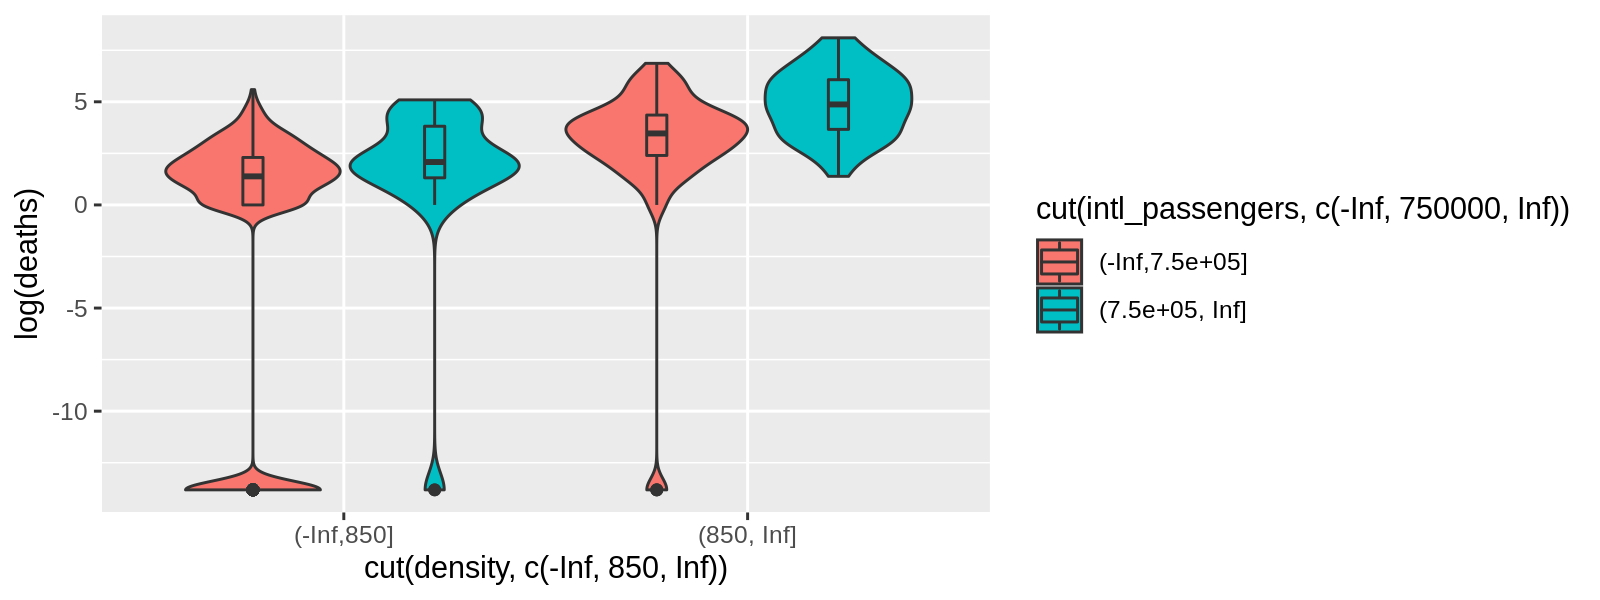

In [213]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(density, c(-Inf, 850, Inf)), log(deaths), fill=cut(intl_passengers, c(-Inf, 750000, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

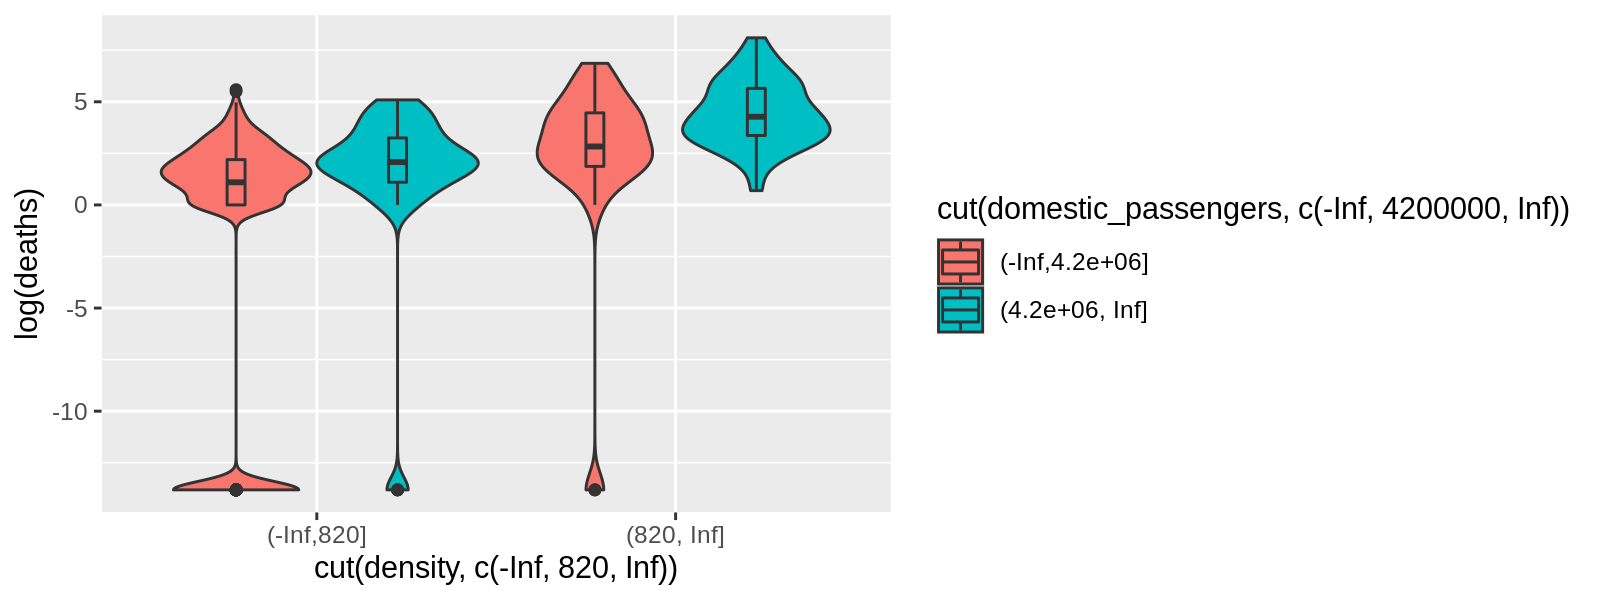

In [203]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(density, c(-Inf, 820, Inf)), log(deaths), fill=cut(domestic_passengers, c(-Inf, 4200000, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

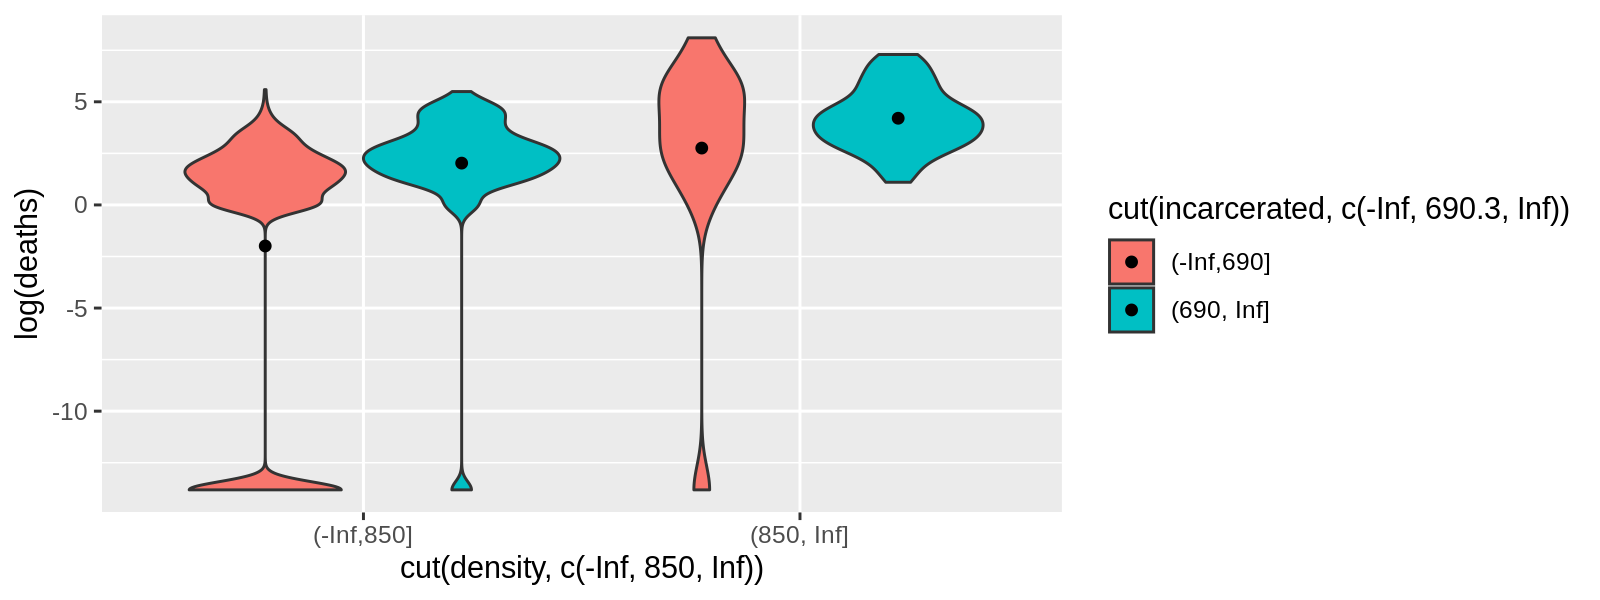

In [193]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(density, c(-Inf, 850, Inf)), log(deaths), fill=cut(incarcerated, c(-Inf, 690.3, Inf)))) +  
geom_violin()  + stat_summary(fun.y="mean", geom="point", position=position_dodge(0.9))

# higher average number of deaths for both <= average density and > avg density, but difference more pronounced when <= avg density
#(b/c of influence large number of counties with no-deaths in the low-incarcerated, <=avg density group, it looks like)

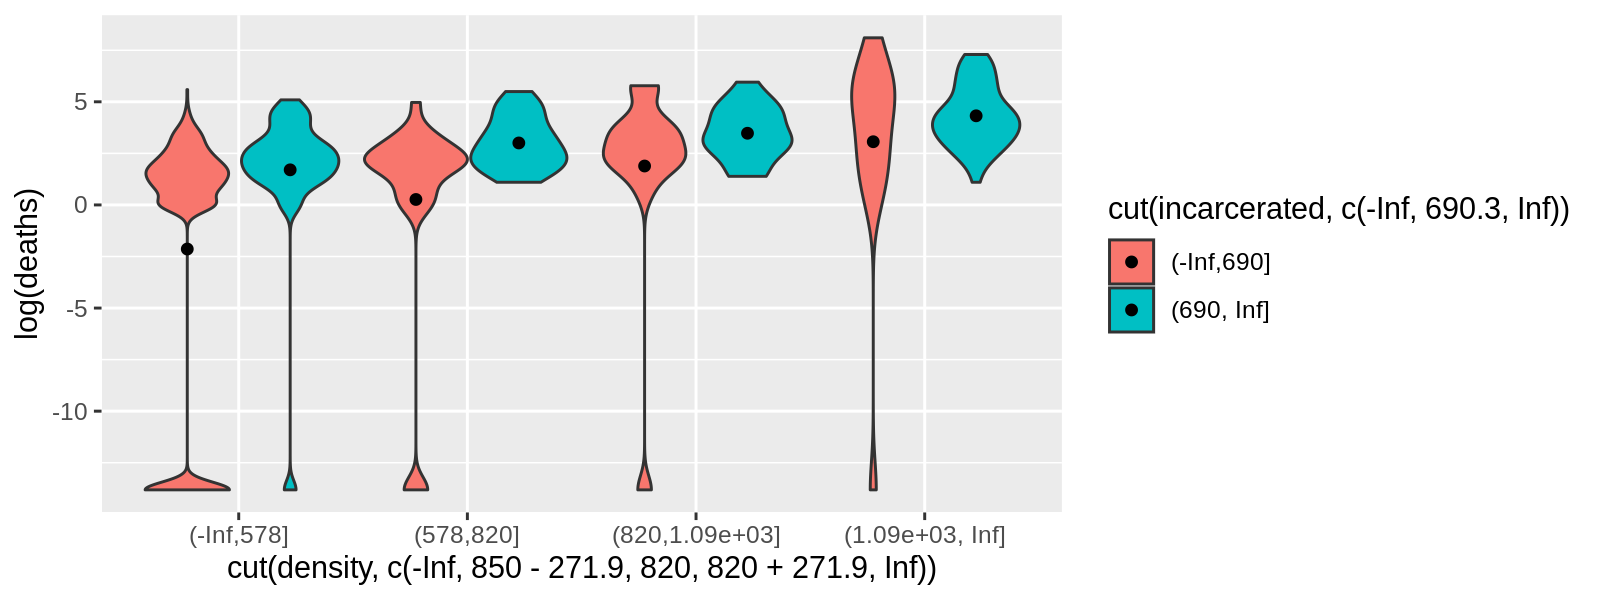

In [195]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(density, c(-Inf, 850-271.9, 820, 820+271.9, Inf)), log(deaths), fill=cut(incarcerated, c(-Inf, 690.3, Inf)))) +  
geom_violin() + stat_summary(fun.y="mean", geom="point", position=position_dodge(0.9))

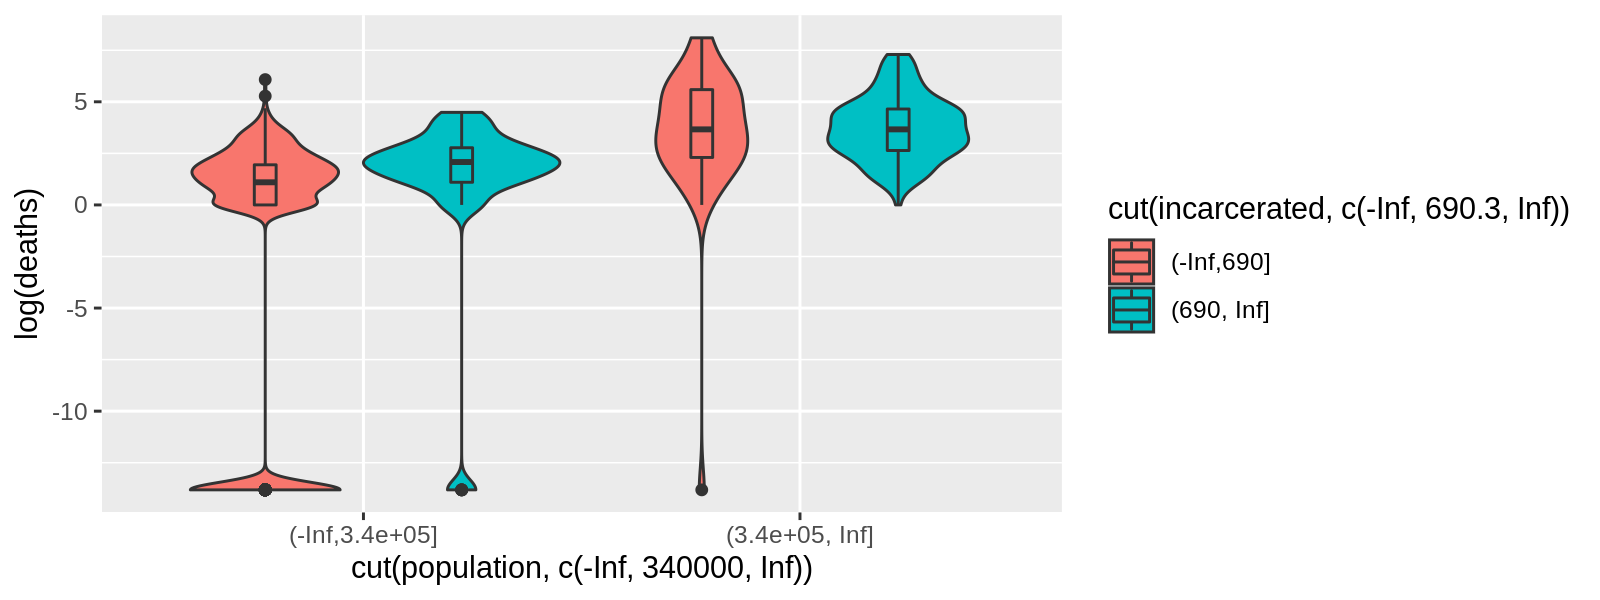

In [188]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(population, c(-Inf, 340000, Inf)), log(deaths), fill=cut(incarcerated, c(-Inf, 690.3, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

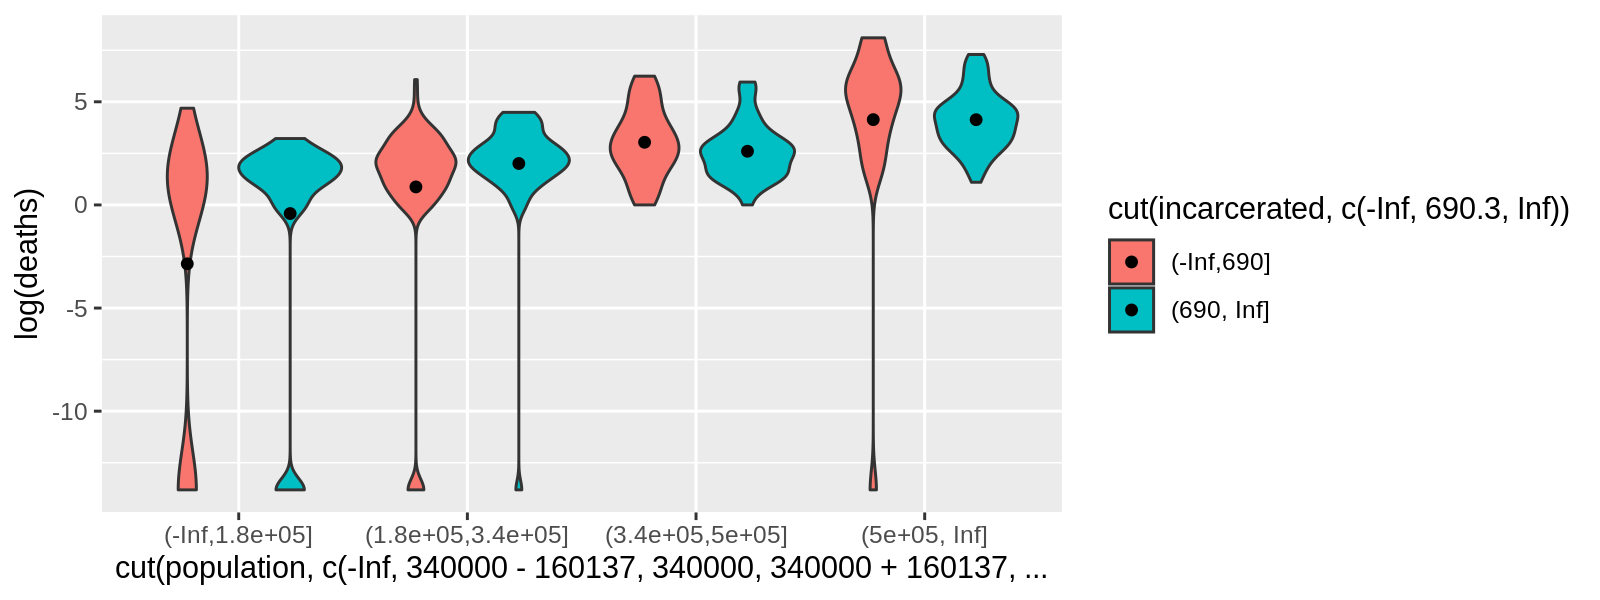

In [192]:
%%R -w 8 -h 3 --units in -r 200


ggplot(abbrev, aes(cut(population, c(-Inf, 340000-160137, 340000, 340000+160137, Inf)), log(deaths), fill=cut(incarcerated, c(-Inf, 690.3, Inf)))) +  
geom_violin() + stat_summary(fun.y="mean", geom="point", position=position_dodge(0.9))

# at lower total population numbers in a county, counties with more than average number of incarcerated individuals have a higher number of covid19 deaths
# not apparently the case at higher population numbers

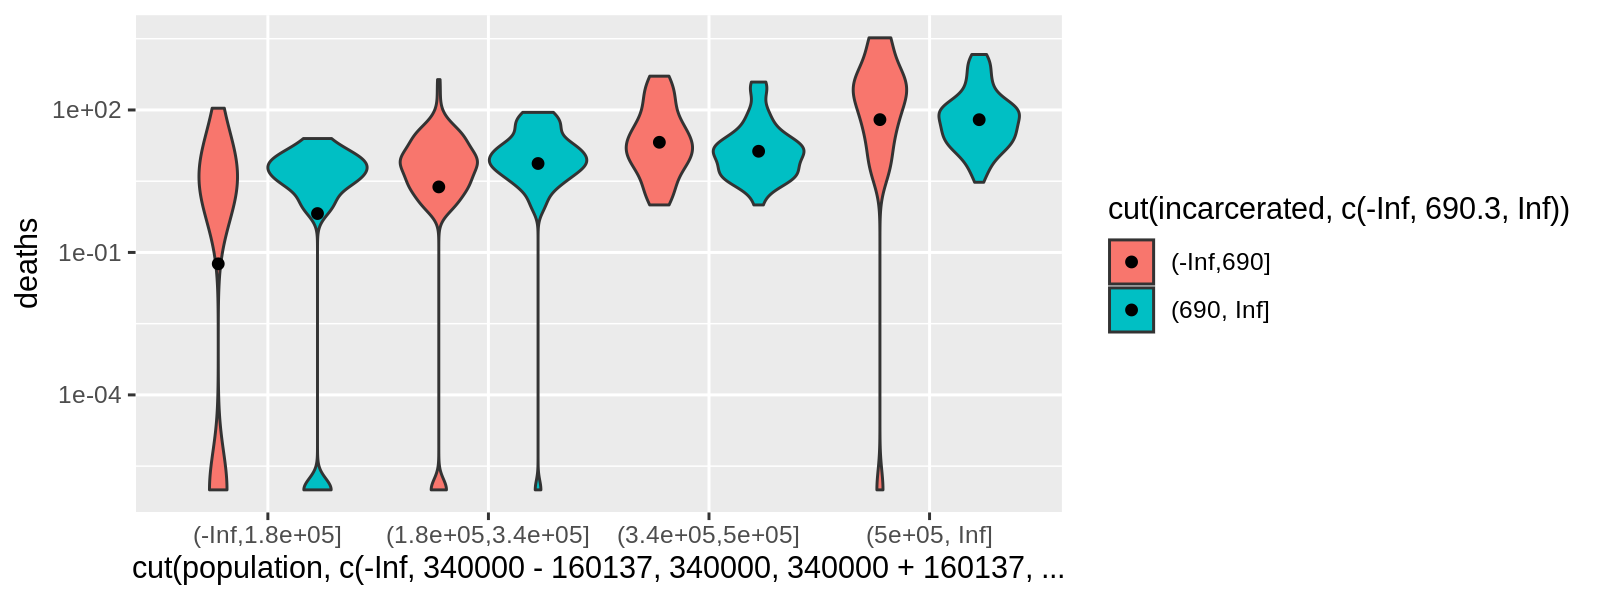

In [187]:
%%R -w 8 -h 3 --units in -r 200
ggplot(abbrev, aes(cut(population, c(-Inf, 340000-160137, 340000, 340000+160137, Inf)), deaths, fill=cut(incarcerated, c(-Inf, 690.3, Inf)))) +  
geom_violin() + stat_summary(fun.y="mean", geom="point", position=position_dodge(0.9)) + scale_y_log10() 

# turns out I could do this instead of log(deaths), but then it isn't obvious to the viewer that deaths has been scaled

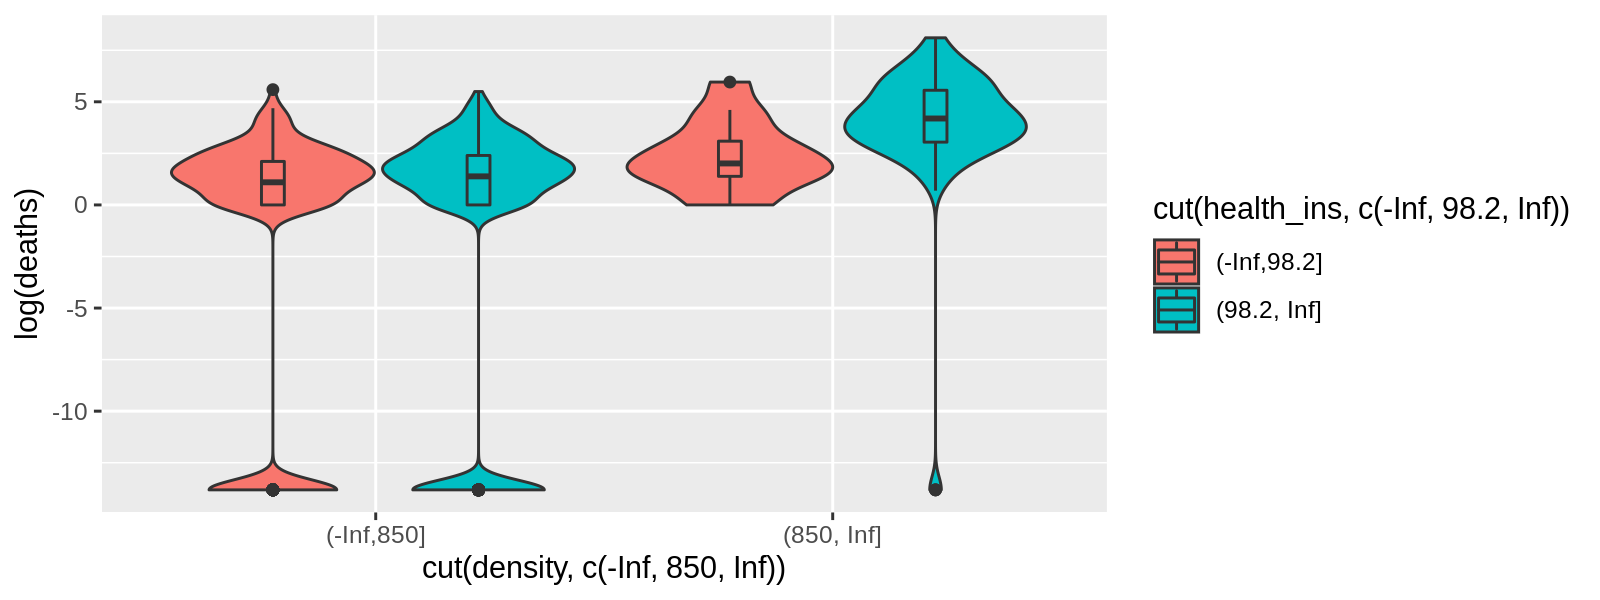

In [171]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(density, c(-Inf, 850, Inf)), log(deaths), fill=cut(health_ins, c(-Inf, 98.2, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

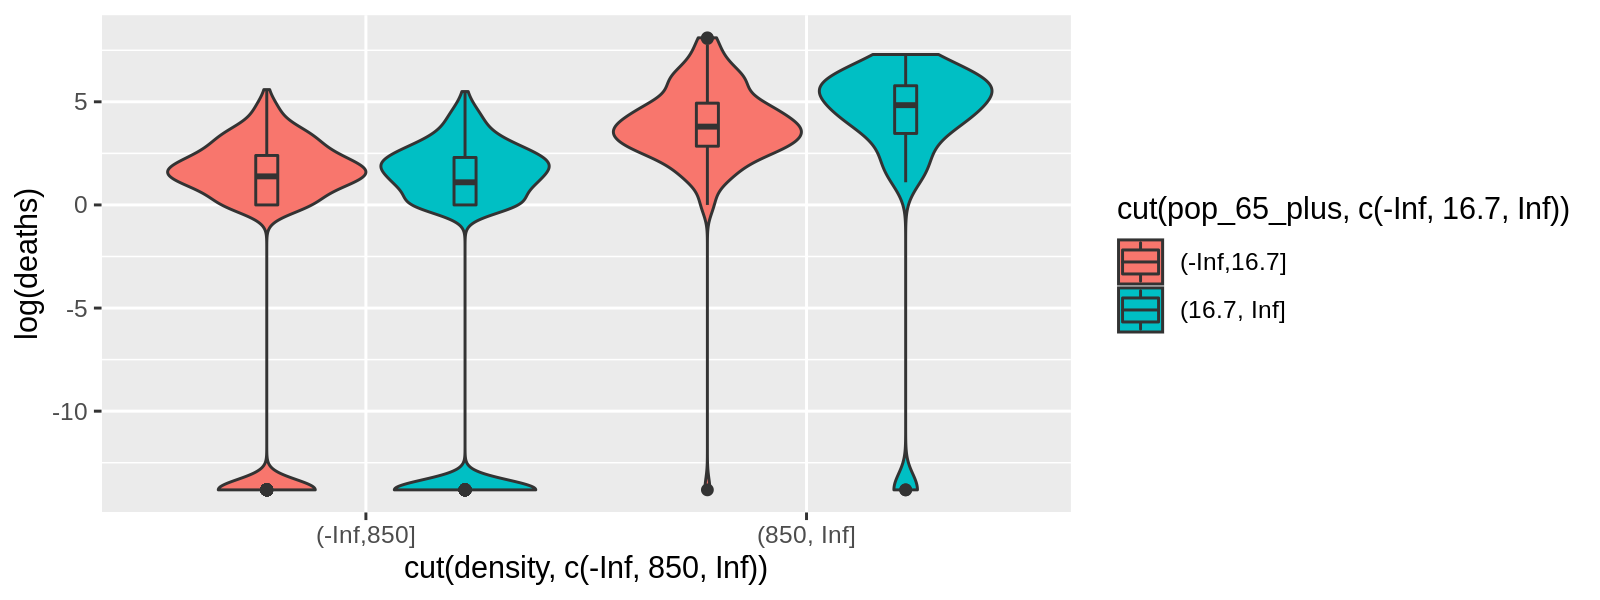

In [166]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(density, c(-Inf, 850, Inf)), log(deaths), fill=cut(pop_65_plus, c(-Inf, 16.7, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

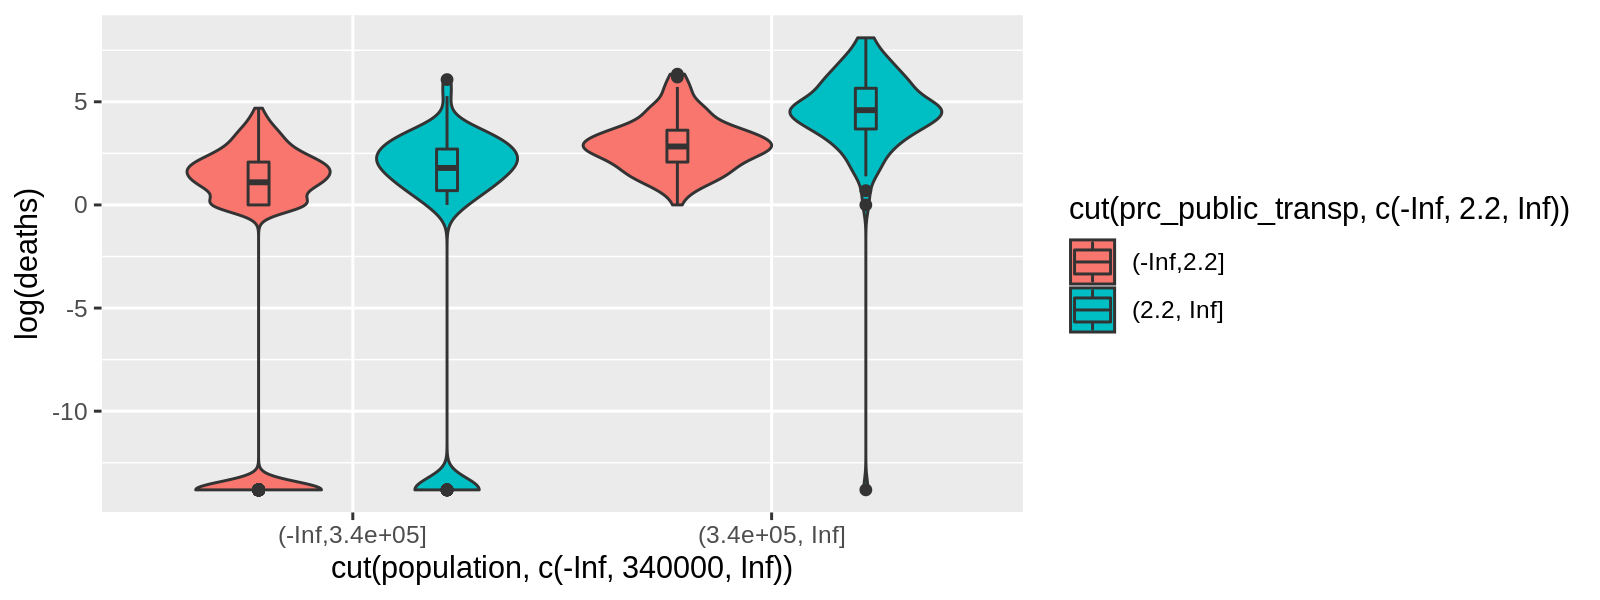

In [162]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(population, c(-Inf, 340000, Inf)), log(deaths), fill=cut(prc_public_transp, c(-Inf, 2.2, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

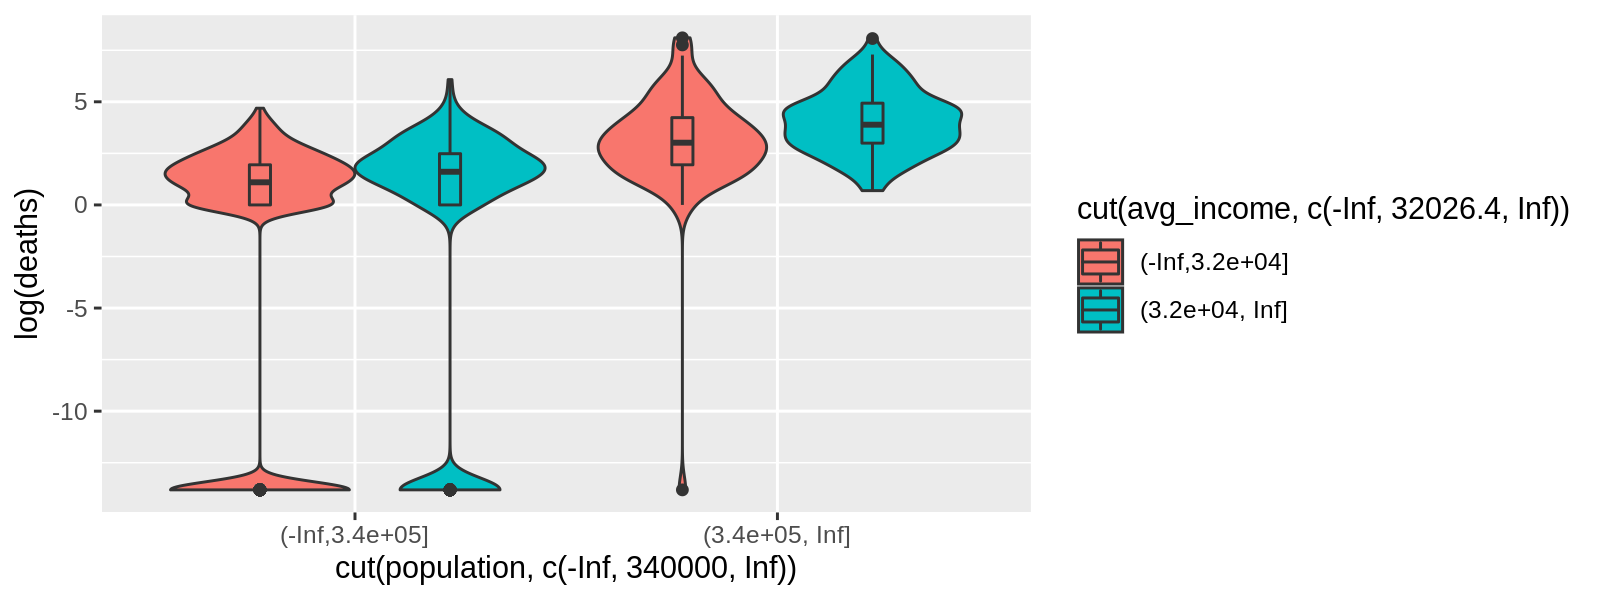

In [157]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(population, c(-Inf, 340000, Inf)), log(deaths), fill=cut(avg_income, c(-Inf, 32026.4, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

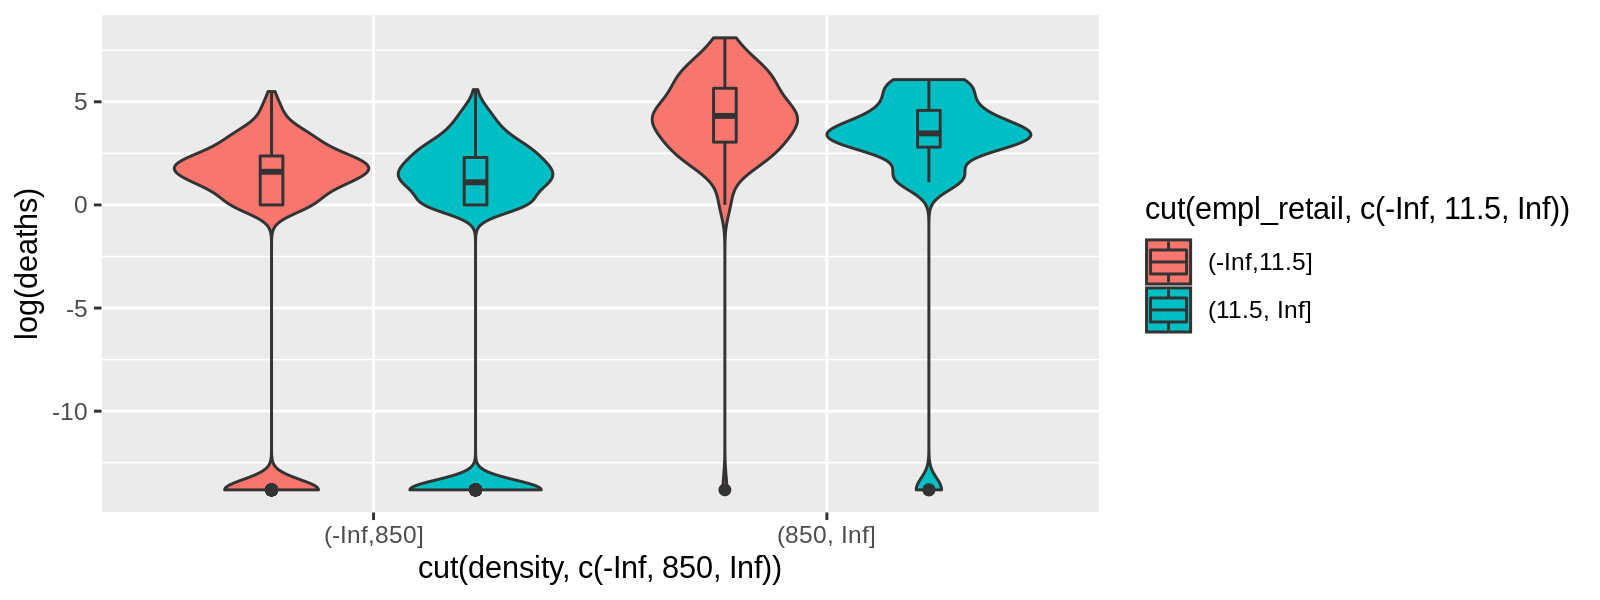

In [136]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(density, c(-Inf, 850, Inf)), log(deaths), fill=cut(empl_retail, c(-Inf, 11.5, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

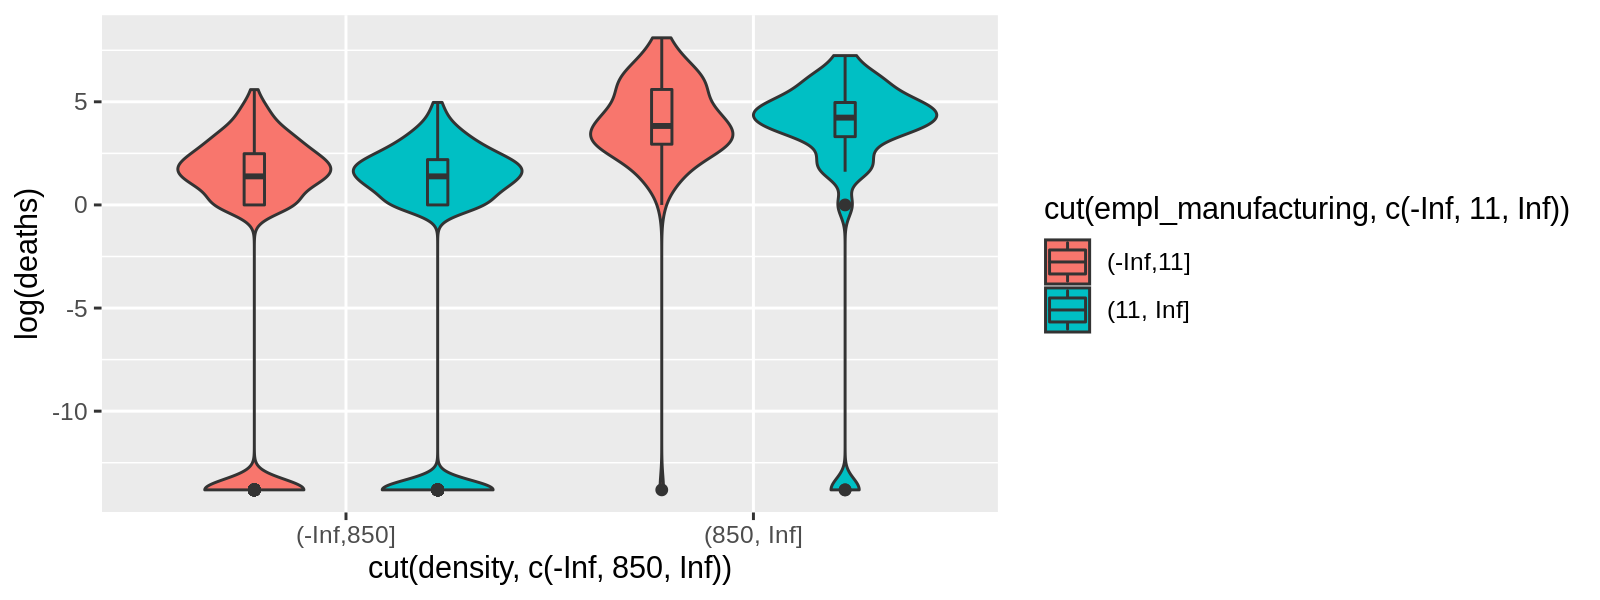

In [137]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(density, c(-Inf, 850, Inf)), log(deaths), fill=cut(empl_manufacturing, c(-Inf, 11.0, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

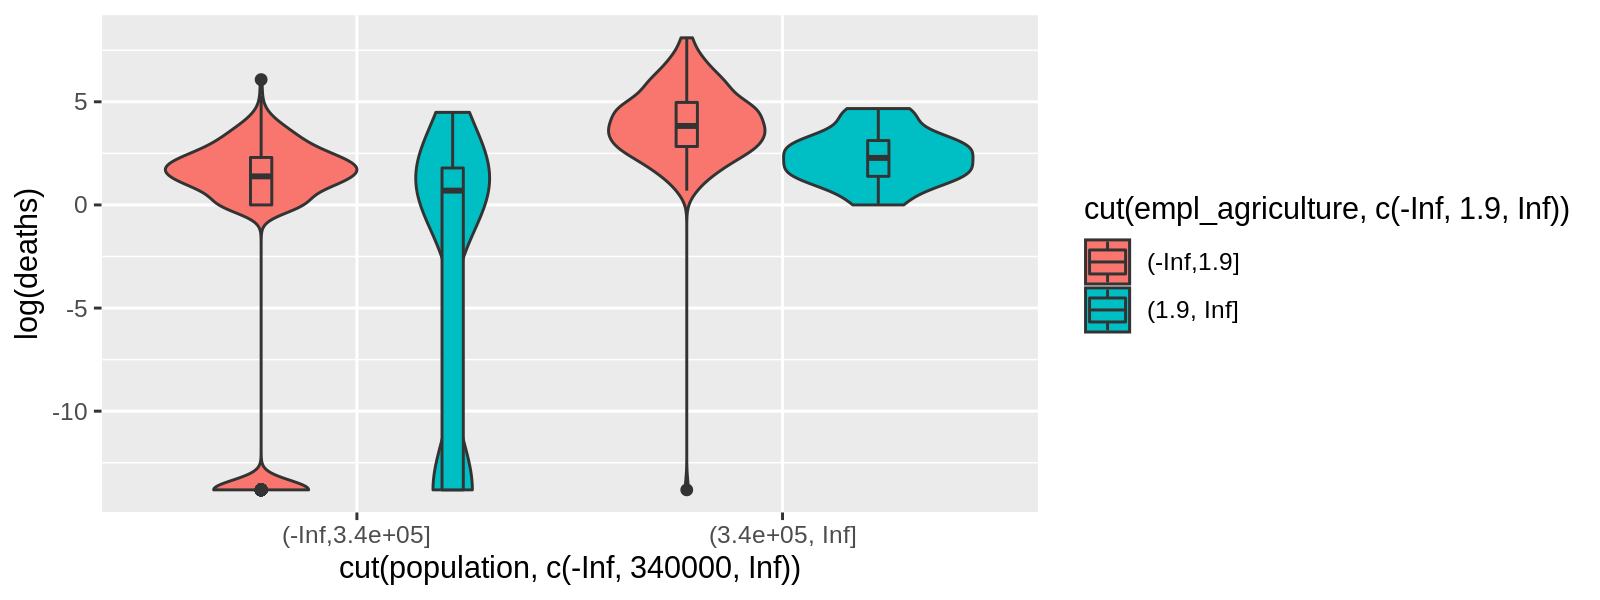

In [138]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(population, c(-Inf, 340000, Inf)), log(deaths), fill=cut(empl_agriculture, c(-Inf, 1.9, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

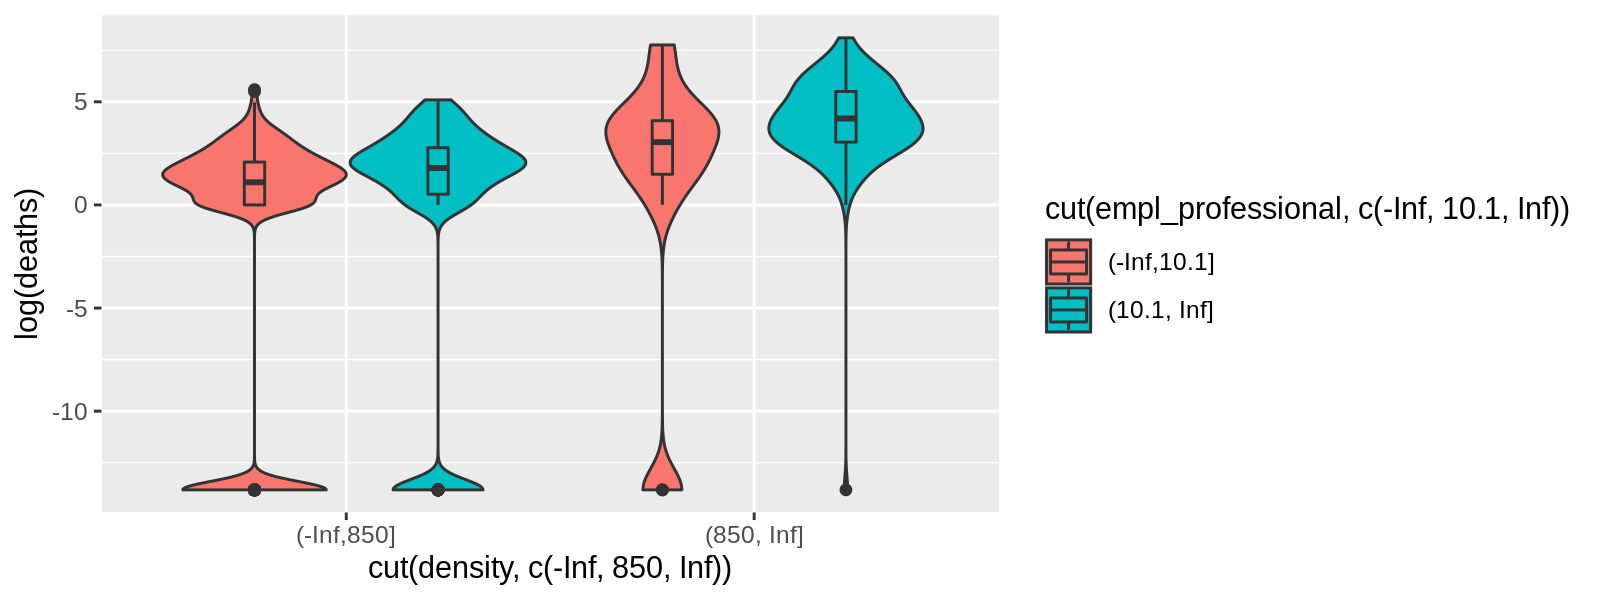

In [139]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(density, c(-Inf, 850, Inf)), log(deaths), fill=cut(empl_professional, c(-Inf, 10.1, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

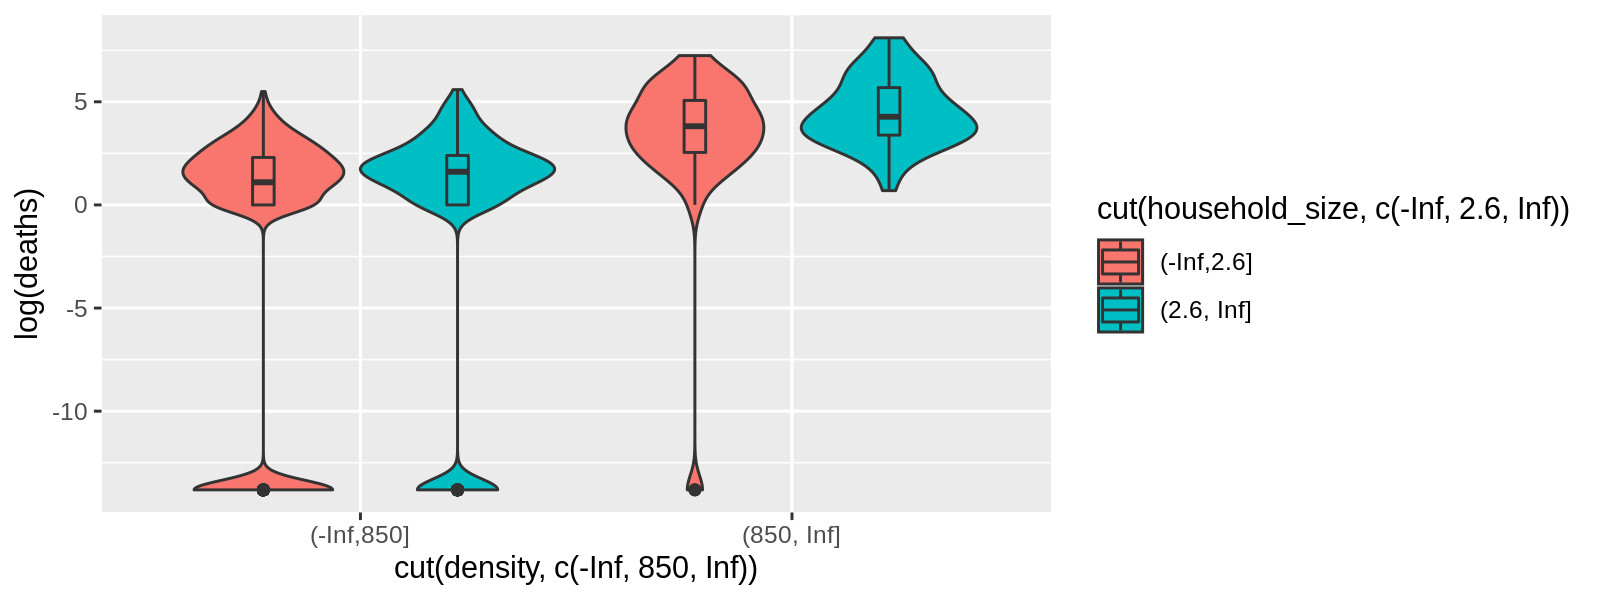

In [140]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(density, c(-Inf, 850, Inf)), log(deaths), fill=cut(household_size, c(-Inf, 2.6, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

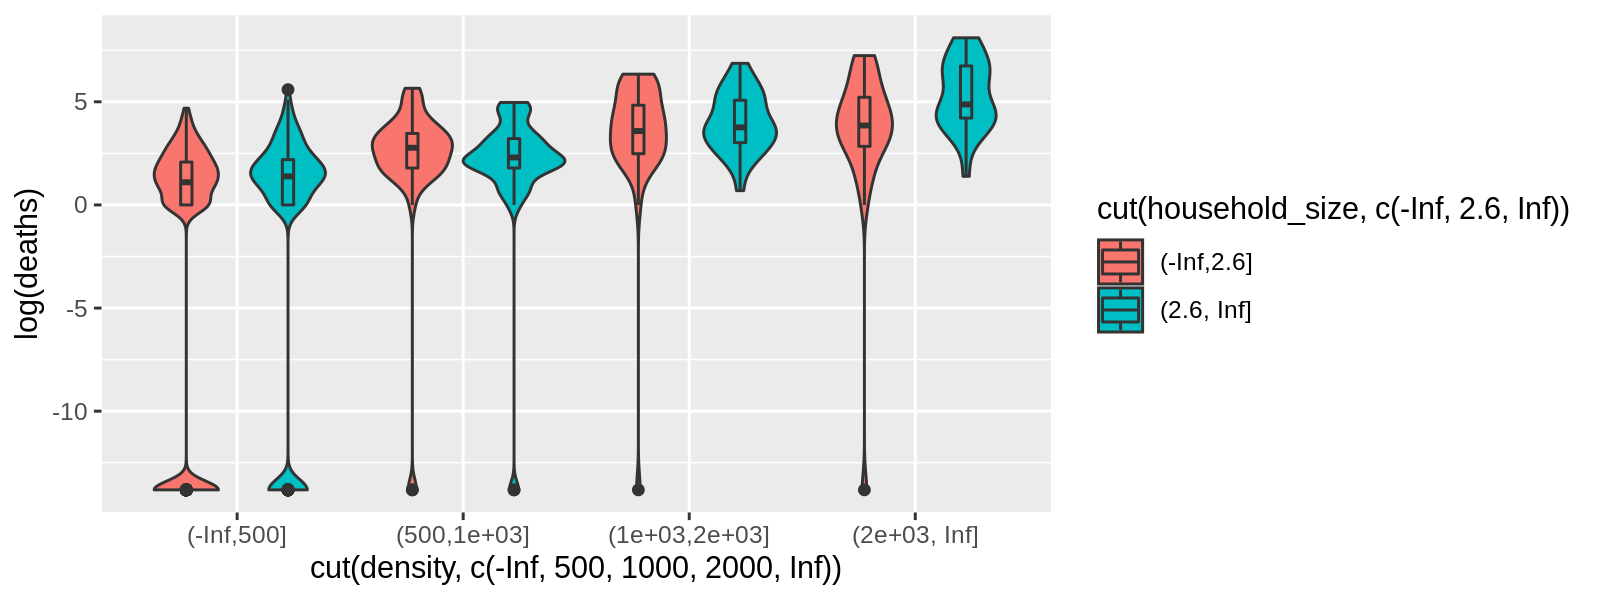

In [141]:
%%R -w 8 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(density, c(-Inf, 500, 1000, 2000, Inf)), log(deaths), fill=cut(household_size, c(-Inf, 2.6, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

In [142]:
abbrev.columns

Index(['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
       'empl_transp_utilities', 'prc_fam_poverty', 'avg_income',
       'prc_public_transp', 'population', 'pop_65_plus', 'health_ins',
       'county', 'state', 'FIPS', 'area', 'prc_obese', 'incarcerated',
       'domestic_passengers', 'intl_passengers', 'deaths_march24',
       'deaths_april1', 'deaths', 'cases_march24', 'cases_april1',
       'cases_april23', 'ten_plus', 'order', 'density', 'death_prc'],
      dtype='object')

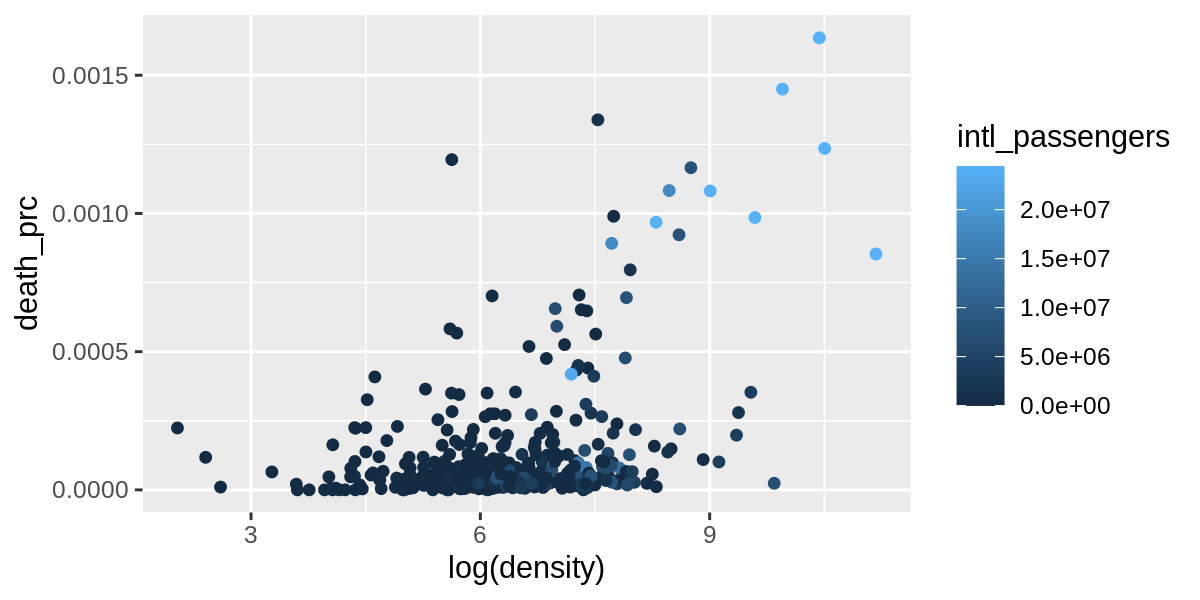

In [280]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev[abbrev$ten_plus > 28,]) + geom_jitter(aes(log(density), death_prc, color=intl_passengers))
# went through all reasonable features and couldn't see any clear trends

### Transform 'health_ins' to (percent) 'uninsured'

In [357]:
abbrev.columns

Index(['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
       'empl_transp_utilities', 'prc_fam_poverty', 'avg_income',
       'prc_public_transp', 'population', 'pop_65_plus', 'health_ins',
       'county', 'state', 'FIPS', 'area', 'prc_obese', 'incarcerated',
       'domestic_passengers', 'intl_passengers', 'deaths_march24',
       'deaths_april1', 'deaths', 'cases_march24', 'cases_april1',
       'cases_april23', 'ten_plus', 'order', 'density', 'death_prc'],
      dtype='object')

In [359]:
abbrev["uninsured"] = 100-abbrev["health_ins"]

In [360]:
abbrev[["uninsured", "health_ins"]].describe()

uninsured  health_ins
count      827.0       827.0
mean         1.8        98.2
std          2.1         2.1
min          0.2        77.5
25%          0.8        98.1
50%          1.1        98.9
75%          1.9        99.2
max         22.5        99.8

In [361]:
abbrev.drop("health_ins", axis=1, inplace=True)

In [362]:
abbrev.to_csv("abbrev.csv")